In [1]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [2]:
import os
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
import cv2

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import skvideo
import skvideo.io

def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [4]:
def get_mask_resized_num(targ,mask):
    im2 = Image.fromarray((mask*255).astype(np.uint8)).resize(size=(targ[1],targ[0]), resample=PIL.Image.NEAREST)
    return np.array(im2)

In [5]:
def inflate_mask(mask,radius=5):
    mask_temp = Image.fromarray(mask).filter(ImageFilter.GaussianBlur(radius))
    mask_temp = np.array(mask_temp)
    mask_temp[mask_temp>0]=255
    return mask_temp

In [6]:
def plot_triple(mask1,mask2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(mask1,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,2);plt.imshow(mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,3);plt.imshow(mask1+mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.tight_layout()

In [7]:
def random_jiggle_mask(all_mask,inteligent_random=True):
    min_y, min_x = np.argwhere(all_mask).min(axis=0)
    max_y, max_x = np.argwhere(all_mask).max(axis=0)
    dist_x = max_x-min_x
    dist_y = max_y-min_y
    avail_x = np.arange(0,all_mask.shape[1]-dist_x)
    avail_y = np.arange(0,all_mask.shape[0]-dist_y)
    
    #inteligent_random = True
    if inteligent_random==True:
        prob_x = np.ones(len(avail_x))
        prob_x[((avail_x>=min_x-dist_x)*(avail_x<=max_x))]=.001

        prob_y = np.ones(len(avail_y))
        prob_y[((avail_y>=min_y)*(avail_y<=max_y))]=.001

        choose_x = random.choices(avail_x,weights=prob_x,k=1)[0]
        choose_y = random.choices(avail_y,weights=prob_y,k=1)[0]
    else:        
        choose_x = random.choice(avail_x)
        choose_y = random.choice(avail_y)
    
    e_mask = np.zeros(all_mask.shape)
    blob = all_mask[min_y:max_y,min_x:max_x]
    e_mask[choose_y:choose_y+dist_y,choose_x:choose_x+dist_x] = blob
    return e_mask.astype(np.uint8)

In [8]:
indir = '~/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'
indir = os.path.expanduser(indir)
indir

'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'

In [9]:
folders = [folder for folder in os.listdir(indir) if not folder.startswith('.')]
folders.sort()
n = len(folders)
print(n)
folders[0:3]

499


['ALS_IceBucket_Challenge', 'CPR', 'abseiling']

In [10]:
fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'

(20, 499)
(0.8550100200400802, 8533)


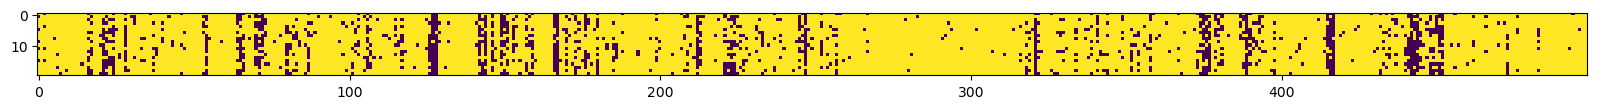

In [11]:
#good_videos = np.load('good_videos.npy')
good_videos = np.load('good_videos_1p.npy')
print(good_videos.shape)
print((good_videos.mean(),good_videos.sum()))
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(good_videos)

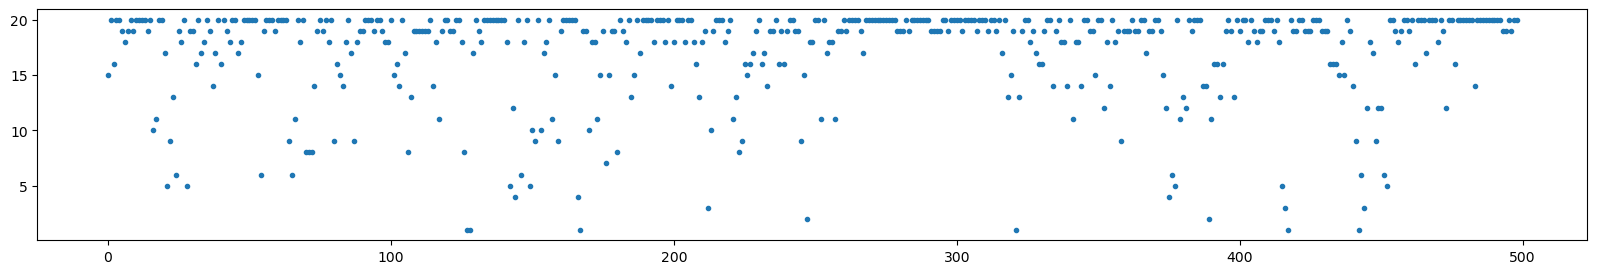

In [12]:
plt.figure(figsize=np.array((20,3)))
plt.plot(good_videos.sum(axis=0),'.')

In [13]:
good_videos[:,good_videos.sum(axis=0)<20] = False

In [14]:
# good_videos[:,good_videos.sum(axis=0)<15] = False
# good_videos[15:20,:] = False

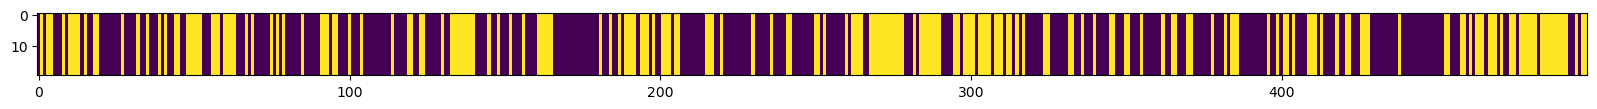

In [15]:
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(good_videos)

In [16]:
print(good_videos.mean(),good_videos.sum())

0.40681362725450904 4060


In [17]:
###

calc_or_load = 'load'

if calc_or_load=='calc':

    fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'
    pad_fn_temp = './Data/haa500_v1_1_resized/video/{folder}/{folder}_{video}_padding.npy'

    fns = []
    masks = []
    paddings = []

    for f in tqdm(range(good_videos.shape[1])):
        for v in range(good_videos.shape[0]):
            if bool(good_videos[v,f])==True:
                fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')

                mask = np.load(fn)
                mask = inflate_mask((( mask.sum(axis=0) >0 )*255).astype(np.uint8),radius=15)
                mask = get_mask_resized_num((360, 640),mask)


                pad_fn = pad_fn_temp.format(folder=folders[f],video=f'{v:03d}')
                pad = np.load(pad_fn)

                fns.append(fn)
                masks.append(mask)
                paddings.append(pad)
                
                
    
    
    
    masks = np.array(masks)
    fns = np.array(fns)
    paddings = (np.array(paddings)==0)*1
    #paddings = np.array(paddings)
    
    np.savez_compressed('./Data/data_good_videos_1p_masks.npz',arr=masks)
    np.savez_compressed('./Data/data_good_videos_1p_fns.npz',arr=fns)
    np.savez_compressed('./Data/data_good_videos_1p_paddings.npz',arr=paddings)
    #np.savez_compressed('./Data/data_good_videos_1p.npz',masks=masks,fns=fns,paddings=paddings)
    
elif calc_or_load=='load':
    
    masks = np.load('./Data/data_good_videos_1p_masks.npz')['arr']
    fns = np.load('./Data/data_good_videos_1p_fns.npz')['arr']
    paddings = np.load('./Data/data_good_videos_1p_paddings.npz')['arr']
    
    #a = np.load('./Data/data_good_videos_1p.npz')
    ## TODO fix loading
    #masks = a['masks']
    #fns = a['fns']
    #paddings = a['paddings']
    #paddings = (paddings==0)*1

    #del a
    
    print(masks.shape)
    print(fns.shape)
    print(paddings.shape)

(4060, 360, 640)
(4060,)
(4060, 360, 640)


In [18]:
masks.shape

(4060, 360, 640)

In [19]:
paddings.shape

(4060, 360, 640)

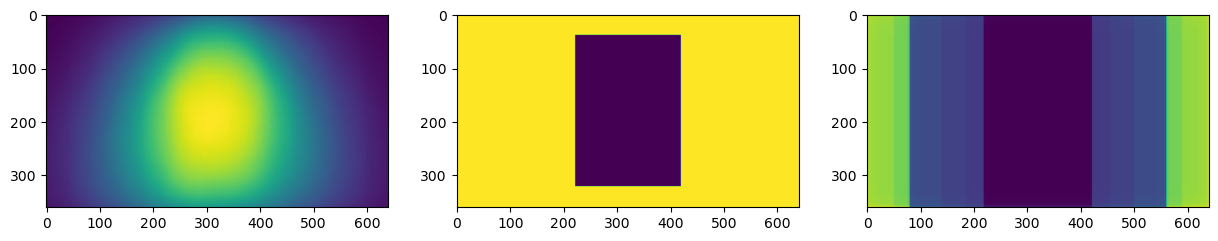

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.imshow(masks.mean(axis=0))
plt.subplot(1,3,2);plt.imshow(paddings.max(axis=0))
plt.subplot(1,3,3);plt.imshow(paddings.mean(axis=0))
#plt.show()

In [21]:
# %%time
# filled_spots = np.load('./Data/data_inpainting_idx_filled_spots.npz')['arr']
# spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for.npz')['arr']
# where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx.npz')['arr']
# masks_to_inpain = np.load('./Data/data_inpainting_idx_masks_to_inpain.npz')['arr']

In [22]:
calc_or_load_inpaint_idx = 'continue'

if calc_or_load_inpaint_idx == 'calc':
    
    n = masks.shape[0]
    filled_spots = np.repeat(False,n)
    spots_found_for = np.repeat(False,n)
    where_to_inpaint_idx = np.zeros(n)
    masks_to_inpaint = np.zeros(masks.shape) # To keep the jiggled masks 

    plt.ioff()
    for i in tqdm(range(n)):
        this_mask = masks[i,:,:] # grab a mask
        
        for rr in range(50): #V2.0 jiggle a hundo times
            this_mask = random_jiggle_mask(this_mask,inteligent_random=False) # V2.0 Jiggle the mask 

            ## N.B if comp is <1.0 or <255
            where_fits = np.array( [(  this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float)   ).max()   <=1.0 for j in range(n)] ) # Teh l33t alg0
            where_fits[filled_spots] = False # Make sure not already filles

            if where_fits.sum()>0:
                #print('triggered')
                where_fits_idx = np.nonzero(where_fits)[0]
                temp = np.argsort([    ((this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float))==0).sum()       for j in where_fits_idx])[0]
                where_fits_choose = where_fits_idx[temp]

                # Bookkeeping
                filled_spots[where_fits_choose] = True
                spots_found_for[i]=True
                where_to_inpaint_idx[i] = where_fits_choose
                masks_to_inpaint[i,:,:] = this_mask # V2.0

                plot_triple(this_mask,masks[where_fits_choose,:,:]+paddings[where_fits_choose,:,:])
                plt.savefig(f'./Data/inpaint-triplet-figs/{i:04d}.png')
                plt.close()
                
                break # If found a spot, break out of the for loop
                
            if np.mod(i,100)==0:
                np.savez_compressed('./Data/data_inpainting_idx_filled_spots.npz',arr=filled_spots)
                np.savez_compressed('./Data/data_inpainting_idx_spots_found_for.npz',arr=spots_found_for)
                np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx.npz',arr=where_to_inpaint_idx)
                np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain.npz',arr=masks_to_inpaint)

    print('saving')
    #np.savez_compressed('./Data/data_inpainting_idx.npz',filled_spots=filled_spots,spots_found_for=spots_found_for,where_to_inpaint_idx=where_to_inpaint_idx,masks_to_inpain=masks_to_inpaint)
    np.savez_compressed('./Data/data_inpainting_idx_filled_spots.npz',arr=filled_spots)
    np.savez_compressed('./Data/data_inpainting_idx_spots_found_for.npz',arr=spots_found_for)
    np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx.npz',arr=where_to_inpaint_idx)
    np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain.npz',arr=masks_to_inpaint)
    print('done')
    
elif calc_or_load_inpaint_idx == 'load':

    filled_spots = np.load('./Data/data_inpainting_idx_filled_spots.npz')['arr']
    spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for.npz')['arr']
    where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx.npz')['arr']
    masks_to_inpain = np.load('./Data/data_inpainting_idx_masks_to_inpain.npz')['arr']

    
elif calc_or_load_inpaint_idx == 'continue':
    
    n = masks.shape[0]
    filled_spots = np.load('./Data/data_inpainting_idx_filled_spots.npz')['arr']
    spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for.npz')['arr']
    where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx.npz')['arr']
    masks_to_inpaint = np.load('./Data/data_inpainting_idx_masks_to_inpain.npz')['arr']
    start_point = spots_found_for.nonzero()[0].max()
    
    plt.ioff()
    for i in tqdm(range(start_point,n)):
        this_mask = masks[i,:,:] # grab a mask
        
        for rr in range(50): #V2.0 jiggle a hundo times
            this_mask = random_jiggle_mask(this_mask,inteligent_random=False) # V2.0 Jiggle the mask 

            ## N.B if comp is <1.0 or <255
            where_fits = np.array( [(  this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float)   ).max()   <=1.0 for j in range(n)] ) # Teh l33t alg0
            where_fits[filled_spots] = False # Make sure not already filles

            if where_fits.sum()>0:
                #print('triggered')
                where_fits_idx = np.nonzero(where_fits)[0]
                temp = np.argsort([    ((this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float))==0).sum()       for j in where_fits_idx])[0]
                where_fits_choose = where_fits_idx[temp]

                # Bookkeeping
                filled_spots[where_fits_choose] = True
                spots_found_for[i]=True
                where_to_inpaint_idx[i] = where_fits_choose
                masks_to_inpaint[i,:,:] = this_mask # V2.0

                plot_triple(this_mask,masks[where_fits_choose,:,:]+paddings[where_fits_choose,:,:])
                plt.savefig(f'./Data/inpaint-triplet-figs/{i:04d}.png')
                plt.close()
                
                break # If found a spot, break out of the for loop
                
        if np.mod(i,500)==0:
            np.savez_compressed('./Data/data_inpainting_idx_filled_spots.npz',arr=filled_spots)
            np.savez_compressed('./Data/data_inpainting_idx_spots_found_for.npz',arr=spots_found_for)
            np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx.npz',arr=where_to_inpaint_idx)
            np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain.npz',arr=masks_to_inpaint)

    print('saving')
    #np.savez_compressed('./Data/data_inpainting_idx.npz',filled_spots=filled_spots,spots_found_for=spots_found_for,where_to_inpaint_idx=where_to_inpaint_idx,masks_to_inpain=masks_to_inpaint)
    np.savez_compressed('./Data/data_inpainting_idx_filled_spots.npz',arr=filled_spots)
    np.savez_compressed('./Data/data_inpainting_idx_spots_found_for.npz',arr=spots_found_for)
    np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx.npz',arr=where_to_inpaint_idx)
    np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain.npz',arr=masks_to_inpaint)
    print('done')

  0%|          | 0/2561 [00:00<?, ?it/s]

  0%|          | 1/2561 [00:04<3:09:18,  4.44s/it]

  0%|          | 2/2561 [00:48<19:48:14, 27.86s/it]

  0%|          | 3/2561 [00:57<13:42:05, 19.28s/it]

  0%|          | 4/2561 [01:17<13:53:35, 19.56s/it]

  0%|          | 5/2561 [01:25<10:58:29, 15.46s/it]

  0%|          | 6/2561 [01:34<9:13:19, 12.99s/it] 

  0%|          | 7/2561 [01:38<7:11:28, 10.14s/it]

  0%|          | 8/2561 [01:42<5:51:03,  8.25s/it]

  0%|          | 9/2561 [02:26<13:46:47, 19.44s/it]

  0%|          | 10/2561 [03:51<28:06:45, 39.67s/it]

  0%|          | 11/2561 [04:04<22:18:55, 31.50s/it]

  0%|          | 12/2561 [04:13<17:19:35, 24.47s/it]

  1%|          | 13/2561 [04:25<14:45:09, 20.84s/it]

  1%|          | 14/2561 [04:29<11:12:53, 15.85s/it]

  1%|          | 15/2561 [04:38<9:40:01, 13.67s/it] 

  1%|          | 16/2561 [05:07<12:54:44, 18.26s/it]

  1%|          | 17/2561 [05:27<13:20:45, 18.89s/it]

  1%|          | 18/2561 [05:32<10:23:37, 14.71s/it]

  1%|          | 19/2561 [05:36<8:10:28, 11.58s/it] 

  1%|          | 20/2561 [06:28<16:42:09, 23.66s/it]

  1%|          | 21/2561 [06:33<12:45:16, 18.08s/it]

  1%|          | 22/2561 [09:51<50:41:01, 71.86s/it]

  1%|          | 23/2561 [13:07<77:03:53, 109.31s/it]

  1%|          | 24/2561 [16:26<95:59:44, 136.22s/it]

  1%|          | 25/2561 [19:34<106:49:40, 151.65s/it]

  1%|          | 26/2561 [22:38<113:39:50, 161.42s/it]

  1%|          | 27/2561 [26:02<122:36:01, 174.18s/it]

  1%|          | 28/2561 [28:47<120:41:39, 171.54s/it]

  1%|          | 29/2561 [31:21<116:56:17, 166.26s/it]

  1%|          | 30/2561 [34:41<124:01:18, 176.40s/it]

  1%|          | 31/2561 [34:46<87:39:23, 124.73s/it] 

  1%|          | 32/2561 [38:06<103:34:19, 147.43s/it]

  1%|▏         | 33/2561 [41:26<114:31:40, 163.09s/it]

  1%|▏         | 34/2561 [43:34<107:06:25, 152.59s/it]

  1%|▏         | 35/2561 [45:34<100:12:58, 142.83s/it]

  1%|▏         | 36/2561 [48:55<112:32:13, 160.45s/it]

  1%|▏         | 37/2561 [52:18<121:22:22, 173.12s/it]

  1%|▏         | 38/2561 [55:37<126:47:12, 180.91s/it]

  2%|▏         | 39/2561 [58:56<130:31:13, 186.31s/it]

  2%|▏         | 40/2561 [1:02:20<134:06:07, 191.50s/it]

  2%|▏         | 41/2561 [1:02:28<95:37:12, 136.60s/it] 

  2%|▏         | 42/2561 [1:05:50<109:14:43, 156.13s/it]

  2%|▏         | 43/2561 [1:09:09<118:13:20, 169.02s/it]

  2%|▏         | 44/2561 [1:12:30<124:51:01, 178.57s/it]

  2%|▏         | 45/2561 [1:12:34<88:17:29, 126.33s/it] 

  2%|▏         | 46/2561 [1:15:53<103:23:06, 147.99s/it]

  2%|▏         | 47/2561 [1:16:01<74:07:55, 106.16s/it] 

  2%|▏         | 48/2561 [1:16:21<56:02:34, 80.28s/it] 

  2%|▏         | 49/2561 [1:19:40<80:44:50, 115.72s/it]

  2%|▏         | 50/2561 [1:19:52<59:07:00, 84.76s/it] 

  2%|▏         | 51/2561 [1:23:13<83:28:20, 119.72s/it]

  2%|▏         | 52/2561 [1:26:35<100:37:33, 144.38s/it]

  2%|▏         | 53/2561 [1:29:57<112:30:53, 161.50s/it]

  2%|▏         | 54/2561 [1:33:19<120:56:53, 173.68s/it]

  2%|▏         | 55/2561 [1:36:41<126:46:28, 182.12s/it]

  2%|▏         | 56/2561 [1:39:59<130:05:45, 186.96s/it]

  2%|▏         | 57/2561 [1:43:22<133:24:14, 191.79s/it]

  2%|▏         | 58/2561 [1:44:14<104:10:54, 149.84s/it]

  2%|▏         | 59/2561 [1:46:45<104:16:46, 150.04s/it]

  2%|▏         | 60/2561 [1:50:08<115:21:14, 166.04s/it]

  2%|▏         | 61/2561 [1:53:31<122:59:13, 177.10s/it]

  2%|▏         | 62/2561 [1:56:49<127:21:27, 183.47s/it]

  2%|▏         | 63/2561 [2:00:07<130:18:08, 187.79s/it]

  2%|▏         | 64/2561 [2:01:03<102:44:20, 148.12s/it]

  3%|▎         | 65/2561 [2:04:22<113:23:50, 163.55s/it]

  3%|▎         | 66/2561 [2:04:31<81:06:07, 117.02s/it] 

  3%|▎         | 67/2561 [2:07:50<98:13:55, 141.79s/it]

  3%|▎         | 68/2561 [2:09:14<86:02:54, 124.26s/it]

  3%|▎         | 69/2561 [2:12:31<101:14:27, 146.26s/it]

  3%|▎         | 70/2561 [2:13:51<87:28:25, 126.42s/it] 

  3%|▎         | 71/2561 [2:14:12<65:27:05, 94.63s/it] 

  3%|▎         | 72/2561 [2:17:31<87:07:55, 126.02s/it]

  3%|▎         | 73/2561 [2:20:17<95:28:27, 138.15s/it]

  3%|▎         | 74/2561 [2:23:40<108:47:58, 157.49s/it]

  3%|▎         | 75/2561 [2:26:33<112:00:20, 162.20s/it]

  3%|▎         | 76/2561 [2:29:57<120:30:36, 174.58s/it]

  3%|▎         | 77/2561 [2:33:21<126:31:53, 183.38s/it]

  3%|▎         | 78/2561 [2:36:42<130:13:10, 188.80s/it]

  3%|▎         | 79/2561 [2:40:06<133:12:54, 193.22s/it]

  3%|▎         | 80/2561 [2:40:10<94:05:12, 136.52s/it] 

  3%|▎         | 81/2561 [2:43:31<107:20:49, 155.83s/it]

  3%|▎         | 82/2561 [2:43:43<77:40:04, 112.79s/it] 

  3%|▎         | 83/2561 [2:47:04<95:50:31, 139.24s/it]

  3%|▎         | 84/2561 [2:50:26<108:50:12, 158.18s/it]

  3%|▎         | 85/2561 [2:53:51<118:26:19, 172.21s/it]

  3%|▎         | 86/2561 [2:57:13<124:26:09, 181.00s/it]

  3%|▎         | 87/2561 [2:57:25<89:36:22, 130.39s/it] 

  3%|▎         | 88/2561 [2:57:57<69:22:05, 100.98s/it]

  3%|▎         | 89/2561 [2:58:46<58:33:39, 85.28s/it] 

  4%|▎         | 90/2561 [2:58:58<43:29:52, 63.37s/it]

  4%|▎         | 91/2561 [3:02:20<71:59:22, 104.92s/it]

  4%|▎         | 92/2561 [3:05:42<91:57:40, 134.09s/it]

  4%|▎         | 93/2561 [3:06:03<68:31:13, 99.95s/it] 

  4%|▎         | 94/2561 [3:09:24<89:24:59, 130.48s/it]

  4%|▎         | 95/2561 [3:12:45<103:51:51, 151.63s/it]

  4%|▎         | 96/2561 [3:16:06<113:49:28, 166.23s/it]

  4%|▍         | 97/2561 [3:16:30<84:38:24, 123.66s/it] 

  4%|▍         | 98/2561 [3:19:53<100:57:40, 147.57s/it]

  4%|▍         | 99/2561 [3:19:58<71:34:15, 104.65s/it] 

  4%|▍         | 100/2561 [3:20:03<51:04:46, 74.72s/it]

  4%|▍         | 101/2561 [3:21:01<47:42:08, 69.81s/it]

  4%|▍         | 102/2561 [3:21:06<34:18:14, 50.22s/it]

  4%|▍         | 103/2561 [3:21:14<25:44:10, 37.69s/it]

  4%|▍         | 104/2561 [3:21:27<20:35:27, 30.17s/it]

  4%|▍         | 105/2561 [3:21:31<15:18:00, 22.43s/it]

  4%|▍         | 106/2561 [3:21:35<11:36:39, 17.03s/it]

  4%|▍         | 107/2561 [3:22:09<14:58:48, 21.98s/it]

  4%|▍         | 108/2561 [3:25:32<51:58:05, 76.27s/it]

  4%|▍         | 109/2561 [3:28:52<77:18:12, 113.50s/it]

  4%|▍         | 110/2561 [3:29:01<55:46:08, 81.91s/it] 

  4%|▍         | 111/2561 [3:29:05<39:55:09, 58.66s/it]

  4%|▍         | 112/2561 [3:32:25<68:49:20, 101.17s/it]

  4%|▍         | 113/2561 [3:35:46<89:05:35, 131.02s/it]

  4%|▍         | 114/2561 [3:35:50<63:11:47, 92.97s/it] 

  4%|▍         | 115/2561 [3:35:59<45:55:13, 67.59s/it]

  5%|▍         | 116/2561 [3:38:23<61:28:15, 90.51s/it]

  5%|▍         | 117/2561 [3:41:49<84:59:35, 125.19s/it]

  5%|▍         | 118/2561 [3:41:57<61:12:52, 90.21s/it] 

  5%|▍         | 119/2561 [3:42:14<46:17:11, 68.24s/it]

  5%|▍         | 120/2561 [3:45:38<73:47:34, 108.83s/it]

  5%|▍         | 121/2561 [3:45:50<54:06:52, 79.84s/it] 

  5%|▍         | 122/2561 [3:46:19<43:44:14, 64.56s/it]

  5%|▍         | 123/2561 [3:49:40<71:30:14, 105.58s/it]

  5%|▍         | 124/2561 [3:52:54<89:22:47, 132.03s/it]

  5%|▍         | 125/2561 [3:55:42<96:41:00, 142.88s/it]

  5%|▍         | 126/2561 [3:59:03<108:26:37, 160.33s/it]

  5%|▍         | 127/2561 [3:59:16<78:26:04, 116.01s/it] 

  5%|▍         | 128/2561 [4:01:42<84:36:15, 125.19s/it]

  5%|▌         | 129/2561 [4:01:47<60:04:00, 88.91s/it] 

  5%|▌         | 130/2561 [4:05:06<82:25:53, 122.07s/it]

  5%|▌         | 131/2561 [4:06:38<76:22:33, 113.15s/it]

  5%|▌         | 132/2561 [4:07:12<60:10:54, 89.19s/it] 

  5%|▌         | 133/2561 [4:08:29<57:44:18, 85.61s/it]

  5%|▌         | 134/2561 [4:11:50<81:03:26, 120.23s/it]

  5%|▌         | 135/2561 [4:12:18<62:25:01, 92.62s/it] 

  5%|▌         | 136/2561 [4:15:39<84:13:50, 125.04s/it]

  5%|▌         | 137/2561 [4:15:55<62:14:03, 92.43s/it] 

  5%|▌         | 138/2561 [4:19:16<84:02:29, 124.87s/it]

  5%|▌         | 139/2561 [4:19:28<61:18:44, 91.13s/it] 

  5%|▌         | 140/2561 [4:19:36<44:34:50, 66.29s/it]

  6%|▌         | 141/2561 [4:19:41<32:03:24, 47.69s/it]

  6%|▌         | 142/2561 [4:19:45<23:17:12, 34.66s/it]

  6%|▌         | 143/2561 [4:23:06<56:52:01, 84.67s/it]

  6%|▌         | 144/2561 [4:25:54<73:36:44, 109.64s/it]

  6%|▌         | 145/2561 [4:27:36<71:53:38, 107.13s/it]

  6%|▌         | 146/2561 [4:30:58<91:00:43, 135.67s/it]

  6%|▌         | 147/2561 [4:34:18<103:59:15, 155.08s/it]

  6%|▌         | 148/2561 [4:35:45<90:10:28, 134.53s/it] 

  6%|▌         | 149/2561 [4:36:44<75:01:25, 111.98s/it]

  6%|▌         | 150/2561 [4:40:02<92:14:34, 137.73s/it]

  6%|▌         | 151/2561 [4:42:16<91:34:15, 136.79s/it]

  6%|▌         | 152/2561 [4:42:21<64:55:48, 97.03s/it] 

  6%|▌         | 153/2561 [4:45:41<85:42:12, 128.13s/it]

  6%|▌         | 154/2561 [4:48:58<99:24:41, 148.68s/it]

  6%|▌         | 155/2561 [4:52:15<109:04:23, 163.20s/it]

  6%|▌         | 156/2561 [4:54:59<109:11:54, 163.46s/it]

  6%|▌         | 157/2561 [4:58:19<116:25:32, 174.35s/it]

  6%|▌         | 158/2561 [5:01:26<118:50:21, 178.04s/it]

  6%|▌         | 159/2561 [5:02:57<101:32:28, 152.19s/it]

  6%|▌         | 160/2561 [5:03:25<76:35:11, 114.83s/it] 

  6%|▋         | 161/2561 [5:03:30<54:27:25, 81.69s/it] 

  6%|▋         | 162/2561 [5:06:46<77:29:02, 116.27s/it]

  6%|▋         | 163/2561 [5:10:04<93:44:02, 140.72s/it]

  6%|▋         | 164/2561 [5:13:23<105:20:34, 158.21s/it]

  6%|▋         | 165/2561 [5:16:11<107:08:18, 160.98s/it]

  6%|▋         | 166/2561 [5:18:53<107:26:27, 161.50s/it]

  7%|▋         | 167/2561 [5:22:13<114:57:54, 172.88s/it]

  7%|▋         | 168/2561 [5:24:50<111:50:30, 168.25s/it]

  7%|▋         | 169/2561 [5:28:11<118:15:43, 177.99s/it]

  7%|▋         | 170/2561 [5:30:27<109:55:02, 165.50s/it]

  7%|▋         | 171/2561 [5:33:45<116:11:54, 175.03s/it]

  7%|▋         | 172/2561 [5:36:00<108:09:36, 162.99s/it]

  7%|▋         | 173/2561 [5:39:17<114:55:11, 173.25s/it]

  7%|▋         | 174/2561 [5:42:34<119:44:47, 180.60s/it]

  7%|▋         | 175/2561 [5:45:54<123:22:57, 186.16s/it]

  7%|▋         | 176/2561 [5:49:11<125:37:59, 189.64s/it]

  7%|▋         | 177/2561 [5:52:33<127:58:29, 193.25s/it]

  7%|▋         | 178/2561 [5:54:57<118:11:43, 178.56s/it]

  7%|▋         | 179/2561 [5:58:17<122:18:58, 184.86s/it]

  7%|▋         | 180/2561 [6:01:34<124:40:34, 188.51s/it]

  7%|▋         | 181/2561 [6:04:54<127:01:21, 192.14s/it]

  7%|▋         | 182/2561 [6:05:26<95:11:39, 144.05s/it] 

  7%|▋         | 183/2561 [6:08:43<105:37:09, 159.89s/it]

  7%|▋         | 184/2561 [6:09:29<83:01:14, 125.74s/it] 

  7%|▋         | 185/2561 [6:12:46<97:03:10, 147.05s/it]

  7%|▋         | 186/2561 [6:14:35<89:31:02, 135.69s/it]

  7%|▋         | 187/2561 [6:17:54<102:01:31, 154.71s/it]

  7%|▋         | 188/2561 [6:18:38<80:01:45, 121.41s/it] 

  7%|▋         | 189/2561 [6:21:57<95:20:22, 144.70s/it]

  7%|▋         | 190/2561 [6:25:14<105:39:08, 160.42s/it]

  7%|▋         | 191/2561 [6:25:25<76:02:11, 115.50s/it] 

  7%|▋         | 192/2561 [6:28:42<92:12:45, 140.13s/it]

  8%|▊         | 193/2561 [6:32:00<103:31:39, 157.39s/it]

  8%|▊         | 194/2561 [6:35:19<111:35:22, 169.72s/it]

  8%|▊         | 195/2561 [6:38:36<116:58:31, 177.98s/it]

  8%|▊         | 196/2561 [6:39:13<89:14:41, 135.85s/it] 

  8%|▊         | 197/2561 [6:39:30<65:37:57, 99.95s/it] 

  8%|▊         | 198/2561 [6:42:52<85:51:00, 130.79s/it]

  8%|▊         | 199/2561 [6:46:13<99:28:29, 151.61s/it]

  8%|▊         | 200/2561 [6:49:32<108:52:56, 166.02s/it]

  8%|▊         | 201/2561 [6:49:42<78:05:59, 119.14s/it] 

  8%|▊         | 202/2561 [6:49:46<55:32:18, 84.76s/it] 

  8%|▊         | 203/2561 [6:50:03<42:09:30, 64.36s/it]

  8%|▊         | 204/2561 [6:50:45<37:48:14, 57.74s/it]

  8%|▊         | 205/2561 [6:50:55<28:17:40, 43.23s/it]

  8%|▊         | 206/2561 [6:51:00<20:48:56, 31.82s/it]

  8%|▊         | 207/2561 [6:54:21<53:59:41, 82.57s/it]

  8%|▊         | 208/2561 [6:54:43<42:01:44, 64.30s/it]

  8%|▊         | 209/2561 [6:54:48<30:24:47, 46.55s/it]

  8%|▊         | 210/2561 [6:55:00<23:42:10, 36.30s/it]

  8%|▊         | 211/2561 [6:58:27<56:59:47, 87.31s/it]

  8%|▊         | 212/2561 [6:58:37<41:57:26, 64.30s/it]

  8%|▊         | 213/2561 [7:02:00<68:59:33, 105.78s/it]

  8%|▊         | 214/2561 [7:02:08<49:52:47, 76.51s/it] 

  8%|▊         | 215/2561 [7:05:04<69:24:06, 106.50s/it]

  8%|▊         | 216/2561 [7:05:26<52:46:23, 81.02s/it] 

  8%|▊         | 217/2561 [7:05:36<38:56:38, 59.81s/it]

  9%|▊         | 218/2561 [7:05:50<29:54:01, 45.94s/it]

  9%|▊         | 219/2561 [7:05:59<22:43:29, 34.93s/it]

  9%|▊         | 220/2561 [7:09:21<55:11:02, 84.86s/it]

  9%|▊         | 221/2561 [7:09:53<44:58:42, 69.20s/it]

  9%|▊         | 222/2561 [7:10:13<35:22:59, 54.46s/it]

  9%|▊         | 223/2561 [7:11:14<36:36:53, 56.38s/it]

  9%|▊         | 224/2561 [7:11:27<28:06:37, 43.30s/it]

  9%|▉         | 225/2561 [7:13:52<47:56:49, 73.89s/it]

  9%|▉         | 226/2561 [7:15:51<56:45:51, 87.52s/it]

  9%|▉         | 227/2561 [7:19:09<78:07:02, 120.49s/it]

  9%|▉         | 228/2561 [7:22:29<93:35:48, 144.43s/it]

  9%|▉         | 229/2561 [7:25:47<104:00:29, 160.56s/it]

  9%|▉         | 230/2561 [7:27:01<87:01:38, 134.41s/it] 

  9%|▉         | 231/2561 [7:30:18<99:16:27, 153.39s/it]

  9%|▉         | 232/2561 [7:33:36<107:43:00, 166.50s/it]

  9%|▉         | 233/2561 [7:35:36<98:44:43, 152.70s/it] 

  9%|▉         | 234/2561 [7:38:52<107:10:15, 165.80s/it]

  9%|▉         | 235/2561 [7:42:08<112:52:17, 174.69s/it]

  9%|▉         | 236/2561 [7:45:24<117:00:44, 181.18s/it]

  9%|▉         | 237/2561 [7:48:40<119:53:54, 185.73s/it]

  9%|▉         | 238/2561 [7:51:57<121:57:04, 188.99s/it]

  9%|▉         | 239/2561 [7:53:30<103:13:58, 160.05s/it]

  9%|▉         | 240/2561 [7:53:49<75:53:30, 117.71s/it] 

  9%|▉         | 241/2561 [7:57:05<91:06:46, 141.38s/it]

  9%|▉         | 242/2561 [7:57:45<71:27:48, 110.94s/it]

  9%|▉         | 243/2561 [8:01:02<88:03:19, 136.76s/it]

 10%|▉         | 244/2561 [8:01:18<64:42:37, 100.54s/it]

 10%|▉         | 245/2561 [8:04:36<83:29:48, 129.79s/it]

 10%|▉         | 246/2561 [8:07:54<96:35:32, 150.21s/it]

 10%|▉         | 247/2561 [8:07:58<68:23:25, 106.40s/it]

 10%|▉         | 248/2561 [8:08:18<51:42:34, 80.48s/it] 

 10%|▉         | 249/2561 [8:10:28<61:14:18, 95.35s/it]

 10%|▉         | 250/2561 [8:13:45<80:45:35, 125.81s/it]

 10%|▉         | 251/2561 [8:16:35<89:15:50, 139.11s/it]

 10%|▉         | 252/2561 [8:19:53<100:34:06, 156.80s/it]

 10%|▉         | 253/2561 [8:21:18<86:37:46, 135.12s/it] 

 10%|▉         | 254/2561 [8:21:39<64:36:12, 100.81s/it]

 10%|▉         | 255/2561 [8:24:14<75:07:29, 117.28s/it]

 10%|▉         | 256/2561 [8:27:35<91:01:16, 142.16s/it]

 10%|█         | 257/2561 [8:30:53<101:43:18, 158.94s/it]

 10%|█         | 258/2561 [8:33:08<97:07:33, 151.83s/it] 

 10%|█         | 259/2561 [8:36:25<105:41:43, 165.29s/it]

 10%|█         | 260/2561 [8:39:43<112:00:04, 175.23s/it]

 10%|█         | 261/2561 [8:43:00<116:11:22, 181.86s/it]

 10%|█         | 262/2561 [8:46:18<119:09:35, 186.59s/it]

 10%|█         | 263/2561 [8:49:36<121:15:35, 189.96s/it]

 10%|█         | 264/2561 [8:52:54<122:41:43, 192.30s/it]

 10%|█         | 265/2561 [8:52:58<86:46:58, 136.07s/it] 

 10%|█         | 266/2561 [8:56:15<98:23:30, 154.34s/it]

 10%|█         | 267/2561 [8:59:29<105:51:30, 166.12s/it]

 10%|█         | 268/2561 [8:59:41<76:23:50, 119.94s/it] 

 11%|█         | 269/2561 [9:02:59<91:16:17, 143.36s/it]

 11%|█         | 270/2561 [9:03:11<66:10:43, 103.99s/it]

 11%|█         | 271/2561 [9:06:30<84:08:03, 132.26s/it]

 11%|█         | 272/2561 [9:09:51<97:20:40, 153.10s/it]

 11%|█         | 273/2561 [9:13:10<106:01:54, 166.83s/it]

 11%|█         | 274/2561 [9:13:22<76:31:36, 120.46s/it] 

 11%|█         | 275/2561 [9:16:32<89:34:38, 141.07s/it]

 11%|█         | 276/2561 [9:19:48<100:09:53, 157.81s/it]

 11%|█         | 277/2561 [9:20:24<76:52:00, 121.16s/it] 

 11%|█         | 278/2561 [9:23:41<91:12:52, 143.83s/it]

 11%|█         | 279/2561 [9:26:57<101:11:20, 159.63s/it]

 11%|█         | 280/2561 [9:30:16<108:34:04, 171.35s/it]

 11%|█         | 281/2561 [9:33:36<113:55:40, 179.89s/it]

 11%|█         | 282/2561 [9:36:53<117:15:12, 185.22s/it]

 11%|█         | 283/2561 [9:37:18<86:44:21, 137.08s/it] 

 11%|█         | 284/2561 [9:40:41<99:13:58, 156.89s/it]

 11%|█         | 285/2561 [9:41:09<74:36:28, 118.01s/it]

 11%|█         | 286/2561 [9:46:25<112:15:46, 177.65s/it]

 11%|█         | 287/2561 [9:46:32<79:48:22, 126.34s/it] 

 11%|█         | 288/2561 [9:51:47<115:29:29, 182.92s/it]

 11%|█▏        | 289/2561 [9:52:00<83:15:30, 131.92s/it] 

 11%|█▏        | 290/2561 [9:52:21<62:09:42, 98.54s/it] 

 11%|█▏        | 291/2561 [9:52:35<46:09:36, 73.21s/it]

 11%|█▏        | 292/2561 [9:57:59<93:37:21, 148.54s/it]

 11%|█▏        | 293/2561 [10:03:24<126:54:14, 201.44s/it]

 11%|█▏        | 294/2561 [10:08:51<150:33:45, 239.09s/it]

 12%|█▏        | 295/2561 [10:14:25<168:24:09, 267.54s/it]

 12%|█▏        | 296/2561 [10:14:32<119:11:15, 189.44s/it]

 12%|█▏        | 297/2561 [10:20:02<145:41:56, 231.68s/it]

 12%|█▏        | 298/2561 [10:20:16<104:38:31, 166.47s/it]

 12%|█▏        | 299/2561 [10:20:57<80:57:32, 128.85s/it] 

 12%|█▏        | 300/2561 [10:21:26<61:59:05, 98.69s/it] 

 12%|█▏        | 301/2561 [10:27:00<106:17:32, 169.32s/it]

 12%|█▏        | 302/2561 [10:32:31<136:41:44, 217.84s/it]

 12%|█▏        | 303/2561 [10:38:11<159:35:40, 254.45s/it]

 12%|█▏        | 304/2561 [10:38:50<119:06:00, 189.97s/it]

 12%|█▏        | 305/2561 [10:43:09<132:00:26, 210.65s/it]

 12%|█▏        | 306/2561 [10:47:29<141:05:55, 225.26s/it]

 12%|█▏        | 307/2561 [10:53:09<162:43:14, 259.89s/it]

 12%|█▏        | 308/2561 [10:55:16<137:40:35, 219.99s/it]

 12%|█▏        | 309/2561 [11:01:03<161:21:03, 257.93s/it]

 12%|█▏        | 310/2561 [11:06:49<177:47:36, 284.34s/it]

 12%|█▏        | 311/2561 [11:12:33<188:55:05, 302.27s/it]

 12%|█▏        | 312/2561 [11:16:25<175:44:57, 281.32s/it]

 12%|█▏        | 313/2561 [11:22:09<187:22:06, 300.06s/it]

 12%|█▏        | 314/2561 [11:22:20<133:11:38, 213.40s/it]

 12%|█▏        | 315/2561 [11:28:05<157:39:10, 252.69s/it]

 12%|█▏        | 316/2561 [11:29:11<122:42:56, 196.78s/it]

 12%|█▏        | 317/2561 [11:34:57<150:31:37, 241.49s/it]

 12%|█▏        | 318/2561 [11:35:08<107:28:42, 172.50s/it]

 12%|█▏        | 319/2561 [11:35:27<78:44:59, 126.45s/it] 

 12%|█▏        | 320/2561 [11:41:14<119:53:34, 192.60s/it]

 13%|█▎        | 321/2561 [11:41:39<88:34:39, 142.36s/it] 

 13%|█▎        | 322/2561 [11:47:27<126:53:55, 204.04s/it]

 13%|█▎        | 323/2561 [11:52:39<146:52:27, 236.26s/it]

 13%|█▎        | 324/2561 [11:53:05<107:41:43, 173.31s/it]

 13%|█▎        | 325/2561 [11:58:49<139:30:50, 224.62s/it]

 13%|█▎        | 326/2561 [12:04:37<162:15:56, 261.37s/it]

 13%|█▎        | 327/2561 [12:10:20<177:23:21, 285.86s/it]

 13%|█▎        | 328/2561 [12:10:37<127:27:26, 205.48s/it]

 13%|█▎        | 329/2561 [12:16:19<152:40:21, 246.25s/it]

 13%|█▎        | 330/2561 [12:22:28<175:29:12, 283.17s/it]

 13%|█▎        | 331/2561 [12:23:58<139:27:29, 225.13s/it]

 13%|█▎        | 332/2561 [12:30:46<173:24:02, 280.06s/it]

 13%|█▎        | 333/2561 [12:37:32<196:36:13, 317.67s/it]

 13%|█▎        | 334/2561 [12:44:10<211:26:36, 341.80s/it]

 13%|█▎        | 335/2561 [12:49:10<203:34:58, 329.24s/it]

 13%|█▎        | 336/2561 [12:56:06<219:34:15, 355.26s/it]

 13%|█▎        | 337/2561 [13:02:24<223:48:40, 362.28s/it]

 13%|█▎        | 338/2561 [13:09:17<233:00:02, 377.33s/it]

 13%|█▎        | 339/2561 [13:16:10<239:28:13, 387.98s/it]

 13%|█▎        | 340/2561 [13:22:59<243:15:47, 394.30s/it]

 13%|█▎        | 341/2561 [13:29:42<244:53:31, 397.12s/it]

 13%|█▎        | 342/2561 [13:37:16<255:09:46, 413.96s/it]

 13%|█▎        | 343/2561 [13:37:34<181:58:00, 295.35s/it]

 13%|█▎        | 344/2561 [13:40:49<163:14:44, 265.08s/it]

 13%|█▎        | 345/2561 [13:41:32<122:18:06, 198.69s/it]

 14%|█▎        | 346/2561 [13:49:18<171:30:28, 278.75s/it]

 14%|█▎        | 347/2561 [13:57:29<210:39:58, 342.55s/it]

 14%|█▎        | 348/2561 [14:05:51<239:53:36, 390.25s/it]

 14%|█▎        | 349/2561 [14:14:17<261:05:11, 424.91s/it]

 14%|█▎        | 350/2561 [14:22:46<276:33:31, 450.30s/it]

 14%|█▎        | 351/2561 [14:31:39<291:35:45, 475.00s/it]

 14%|█▎        | 352/2561 [14:40:31<302:04:50, 492.30s/it]

 14%|█▍        | 353/2561 [14:45:52<270:24:42, 440.89s/it]

 14%|█▍        | 354/2561 [14:54:48<287:40:20, 469.24s/it]

 14%|█▍        | 355/2561 [15:03:29<297:08:33, 484.91s/it]

 14%|█▍        | 356/2561 [15:03:51<211:51:12, 345.88s/it]

 14%|█▍        | 357/2561 [15:12:23<242:22:49, 395.90s/it]

 14%|█▍        | 358/2561 [15:17:09<221:58:49, 362.75s/it]

 14%|█▍        | 359/2561 [15:25:38<248:47:29, 406.74s/it]

 14%|█▍        | 360/2561 [15:32:58<254:46:07, 416.70s/it]

 14%|█▍        | 361/2561 [15:41:28<271:46:58, 444.74s/it]

 14%|█▍        | 362/2561 [15:50:05<284:53:04, 466.39s/it]

 14%|█▍        | 363/2561 [15:58:38<293:11:23, 480.20s/it]

 14%|█▍        | 364/2561 [16:07:00<297:07:01, 486.86s/it]

 14%|█▍        | 365/2561 [16:15:29<300:59:47, 493.44s/it]

 14%|█▍        | 366/2561 [16:24:28<309:13:52, 507.17s/it]

 14%|█▍        | 367/2561 [16:33:09<311:42:45, 511.47s/it]

 14%|█▍        | 368/2561 [16:41:38<310:57:28, 510.46s/it]

 14%|█▍        | 369/2561 [16:50:13<311:44:27, 511.98s/it]

 14%|█▍        | 370/2561 [16:58:44<311:24:05, 511.66s/it]

 14%|█▍        | 371/2561 [17:07:16<311:24:22, 511.90s/it]

 15%|█▍        | 372/2561 [17:07:27<219:51:01, 361.56s/it]

 15%|█▍        | 373/2561 [17:15:54<246:13:46, 405.13s/it]

 15%|█▍        | 374/2561 [17:23:59<260:41:09, 429.11s/it]

 15%|█▍        | 375/2561 [17:32:08<271:28:46, 447.08s/it]

 15%|█▍        | 376/2561 [17:40:10<277:43:58, 457.59s/it]

 15%|█▍        | 377/2561 [17:48:20<283:31:16, 467.34s/it]

 15%|█▍        | 378/2561 [17:57:31<298:31:32, 492.30s/it]

 15%|█▍        | 379/2561 [18:04:35<285:55:29, 471.74s/it]

 15%|█▍        | 380/2561 [18:13:43<299:40:27, 494.65s/it]

 15%|█▍        | 381/2561 [18:22:51<309:14:16, 510.67s/it]

 15%|█▍        | 382/2561 [18:23:02<218:24:53, 360.85s/it]

 15%|█▍        | 383/2561 [18:32:14<252:58:23, 418.14s/it]

 15%|█▍        | 384/2561 [18:41:21<276:13:09, 456.77s/it]

 15%|█▌        | 385/2561 [18:50:04<288:03:13, 476.56s/it]

 15%|█▌        | 386/2561 [18:58:47<296:27:41, 490.69s/it]

 15%|█▌        | 387/2561 [19:07:33<302:44:38, 501.32s/it]

 15%|█▌        | 388/2561 [19:07:55<215:43:42, 357.40s/it]

 15%|█▌        | 389/2561 [19:17:02<250:01:32, 414.41s/it]

 15%|█▌        | 390/2561 [19:26:07<273:26:10, 453.42s/it]

 15%|█▌        | 391/2561 [19:35:15<290:30:17, 481.94s/it]

 15%|█▌        | 392/2561 [19:44:22<302:01:13, 501.28s/it]

 15%|█▌        | 393/2561 [19:53:24<309:16:16, 513.55s/it]

 15%|█▌        | 394/2561 [20:02:34<315:43:30, 524.51s/it]

 15%|█▌        | 395/2561 [20:11:34<318:24:32, 529.21s/it]

 15%|█▌        | 396/2561 [20:20:41<321:26:31, 534.50s/it]

 16%|█▌        | 397/2561 [20:29:43<322:37:15, 536.71s/it]

 16%|█▌        | 398/2561 [20:36:46<302:03:48, 502.74s/it]

 16%|█▌        | 399/2561 [20:45:45<308:22:37, 513.49s/it]

 16%|█▌        | 400/2561 [20:45:56<217:51:30, 362.93s/it]

 16%|█▌        | 401/2561 [20:54:12<241:41:32, 402.82s/it]

 16%|█▌        | 402/2561 [20:54:24<171:16:38, 285.59s/it]

 16%|█▌        | 403/2561 [21:01:59<201:38:48, 336.39s/it]

 16%|█▌        | 404/2561 [21:08:22<209:48:44, 350.17s/it]

 16%|█▌        | 405/2561 [21:08:37<149:33:40, 249.73s/it]

 16%|█▌        | 406/2561 [21:14:20<166:08:42, 277.55s/it]

 16%|█▌        | 407/2561 [21:15:48<132:05:01, 220.75s/it]

 16%|█▌        | 408/2561 [21:17:44<113:17:06, 189.42s/it]

 16%|█▌        | 409/2561 [21:22:46<133:19:15, 223.03s/it]

 16%|█▌        | 410/2561 [21:27:21<142:43:57, 238.88s/it]

 16%|█▌        | 411/2561 [21:31:43<146:42:53, 245.66s/it]

 16%|█▌        | 412/2561 [21:31:59<105:28:03, 176.68s/it]

 16%|█▌        | 413/2561 [21:36:13<119:18:36, 199.96s/it]

 16%|█▌        | 414/2561 [21:36:33<87:06:45, 146.07s/it] 

 16%|█▌        | 415/2561 [21:36:39<61:57:38, 103.94s/it]

 16%|█▌        | 416/2561 [21:40:48<87:53:35, 147.51s/it]

 16%|█▋        | 417/2561 [21:44:49<104:30:55, 175.49s/it]

 16%|█▋        | 418/2561 [21:46:44<93:41:05, 157.38s/it] 

 16%|█▋        | 419/2561 [21:50:44<108:26:52, 182.27s/it]

 16%|█▋        | 420/2561 [21:50:50<76:52:56, 129.27s/it] 

 16%|█▋        | 421/2561 [21:51:00<55:40:02, 93.65s/it] 

 16%|█▋        | 422/2561 [21:51:29<44:05:16, 74.20s/it]

 17%|█▋        | 423/2561 [21:51:35<31:54:57, 53.74s/it]

 17%|█▋        | 424/2561 [21:52:43<34:22:05, 57.90s/it]

 17%|█▋        | 425/2561 [21:56:23<63:09:58, 106.46s/it]

 17%|█▋        | 426/2561 [21:57:35<57:05:10, 96.26s/it] 

 17%|█▋        | 427/2561 [22:01:30<81:47:21, 137.98s/it]

 17%|█▋        | 428/2561 [22:01:50<60:41:51, 102.44s/it]

 17%|█▋        | 429/2561 [22:02:04<45:03:44, 76.09s/it] 

 17%|█▋        | 430/2561 [22:02:56<40:45:29, 68.85s/it]

 17%|█▋        | 431/2561 [22:03:54<38:46:37, 65.54s/it]

 17%|█▋        | 432/2561 [22:04:33<34:00:25, 57.50s/it]

 17%|█▋        | 433/2561 [22:08:29<65:36:30, 110.99s/it]

 17%|█▋        | 434/2561 [22:12:29<88:29:24, 149.77s/it]

 17%|█▋        | 435/2561 [22:12:34<62:49:12, 106.37s/it]

 17%|█▋        | 436/2561 [22:12:45<45:51:42, 77.70s/it] 

 17%|█▋        | 437/2561 [22:13:48<43:15:20, 73.31s/it]

 17%|█▋        | 438/2561 [22:15:49<51:36:25, 87.51s/it]

 17%|█▋        | 439/2561 [22:19:47<78:14:11, 132.73s/it]

 17%|█▋        | 440/2561 [22:23:44<96:34:21, 163.91s/it]

 17%|█▋        | 441/2561 [22:27:41<109:34:52, 186.08s/it]

 17%|█▋        | 442/2561 [22:27:47<77:41:22, 131.99s/it] 

 17%|█▋        | 443/2561 [22:31:48<96:46:23, 164.49s/it]

 17%|█▋        | 444/2561 [22:35:48<110:05:33, 187.21s/it]

 17%|█▋        | 445/2561 [22:37:56<99:35:41, 169.44s/it] 

 17%|█▋        | 446/2561 [22:41:55<111:47:34, 190.29s/it]

 17%|█▋        | 447/2561 [22:42:09<80:48:41, 137.62s/it] 

 17%|█▋        | 448/2561 [22:45:27<91:22:14, 155.67s/it]

 18%|█▊        | 449/2561 [22:48:09<92:22:19, 157.45s/it]

 18%|█▊        | 450/2561 [22:50:47<92:32:49, 157.83s/it]

 18%|█▊        | 451/2561 [22:53:35<94:07:39, 160.60s/it]

 18%|█▊        | 452/2561 [22:56:37<98:00:00, 167.28s/it]

 18%|█▊        | 453/2561 [22:59:44<101:20:05, 173.06s/it]

 18%|█▊        | 454/2561 [23:02:14<97:12:23, 166.09s/it] 

 18%|█▊        | 455/2561 [23:05:26<101:40:12, 173.79s/it]

 18%|█▊        | 456/2561 [23:08:36<104:36:47, 178.91s/it]

 18%|█▊        | 457/2561 [23:11:46<106:23:17, 182.03s/it]

 18%|█▊        | 458/2561 [23:14:58<108:07:22, 185.09s/it]

 18%|█▊        | 459/2561 [23:18:05<108:28:57, 185.79s/it]

 18%|█▊        | 460/2561 [23:21:13<108:40:14, 186.20s/it]

 18%|█▊        | 461/2561 [23:24:19<108:42:46, 186.37s/it]

 18%|█▊        | 462/2561 [23:27:24<108:19:08, 185.78s/it]

 18%|█▊        | 463/2561 [23:30:04<103:47:09, 178.09s/it]

 18%|█▊        | 464/2561 [23:32:52<102:04:22, 175.23s/it]

 18%|█▊        | 465/2561 [23:34:07<84:30:14, 145.14s/it] 

 18%|█▊        | 466/2561 [23:37:16<92:06:07, 158.27s/it]

 18%|█▊        | 467/2561 [23:37:39<68:26:30, 117.67s/it]

 18%|█▊        | 468/2561 [23:40:47<80:37:05, 138.66s/it]

 18%|█▊        | 469/2561 [23:42:37<75:35:25, 130.08s/it]

 18%|█▊        | 470/2561 [23:45:44<85:33:01, 147.29s/it]

 18%|█▊        | 471/2561 [23:48:53<92:38:34, 159.58s/it]

 18%|█▊        | 472/2561 [23:52:01<97:37:06, 168.23s/it]

 18%|█▊        | 473/2561 [23:55:09<101:05:02, 174.28s/it]

 19%|█▊        | 474/2561 [23:58:19<103:45:04, 178.97s/it]

 19%|█▊        | 475/2561 [24:01:26<105:01:48, 181.26s/it]

 19%|█▊        | 476/2561 [24:04:32<105:52:48, 182.81s/it]

 19%|█▊        | 477/2561 [24:07:39<106:26:26, 183.87s/it]

 19%|█▊        | 478/2561 [24:10:44<106:34:36, 184.19s/it]

 19%|█▊        | 479/2561 [24:13:47<106:18:10, 183.81s/it]

 19%|█▊        | 480/2561 [24:15:48<95:30:14, 165.22s/it] 

 19%|█▉        | 481/2561 [24:18:51<98:26:33, 170.38s/it]

 19%|█▉        | 482/2561 [24:21:55<100:44:48, 174.45s/it]

 19%|█▉        | 483/2561 [24:24:59<102:26:22, 177.47s/it]

 19%|█▉        | 484/2561 [24:26:28<86:59:11, 150.77s/it] 

 19%|█▉        | 485/2561 [24:29:30<92:27:42, 160.34s/it]

 19%|█▉        | 486/2561 [24:32:33<96:15:44, 167.01s/it]

 19%|█▉        | 487/2561 [24:35:35<98:48:51, 171.52s/it]

 19%|█▉        | 488/2561 [24:38:37<100:31:01, 174.56s/it]

 19%|█▉        | 489/2561 [24:41:42<102:22:47, 177.88s/it]

 19%|█▉        | 490/2561 [24:44:47<103:30:15, 179.92s/it]

 19%|█▉        | 491/2561 [24:45:28<79:24:59, 138.12s/it] 

 19%|█▉        | 492/2561 [24:45:54<60:06:18, 104.58s/it]

 19%|█▉        | 493/2561 [24:48:56<73:29:47, 127.94s/it]

 19%|█▉        | 494/2561 [24:51:59<82:53:43, 144.38s/it]

 19%|█▉        | 495/2561 [24:55:02<89:29:07, 155.93s/it]

 19%|█▉        | 496/2561 [24:58:07<94:25:08, 164.60s/it]

 19%|█▉        | 497/2561 [24:59:08<76:33:28, 133.53s/it]

 19%|█▉        | 498/2561 [25:00:09<64:05:19, 111.84s/it]

 19%|█▉        | 499/2561 [25:03:10<75:52:31, 132.47s/it]

 20%|█▉        | 500/2561 [25:06:13<84:36:43, 147.79s/it]

 20%|█▉        | 501/2561 [25:09:14<90:17:52, 157.80s/it]

 20%|█▉        | 502/2561 [25:12:17<94:30:59, 165.25s/it]

 20%|█▉        | 503/2561 [25:15:19<97:22:59, 170.35s/it]

 20%|█▉        | 504/2561 [25:16:36<81:16:18, 142.24s/it]

 20%|█▉        | 505/2561 [25:16:40<57:36:39, 100.88s/it]

 20%|█▉        | 506/2561 [25:16:44<40:58:09, 71.77s/it] 

 20%|█▉        | 507/2561 [25:17:14<33:45:39, 59.17s/it]

 20%|█▉        | 508/2561 [25:20:16<54:45:32, 96.02s/it]

 20%|█▉        | 509/2561 [25:20:27<40:15:46, 70.64s/it]

 20%|█▉        | 510/2561 [25:22:22<47:43:26, 83.77s/it]

 20%|█▉        | 511/2561 [25:25:25<64:38:41, 113.52s/it]

 20%|█▉        | 512/2561 [25:28:27<76:21:26, 134.16s/it]

 20%|██        | 513/2561 [25:31:31<84:47:03, 149.03s/it]

 20%|██        | 514/2561 [25:31:35<60:06:54, 105.72s/it]

 20%|██        | 515/2561 [25:32:09<47:43:58, 83.99s/it] 

 20%|██        | 516/2561 [25:32:42<39:09:00, 68.92s/it]

 20%|██        | 517/2561 [25:35:46<58:42:44, 103.41s/it]

 20%|██        | 518/2561 [25:38:50<72:25:17, 127.61s/it]

 20%|██        | 519/2561 [25:41:54<81:53:59, 144.39s/it]

 20%|██        | 520/2561 [25:44:56<88:17:20, 155.73s/it]

 20%|██        | 521/2561 [25:47:59<92:48:23, 163.78s/it]

 20%|██        | 522/2561 [25:48:27<69:49:37, 123.28s/it]

 20%|██        | 523/2561 [25:48:39<50:45:16, 89.66s/it] 

 20%|██        | 524/2561 [25:48:43<36:12:08, 63.98s/it]

 20%|██        | 525/2561 [25:48:57<27:48:43, 49.18s/it]

 21%|██        | 526/2561 [25:49:15<22:31:20, 39.84s/it]

 21%|██        | 527/2561 [25:51:58<43:23:12, 76.79s/it]

 21%|██        | 528/2561 [25:52:17<33:29:40, 59.31s/it]

 21%|██        | 529/2561 [25:53:23<34:33:51, 61.24s/it]

 21%|██        | 530/2561 [25:53:38<26:42:46, 47.35s/it]

 21%|██        | 531/2561 [25:56:41<49:39:50, 88.07s/it]

 21%|██        | 532/2561 [25:59:45<65:51:38, 116.85s/it]

 21%|██        | 533/2561 [26:01:12<60:54:00, 108.11s/it]

 21%|██        | 534/2561 [26:01:31<45:46:23, 81.29s/it] 

 21%|██        | 535/2561 [26:01:39<33:23:08, 59.32s/it]

 21%|██        | 536/2561 [26:04:42<54:17:34, 96.52s/it]

 21%|██        | 537/2561 [26:05:01<41:04:42, 73.06s/it]

 21%|██        | 538/2561 [26:05:08<30:02:01, 53.45s/it]

 21%|██        | 539/2561 [26:05:12<21:40:19, 38.59s/it]

 21%|██        | 540/2561 [26:05:23<17:00:32, 30.30s/it]

 21%|██        | 541/2561 [26:07:48<36:14:41, 64.60s/it]

 21%|██        | 542/2561 [26:08:25<31:31:14, 56.20s/it]

 21%|██        | 543/2561 [26:11:27<52:40:03, 93.96s/it]

 21%|██        | 544/2561 [26:11:38<38:43:06, 69.11s/it]

 21%|██▏       | 545/2561 [26:11:53<29:38:30, 52.93s/it]

 21%|██▏       | 546/2561 [26:14:54<51:07:04, 91.33s/it]

 21%|██▏       | 547/2561 [26:17:08<58:14:13, 104.10s/it]

 21%|██▏       | 548/2561 [26:17:12<41:26:24, 74.11s/it] 

 21%|██▏       | 549/2561 [26:20:12<59:07:31, 105.79s/it]

 21%|██▏       | 550/2561 [26:20:53<48:21:24, 86.57s/it] 

 22%|██▏       | 551/2561 [26:21:59<44:47:18, 80.22s/it]

 22%|██▏       | 552/2561 [26:25:03<62:11:16, 111.44s/it]

 22%|██▏       | 553/2561 [26:25:07<44:11:12, 79.22s/it] 

 22%|██▏       | 554/2561 [26:27:54<58:48:25, 105.48s/it]

 22%|██▏       | 555/2561 [26:30:55<71:22:40, 128.10s/it]

 22%|██▏       | 556/2561 [26:33:55<80:03:00, 143.73s/it]

 22%|██▏       | 557/2561 [26:36:52<85:33:37, 153.70s/it]

 22%|██▏       | 558/2561 [26:39:51<89:50:32, 161.47s/it]

 22%|██▏       | 559/2561 [26:41:19<77:25:49, 139.24s/it]

 22%|██▏       | 560/2561 [26:44:20<84:18:33, 151.68s/it]

 22%|██▏       | 561/2561 [26:45:07<66:54:21, 120.43s/it]

 22%|██▏       | 562/2561 [26:48:07<76:44:04, 138.19s/it]

 22%|██▏       | 563/2561 [26:51:05<83:25:17, 150.31s/it]

 22%|██▏       | 564/2561 [26:51:14<59:45:41, 107.73s/it]

 22%|██▏       | 565/2561 [26:54:14<71:50:23, 129.57s/it]

 22%|██▏       | 566/2561 [26:57:15<80:17:56, 144.90s/it]

 22%|██▏       | 567/2561 [27:00:17<86:21:49, 155.92s/it]

 22%|██▏       | 568/2561 [27:02:34<83:17:23, 150.45s/it]

 22%|██▏       | 569/2561 [27:05:34<88:10:24, 159.35s/it]

 22%|██▏       | 570/2561 [27:08:33<91:21:11, 165.18s/it]

 22%|██▏       | 571/2561 [27:11:34<93:55:07, 169.90s/it]

 22%|██▏       | 572/2561 [27:14:34<95:30:58, 172.88s/it]

 22%|██▏       | 573/2561 [27:17:34<96:42:58, 175.14s/it]

 22%|██▏       | 574/2561 [27:20:31<96:56:10, 175.63s/it]

 22%|██▏       | 575/2561 [27:23:31<97:33:19, 176.84s/it]

 22%|██▏       | 576/2561 [27:26:30<97:51:28, 177.48s/it]

 23%|██▎       | 577/2561 [27:29:30<98:15:41, 178.30s/it]

 23%|██▎       | 578/2561 [27:32:30<98:32:53, 178.91s/it]

 23%|██▎       | 579/2561 [27:35:32<99:00:28, 179.83s/it]

 23%|██▎       | 580/2561 [27:37:30<88:44:03, 161.25s/it]

 23%|██▎       | 581/2561 [27:40:34<92:25:57, 168.06s/it]

 23%|██▎       | 582/2561 [27:40:53<67:50:48, 123.42s/it]

 23%|██▎       | 583/2561 [27:41:21<52:01:00, 94.67s/it] 

 23%|██▎       | 584/2561 [27:41:56<42:06:27, 76.68s/it]

 23%|██▎       | 585/2561 [27:43:18<43:03:31, 78.45s/it]

 23%|██▎       | 586/2561 [27:46:22<60:27:22, 110.20s/it]

 23%|██▎       | 587/2561 [27:49:27<72:36:00, 132.40s/it]

 23%|██▎       | 588/2561 [27:49:42<53:23:33, 97.42s/it] 

 23%|██▎       | 589/2561 [27:52:49<68:03:17, 124.24s/it]

 23%|██▎       | 590/2561 [27:54:33<64:34:30, 117.95s/it]

 23%|██▎       | 591/2561 [27:57:42<76:14:26, 139.32s/it]

 23%|██▎       | 592/2561 [27:58:03<56:51:46, 103.96s/it]

 23%|██▎       | 593/2561 [28:01:09<70:14:39, 128.50s/it]

 23%|██▎       | 594/2561 [28:04:12<79:09:25, 144.87s/it]

 23%|██▎       | 595/2561 [28:04:20<56:42:32, 103.84s/it]

 23%|██▎       | 596/2561 [28:04:32<41:39:55, 76.33s/it] 

 23%|██▎       | 597/2561 [28:04:40<30:22:08, 55.67s/it]

 23%|██▎       | 598/2561 [28:07:43<51:18:30, 94.10s/it]

 23%|██▎       | 599/2561 [28:10:45<65:38:53, 120.46s/it]

 23%|██▎       | 600/2561 [28:10:55<47:32:42, 87.28s/it] 

 23%|██▎       | 601/2561 [28:11:17<36:52:20, 67.72s/it]

 24%|██▎       | 602/2561 [28:14:21<55:46:14, 102.49s/it]

 24%|██▎       | 603/2561 [28:17:26<69:11:22, 127.21s/it]

 24%|██▎       | 604/2561 [28:18:44<61:05:06, 112.37s/it]

 24%|██▎       | 605/2561 [28:19:32<50:42:05, 93.32s/it] 

 24%|██▎       | 606/2561 [28:19:48<37:57:14, 69.89s/it]

 24%|██▎       | 607/2561 [28:19:55<27:48:42, 51.24s/it]

 24%|██▎       | 608/2561 [28:20:22<23:43:01, 43.72s/it]

 24%|██▍       | 609/2561 [28:20:26<17:20:33, 31.98s/it]

 24%|██▍       | 610/2561 [28:20:38<13:59:18, 25.81s/it]

 24%|██▍       | 611/2561 [28:23:44<40:07:20, 74.07s/it]

 24%|██▍       | 612/2561 [28:25:49<48:18:41, 89.24s/it]

 24%|██▍       | 613/2561 [28:28:11<56:51:45, 105.08s/it]

 24%|██▍       | 614/2561 [28:28:16<40:37:33, 75.12s/it] 

 24%|██▍       | 615/2561 [28:31:28<59:32:30, 110.15s/it]

 24%|██▍       | 616/2561 [28:34:38<72:28:15, 134.14s/it]

 24%|██▍       | 617/2561 [28:37:47<81:16:42, 150.52s/it]

 24%|██▍       | 618/2561 [28:40:51<86:38:38, 160.53s/it]

 24%|██▍       | 619/2561 [28:43:11<83:20:09, 154.48s/it]

 24%|██▍       | 620/2561 [28:43:26<60:44:11, 112.65s/it]

 24%|██▍       | 621/2561 [28:43:52<46:42:01, 86.66s/it] 

 24%|██▍       | 622/2561 [28:46:54<62:04:26, 115.25s/it]

 24%|██▍       | 623/2561 [28:49:57<72:55:21, 135.46s/it]

 24%|██▍       | 624/2561 [28:52:59<80:20:51, 149.33s/it]

 24%|██▍       | 625/2561 [28:53:25<60:31:43, 112.55s/it]

 24%|██▍       | 626/2561 [28:56:29<71:57:19, 133.87s/it]

 24%|██▍       | 627/2561 [28:59:32<79:52:58, 148.70s/it]

 25%|██▍       | 628/2561 [29:02:38<85:48:07, 159.80s/it]

 25%|██▍       | 629/2561 [29:04:16<75:52:53, 141.39s/it]

 25%|██▍       | 630/2561 [29:07:22<83:02:07, 154.80s/it]

 25%|██▍       | 631/2561 [29:10:33<88:40:35, 165.41s/it]

 25%|██▍       | 632/2561 [29:11:49<74:15:09, 138.57s/it]

 25%|██▍       | 633/2561 [29:14:54<81:48:18, 152.75s/it]

 25%|██▍       | 634/2561 [29:18:00<87:05:00, 162.69s/it]

 25%|██▍       | 635/2561 [29:21:05<90:39:08, 169.44s/it]

 25%|██▍       | 636/2561 [29:24:13<93:34:15, 174.99s/it]

 25%|██▍       | 637/2561 [29:27:20<95:19:52, 178.37s/it]

 25%|██▍       | 638/2561 [29:29:14<85:00:40, 159.15s/it]

 25%|██▍       | 639/2561 [29:32:16<88:37:39, 166.00s/it]

 25%|██▍       | 640/2561 [29:35:20<91:28:21, 171.42s/it]

 25%|██▌       | 641/2561 [29:38:26<93:44:07, 175.75s/it]

 25%|██▌       | 642/2561 [29:41:28<94:41:49, 177.65s/it]

 25%|██▌       | 643/2561 [29:41:32<66:52:04, 125.51s/it]

 25%|██▌       | 644/2561 [29:42:01<51:29:37, 96.70s/it] 

 25%|██▌       | 645/2561 [29:45:02<64:55:40, 121.99s/it]

 25%|██▌       | 646/2561 [29:48:03<74:20:34, 139.76s/it]

 25%|██▌       | 647/2561 [29:48:18<54:22:03, 102.26s/it]

 25%|██▌       | 648/2561 [29:51:23<67:32:44, 127.11s/it]

 25%|██▌       | 649/2561 [29:54:28<76:44:45, 144.50s/it]

 25%|██▌       | 650/2561 [29:54:32<54:19:02, 102.32s/it]

 25%|██▌       | 651/2561 [29:56:27<56:11:48, 105.92s/it]

 25%|██▌       | 652/2561 [29:59:32<68:48:51, 129.77s/it]

 25%|██▌       | 653/2561 [30:02:36<77:24:23, 146.05s/it]

 26%|██▌       | 654/2561 [30:02:58<57:42:13, 108.93s/it]

 26%|██▌       | 655/2561 [30:06:01<69:20:06, 130.96s/it]

 26%|██▌       | 656/2561 [30:06:30<53:08:42, 100.43s/it]

 26%|██▌       | 657/2561 [30:09:10<62:37:07, 118.40s/it]

 26%|██▌       | 658/2561 [30:11:29<65:51:24, 124.58s/it]

 26%|██▌       | 659/2561 [30:12:06<51:49:40, 98.10s/it] 

 26%|██▌       | 660/2561 [30:14:25<58:24:29, 110.61s/it]

 26%|██▌       | 661/2561 [30:16:45<63:01:29, 119.42s/it]

 26%|██▌       | 662/2561 [30:19:06<66:24:28, 125.89s/it]

 26%|██▌       | 663/2561 [30:21:27<68:46:51, 130.46s/it]

 26%|██▌       | 664/2561 [30:21:39<49:56:21, 94.77s/it] 

 26%|██▌       | 665/2561 [30:24:00<57:17:18, 108.78s/it]

 26%|██▌       | 666/2561 [30:26:22<62:25:19, 118.59s/it]

 26%|██▌       | 667/2561 [30:28:43<65:55:59, 125.32s/it]

 26%|██▌       | 668/2561 [30:31:04<68:21:38, 130.00s/it]

 26%|██▌       | 669/2561 [30:33:24<69:58:14, 133.14s/it]

 26%|██▌       | 670/2561 [30:35:45<71:04:00, 135.29s/it]

 26%|██▌       | 671/2561 [30:38:06<71:57:49, 137.07s/it]

 26%|██▌       | 672/2561 [30:38:20<52:35:11, 100.22s/it]

 26%|██▋       | 673/2561 [30:39:11<44:45:06, 85.33s/it] 

 26%|██▋       | 674/2561 [30:39:56<38:22:49, 73.22s/it]

 26%|██▋       | 675/2561 [30:42:16<48:56:01, 93.41s/it]

 26%|██▋       | 676/2561 [30:44:37<56:21:57, 107.65s/it]

 26%|██▋       | 677/2561 [30:46:58<61:32:22, 117.59s/it]

 26%|██▋       | 678/2561 [30:49:19<65:09:20, 124.57s/it]

 27%|██▋       | 679/2561 [30:51:40<67:43:08, 129.54s/it]

 27%|██▋       | 680/2561 [30:54:01<69:30:17, 133.02s/it]

 27%|██▋       | 681/2561 [30:54:15<50:52:05, 97.41s/it] 

 27%|██▋       | 682/2561 [30:56:37<57:44:26, 110.63s/it]

 27%|██▋       | 683/2561 [30:58:58<62:28:06, 119.75s/it]

 27%|██▋       | 684/2561 [31:01:19<65:43:08, 126.05s/it]

 27%|██▋       | 685/2561 [31:03:39<67:54:58, 130.33s/it]

 27%|██▋       | 686/2561 [31:05:59<69:28:07, 133.38s/it]

 27%|██▋       | 687/2561 [31:08:20<70:36:27, 135.64s/it]

 27%|██▋       | 688/2561 [31:10:41<71:22:11, 137.18s/it]

 27%|██▋       | 689/2561 [31:11:15<55:12:43, 106.18s/it]

 27%|██▋       | 690/2561 [31:13:33<60:10:31, 115.78s/it]

 27%|██▋       | 691/2561 [31:15:51<63:35:14, 122.41s/it]

 27%|██▋       | 692/2561 [31:18:10<66:05:13, 127.29s/it]

 27%|██▋       | 693/2561 [31:18:15<47:07:50, 90.83s/it] 

 27%|██▋       | 694/2561 [31:20:34<54:36:04, 105.28s/it]

 27%|██▋       | 695/2561 [31:20:37<38:39:28, 74.58s/it] 

 27%|██▋       | 696/2561 [31:20:49<28:47:42, 55.58s/it]

 27%|██▋       | 697/2561 [31:23:08<41:46:13, 80.67s/it]

 27%|██▋       | 698/2561 [31:25:27<50:51:09, 98.27s/it]

 27%|██▋       | 699/2561 [31:25:52<39:29:31, 76.35s/it]

 27%|██▋       | 700/2561 [31:28:06<48:20:40, 93.52s/it]

 27%|██▋       | 701/2561 [31:30:25<55:20:25, 107.11s/it]

 27%|██▋       | 702/2561 [31:32:43<60:08:25, 116.46s/it]

 27%|██▋       | 703/2561 [31:35:01<63:28:16, 122.98s/it]

 27%|██▋       | 704/2561 [31:37:20<65:51:37, 127.68s/it]

 28%|██▊       | 705/2561 [31:39:39<67:31:40, 130.98s/it]

 28%|██▊       | 706/2561 [31:39:58<50:14:59, 97.52s/it] 

 28%|██▊       | 707/2561 [31:42:17<56:39:44, 110.02s/it]

 28%|██▊       | 708/2561 [31:44:36<61:07:45, 118.76s/it]

 28%|██▊       | 709/2561 [31:46:55<64:06:44, 124.62s/it]

 28%|██▊       | 710/2561 [31:49:13<66:13:11, 128.79s/it]

 28%|██▊       | 711/2561 [31:51:18<65:36:52, 127.68s/it]

 28%|██▊       | 712/2561 [31:51:27<47:14:41, 91.99s/it] 

 28%|██▊       | 713/2561 [31:51:30<33:32:45, 65.35s/it]

 28%|██▊       | 714/2561 [31:53:48<44:44:54, 87.22s/it]

 28%|██▊       | 715/2561 [31:56:09<52:57:55, 103.29s/it]

 28%|██▊       | 716/2561 [31:58:27<58:13:41, 113.62s/it]

 28%|██▊       | 717/2561 [32:00:42<61:27:57, 120.00s/it]

 28%|██▊       | 718/2561 [32:02:57<63:42:47, 124.45s/it]

 28%|██▊       | 719/2561 [32:04:34<59:29:42, 116.28s/it]

 28%|██▊       | 720/2561 [32:04:59<45:26:00, 88.84s/it] 

 28%|██▊       | 721/2561 [32:07:14<52:30:20, 102.73s/it]

 28%|██▊       | 722/2561 [32:09:29<57:23:36, 112.35s/it]

 28%|██▊       | 723/2561 [32:09:37<41:25:02, 81.12s/it] 

 28%|██▊       | 724/2561 [32:11:52<49:39:45, 97.32s/it]

 28%|██▊       | 725/2561 [32:12:30<40:33:19, 79.52s/it]

 28%|██▊       | 726/2561 [32:14:45<48:59:21, 96.11s/it]

 28%|██▊       | 727/2561 [32:14:48<34:42:49, 68.14s/it]

 28%|██▊       | 728/2561 [32:14:59<25:57:39, 50.99s/it]

 28%|██▊       | 729/2561 [32:17:13<38:43:51, 76.11s/it]

 29%|██▊       | 730/2561 [32:19:28<47:39:47, 93.71s/it]

 29%|██▊       | 731/2561 [32:21:43<53:53:47, 106.03s/it]

 29%|██▊       | 732/2561 [32:23:58<58:14:45, 114.64s/it]

 29%|██▊       | 733/2561 [32:26:12<61:16:38, 120.68s/it]

 29%|██▊       | 734/2561 [32:28:27<63:23:28, 124.91s/it]

 29%|██▊       | 735/2561 [32:30:42<64:51:46, 127.88s/it]

 29%|██▊       | 736/2561 [32:31:06<49:05:37, 96.84s/it] 

 29%|██▉       | 737/2561 [32:33:22<54:53:22, 108.33s/it]

 29%|██▉       | 738/2561 [32:35:36<58:53:59, 116.31s/it]

 29%|██▉       | 739/2561 [32:37:51<61:40:25, 121.86s/it]

 29%|██▉       | 740/2561 [32:38:35<49:43:18, 98.30s/it] 

 29%|██▉       | 741/2561 [32:39:59<47:31:22, 94.00s/it]

 29%|██▉       | 742/2561 [32:42:14<53:44:41, 106.37s/it]

 29%|██▉       | 743/2561 [32:44:29<58:05:06, 115.02s/it]

 29%|██▉       | 744/2561 [32:46:44<61:04:36, 121.01s/it]

 29%|██▉       | 745/2561 [32:48:59<63:11:33, 125.27s/it]

 29%|██▉       | 746/2561 [32:51:14<64:40:18, 128.27s/it]

 29%|██▉       | 747/2561 [32:52:22<55:28:12, 110.08s/it]

 29%|██▉       | 748/2561 [32:54:37<59:14:42, 117.64s/it]

 29%|██▉       | 749/2561 [32:56:52<61:51:00, 122.88s/it]

 29%|██▉       | 750/2561 [32:59:07<63:37:30, 126.48s/it]

 29%|██▉       | 751/2561 [33:01:22<64:51:18, 128.99s/it]

 29%|██▉       | 752/2561 [33:03:37<65:44:50, 130.84s/it]

 29%|██▉       | 753/2561 [33:05:53<66:22:03, 132.15s/it]

 29%|██▉       | 754/2561 [33:08:08<66:46:49, 133.04s/it]

 29%|██▉       | 755/2561 [33:10:23<67:02:10, 133.63s/it]

 30%|██▉       | 756/2561 [33:12:38<67:11:22, 134.01s/it]

 30%|██▉       | 757/2561 [33:14:52<67:16:31, 134.25s/it]

 30%|██▉       | 758/2561 [33:17:08<67:30:16, 134.78s/it]

 30%|██▉       | 759/2561 [33:19:24<67:36:06, 135.05s/it]

 30%|██▉       | 760/2561 [33:21:40<67:39:00, 135.22s/it]

 30%|██▉       | 761/2561 [33:23:55<67:39:16, 135.31s/it]

 30%|██▉       | 762/2561 [33:26:11<67:38:52, 135.37s/it]

 30%|██▉       | 763/2561 [33:28:26<67:36:50, 135.38s/it]

 30%|██▉       | 764/2561 [33:30:41<67:33:01, 135.33s/it]

 30%|██▉       | 765/2561 [33:32:57<67:33:21, 135.41s/it]

 30%|██▉       | 766/2561 [33:35:13<67:32:50, 135.47s/it]

 30%|██▉       | 767/2561 [33:37:28<67:31:48, 135.51s/it]

 30%|██▉       | 768/2561 [33:39:44<67:31:55, 135.59s/it]

 30%|███       | 769/2561 [33:42:00<67:30:03, 135.60s/it]

 30%|███       | 770/2561 [33:44:16<67:30:59, 135.71s/it]

 30%|███       | 771/2561 [33:46:31<67:27:28, 135.67s/it]

 30%|███       | 772/2561 [33:48:47<67:26:40, 135.72s/it]

 30%|███       | 773/2561 [33:51:03<67:23:50, 135.70s/it]

 30%|███       | 774/2561 [33:53:18<67:19:34, 135.63s/it]

 30%|███       | 775/2561 [33:55:33<67:15:01, 135.55s/it]

 30%|███       | 776/2561 [33:57:49<67:11:18, 135.51s/it]

 30%|███       | 777/2561 [34:00:04<67:09:23, 135.52s/it]

 30%|███       | 778/2561 [34:00:24<49:49:53, 100.61s/it]

 30%|███       | 779/2561 [34:02:39<55:02:41, 111.20s/it]

 30%|███       | 780/2561 [34:03:53<49:24:54, 99.88s/it] 

 30%|███       | 781/2561 [34:04:02<35:57:06, 72.71s/it]

 31%|███       | 782/2561 [34:06:18<45:18:54, 91.70s/it]

 31%|███       | 783/2561 [34:08:34<51:52:24, 105.03s/it]

 31%|███       | 784/2561 [34:10:50<56:22:16, 114.20s/it]

 31%|███       | 785/2561 [34:13:06<59:30:56, 120.64s/it]

 31%|███       | 786/2561 [34:14:01<49:52:35, 101.16s/it]

 31%|███       | 787/2561 [34:16:17<54:58:19, 111.56s/it]

 31%|███       | 788/2561 [34:18:33<58:30:07, 118.79s/it]

 31%|███       | 789/2561 [34:20:48<60:54:52, 123.75s/it]

 31%|███       | 790/2561 [34:22:09<54:31:55, 110.85s/it]

 31%|███       | 791/2561 [34:24:25<58:10:43, 118.33s/it]

 31%|███       | 792/2561 [34:26:40<60:42:44, 123.55s/it]

 31%|███       | 793/2561 [34:28:56<62:27:52, 127.19s/it]

 31%|███       | 794/2561 [34:31:12<63:42:17, 129.79s/it]

 31%|███       | 795/2561 [34:33:28<64:31:45, 131.54s/it]

 31%|███       | 796/2561 [34:35:43<65:03:27, 132.70s/it]

 31%|███       | 797/2561 [34:37:58<65:24:19, 133.48s/it]

 31%|███       | 798/2561 [34:40:14<65:40:18, 134.10s/it]

 31%|███       | 799/2561 [34:43:04<70:52:01, 144.79s/it]

 31%|███       | 800/2561 [34:46:28<79:33:36, 162.64s/it]

 31%|███▏      | 801/2561 [34:49:53<85:48:31, 175.52s/it]

 31%|███▏      | 802/2561 [34:53:22<90:39:50, 185.55s/it]

 31%|███▏      | 803/2561 [34:56:51<93:55:55, 192.35s/it]

 31%|███▏      | 804/2561 [35:00:13<95:24:46, 195.50s/it]

 31%|███▏      | 805/2561 [35:03:41<97:03:28, 198.98s/it]

 31%|███▏      | 806/2561 [35:07:08<98:12:35, 201.46s/it]

 32%|███▏      | 807/2561 [35:10:34<98:46:58, 202.75s/it]

 32%|███▏      | 808/2561 [35:13:58<98:59:22, 203.29s/it]

 32%|███▏      | 809/2561 [35:17:23<99:12:14, 203.84s/it]

 32%|███▏      | 810/2561 [35:17:44<72:25:58, 148.92s/it]

 32%|███▏      | 811/2561 [35:21:09<80:37:23, 165.85s/it]

 32%|███▏      | 812/2561 [35:24:32<85:57:05, 176.92s/it]

 32%|███▏      | 813/2561 [35:27:57<89:59:23, 185.33s/it]

 32%|███▏      | 814/2561 [35:31:22<92:49:37, 191.29s/it]

 32%|███▏      | 815/2561 [35:34:47<94:47:16, 195.44s/it]

 32%|███▏      | 816/2561 [35:38:12<96:02:33, 198.14s/it]

 32%|███▏      | 817/2561 [35:41:38<97:08:31, 200.52s/it]

 32%|███▏      | 818/2561 [35:45:13<99:08:35, 204.77s/it]

 32%|███▏      | 819/2561 [35:48:50<100:51:50, 208.44s/it]

 32%|███▏      | 820/2561 [35:49:30<76:26:14, 158.06s/it] 

 32%|███▏      | 821/2561 [35:53:07<84:55:24, 175.70s/it]

 32%|███▏      | 822/2561 [35:56:45<90:58:37, 188.34s/it]

 32%|███▏      | 823/2561 [36:00:23<95:17:32, 197.38s/it]

 32%|███▏      | 824/2561 [36:04:03<98:26:16, 204.02s/it]

 32%|███▏      | 825/2561 [36:07:40<100:18:57, 208.03s/it]

 32%|███▏      | 826/2561 [36:11:18<101:40:52, 210.98s/it]

 32%|███▏      | 827/2561 [36:14:51<101:53:46, 211.55s/it]

 32%|███▏      | 828/2561 [36:18:29<102:50:49, 213.65s/it]

 32%|███▏      | 829/2561 [36:22:06<103:15:04, 214.61s/it]

 32%|███▏      | 830/2561 [36:25:44<103:41:45, 215.66s/it]

 32%|███▏      | 831/2561 [36:29:23<104:04:28, 216.57s/it]

 32%|███▏      | 832/2561 [36:33:01<104:11:22, 216.94s/it]

 33%|███▎      | 833/2561 [36:36:39<104:21:02, 217.40s/it]

 33%|███▎      | 834/2561 [36:40:16<104:13:57, 217.28s/it]

 33%|███▎      | 835/2561 [36:43:55<104:18:48, 217.57s/it]

 33%|███▎      | 836/2561 [36:47:34<104:30:01, 218.09s/it]

 33%|███▎      | 837/2561 [36:51:13<104:32:56, 218.32s/it]

 33%|███▎      | 838/2561 [36:54:52<104:39:11, 218.66s/it]

 33%|███▎      | 839/2561 [36:58:32<104:44:37, 218.98s/it]

 33%|███▎      | 840/2561 [36:58:55<76:33:48, 160.16s/it] 

 33%|███▎      | 841/2561 [37:02:33<84:51:17, 177.60s/it]

 33%|███▎      | 842/2561 [37:06:12<90:44:50, 190.05s/it]

 33%|███▎      | 843/2561 [37:06:23<64:56:54, 136.10s/it]

 33%|███▎      | 844/2561 [37:10:01<76:45:32, 160.94s/it]

 33%|███▎      | 845/2561 [37:10:25<57:04:44, 119.75s/it]

 33%|███▎      | 846/2561 [37:13:47<68:47:37, 144.41s/it]

 33%|███▎      | 847/2561 [37:15:11<60:04:18, 126.17s/it]

 33%|███▎      | 848/2561 [37:18:51<73:27:05, 154.36s/it]

 33%|███▎      | 849/2561 [37:22:32<82:54:22, 174.34s/it]

 33%|███▎      | 850/2561 [37:26:11<89:12:55, 187.71s/it]

 33%|███▎      | 851/2561 [37:29:53<94:10:04, 198.25s/it]

 33%|███▎      | 852/2561 [37:30:25<70:24:46, 148.32s/it]

 33%|███▎      | 853/2561 [37:32:56<70:39:07, 148.92s/it]

 33%|███▎      | 854/2561 [37:33:11<51:35:35, 108.81s/it]

 33%|███▎      | 855/2561 [37:33:25<38:07:42, 80.46s/it] 

 33%|███▎      | 856/2561 [37:35:25<43:40:23, 92.21s/it]

 33%|███▎      | 857/2561 [37:39:02<61:25:25, 129.77s/it]

 34%|███▎      | 858/2561 [37:39:22<45:44:23, 96.69s/it] 

 34%|███▎      | 859/2561 [37:39:44<35:10:55, 74.42s/it]

 34%|███▎      | 860/2561 [37:39:54<26:01:09, 55.07s/it]

 34%|███▎      | 861/2561 [37:43:33<49:13:40, 104.25s/it]

 34%|███▎      | 862/2561 [37:45:10<48:13:02, 102.17s/it]

 34%|███▎      | 863/2561 [37:46:23<44:01:09, 93.33s/it] 

 34%|███▎      | 864/2561 [37:47:34<40:52:40, 86.72s/it]

 34%|███▍      | 865/2561 [37:48:23<35:30:16, 75.36s/it]

 34%|███▍      | 866/2561 [37:52:02<55:47:07, 118.48s/it]

 34%|███▍      | 867/2561 [37:53:39<52:41:49, 111.99s/it]

 34%|███▍      | 868/2561 [37:57:17<67:38:46, 143.84s/it]

 34%|███▍      | 869/2561 [38:00:55<78:04:11, 166.11s/it]

 34%|███▍      | 870/2561 [38:04:33<85:19:23, 181.65s/it]

 34%|███▍      | 871/2561 [38:08:11<90:18:14, 192.36s/it]

 34%|███▍      | 872/2561 [38:11:49<93:56:26, 200.23s/it]

 34%|███▍      | 873/2561 [38:15:27<96:23:05, 205.56s/it]

 34%|███▍      | 874/2561 [38:15:37<68:44:49, 146.70s/it]

 34%|███▍      | 875/2561 [38:17:45<66:06:20, 141.15s/it]

 34%|███▍      | 876/2561 [38:21:24<77:04:56, 164.69s/it]

 34%|███▍      | 877/2561 [38:23:07<68:17:32, 145.99s/it]

 34%|███▍      | 878/2561 [38:26:45<78:26:22, 167.79s/it]

 34%|███▍      | 879/2561 [38:28:10<66:42:20, 142.77s/it]

 34%|███▍      | 880/2561 [38:28:20<48:07:01, 103.05s/it]

 34%|███▍      | 881/2561 [38:29:40<44:51:57, 96.14s/it] 

 34%|███▍      | 882/2561 [38:29:50<32:46:40, 70.28s/it]

 34%|███▍      | 883/2561 [38:33:31<53:46:54, 115.38s/it]

 35%|███▍      | 884/2561 [38:37:12<68:29:27, 147.03s/it]

 35%|███▍      | 885/2561 [38:40:50<78:26:58, 168.51s/it]

 35%|███▍      | 886/2561 [38:44:25<84:51:45, 182.39s/it]

 35%|███▍      | 887/2561 [38:44:33<60:29:04, 130.07s/it]

 35%|███▍      | 888/2561 [38:48:15<73:12:11, 157.52s/it]

 35%|███▍      | 889/2561 [38:51:56<82:05:39, 176.76s/it]

 35%|███▍      | 890/2561 [38:54:55<82:20:28, 177.40s/it]

 35%|███▍      | 891/2561 [38:56:16<68:55:45, 148.59s/it]

 35%|███▍      | 892/2561 [39:00:01<79:27:12, 171.38s/it]

 35%|███▍      | 893/2561 [39:00:56<63:16:15, 136.56s/it]

 35%|███▍      | 894/2561 [39:04:39<75:09:51, 162.32s/it]

 35%|███▍      | 895/2561 [39:08:24<83:52:53, 181.26s/it]

 35%|███▍      | 896/2561 [39:12:06<89:26:24, 193.38s/it]

 35%|███▌      | 897/2561 [39:15:48<93:23:02, 202.03s/it]

 35%|███▌      | 898/2561 [39:18:15<85:40:16, 185.46s/it]

 35%|███▌      | 899/2561 [39:21:58<90:53:05, 196.86s/it]

 35%|███▌      | 900/2561 [39:25:39<94:07:22, 204.00s/it]

 35%|███▌      | 901/2561 [39:29:18<96:11:33, 208.61s/it]

 35%|███▌      | 902/2561 [39:29:39<70:10:43, 152.29s/it]

 35%|███▌      | 903/2561 [39:33:21<79:40:16, 172.99s/it]

 35%|███▌      | 904/2561 [39:37:03<86:23:27, 187.69s/it]

 35%|███▌      | 905/2561 [39:38:15<70:23:34, 153.03s/it]

 35%|███▌      | 906/2561 [39:41:56<79:45:28, 173.49s/it]

 35%|███▌      | 907/2561 [39:45:38<86:24:40, 188.08s/it]

 35%|███▌      | 908/2561 [39:49:19<90:55:52, 198.04s/it]

 35%|███▌      | 909/2561 [39:53:03<94:21:59, 205.64s/it]

 36%|███▌      | 910/2561 [39:55:11<83:42:31, 182.53s/it]

 36%|███▌      | 911/2561 [39:55:25<60:26:36, 131.88s/it]

 36%|███▌      | 912/2561 [39:59:09<73:02:27, 159.46s/it]

 36%|███▌      | 913/2561 [40:02:50<81:31:38, 178.09s/it]

 36%|███▌      | 914/2561 [40:06:34<87:45:08, 191.81s/it]

 36%|███▌      | 915/2561 [40:08:53<80:29:27, 176.04s/it]

 36%|███▌      | 916/2561 [40:12:28<85:39:48, 187.47s/it]

 36%|███▌      | 917/2561 [40:14:18<75:00:06, 164.24s/it]

 36%|███▌      | 918/2561 [40:14:31<54:22:05, 119.13s/it]

 36%|███▌      | 919/2561 [40:18:14<68:27:02, 150.07s/it]

 36%|███▌      | 920/2561 [40:21:54<78:00:57, 171.15s/it]

 36%|███▌      | 921/2561 [40:23:01<63:43:05, 139.87s/it]

 36%|███▌      | 922/2561 [40:24:56<60:14:56, 132.33s/it]

 36%|███▌      | 923/2561 [40:25:27<46:22:57, 101.94s/it]

 36%|███▌      | 924/2561 [40:29:09<62:46:06, 138.04s/it]

 36%|███▌      | 925/2561 [40:30:24<54:09:05, 119.16s/it]

 36%|███▌      | 926/2561 [40:30:55<42:05:28, 92.68s/it] 

 36%|███▌      | 927/2561 [40:34:32<58:57:54, 129.91s/it]

 36%|███▌      | 928/2561 [40:35:28<48:57:41, 107.94s/it]

 36%|███▋      | 929/2561 [40:39:04<63:35:43, 140.28s/it]

 36%|███▋      | 930/2561 [40:42:41<73:53:41, 163.10s/it]

 36%|███▋      | 931/2561 [40:46:17<81:08:07, 179.19s/it]

 36%|███▋      | 932/2561 [40:46:26<57:59:14, 128.15s/it]

 36%|███▋      | 933/2561 [40:50:02<69:49:13, 154.39s/it]

 36%|███▋      | 934/2561 [40:53:36<77:53:46, 172.36s/it]

 37%|███▋      | 935/2561 [40:57:12<83:47:30, 185.52s/it]

 37%|███▋      | 936/2561 [41:00:50<88:01:22, 195.00s/it]

 37%|███▋      | 937/2561 [41:04:27<90:57:48, 201.64s/it]

 37%|███▋      | 938/2561 [41:08:03<92:53:26, 206.04s/it]

 37%|███▋      | 939/2561 [41:11:40<94:21:39, 209.43s/it]

 37%|███▋      | 940/2561 [41:15:16<95:05:28, 211.18s/it]

 37%|███▋      | 941/2561 [41:18:18<91:11:12, 202.64s/it]

 37%|███▋      | 942/2561 [41:21:48<92:01:56, 204.64s/it]

 37%|███▋      | 943/2561 [41:22:19<68:34:06, 152.56s/it]

 37%|███▋      | 944/2561 [41:22:28<49:10:56, 109.50s/it]

 37%|███▋      | 945/2561 [41:25:22<57:49:27, 128.82s/it]

 37%|███▋      | 946/2561 [41:28:25<65:10:29, 145.28s/it]

 37%|███▋      | 947/2561 [41:32:03<74:53:02, 167.03s/it]

 37%|███▋      | 948/2561 [41:35:41<81:39:10, 182.24s/it]

 37%|███▋      | 949/2561 [41:35:50<58:19:50, 130.27s/it]

 37%|███▋      | 950/2561 [41:36:03<42:36:58, 95.23s/it] 

 37%|███▋      | 951/2561 [41:36:38<34:29:48, 77.14s/it]

 37%|███▋      | 952/2561 [41:36:43<24:45:58, 55.41s/it]

 37%|███▋      | 953/2561 [41:37:05<20:13:30, 45.28s/it]

 37%|███▋      | 954/2561 [41:37:09<14:46:02, 33.08s/it]

 37%|███▋      | 955/2561 [41:37:23<12:07:41, 27.19s/it]

 37%|███▋      | 956/2561 [41:39:38<26:33:42, 59.58s/it]

 37%|███▋      | 957/2561 [41:39:43<19:13:35, 43.15s/it]

 37%|███▋      | 958/2561 [41:41:57<31:23:27, 70.50s/it]

 37%|███▋      | 959/2561 [41:42:06<23:12:07, 52.14s/it]

 37%|███▋      | 960/2561 [41:45:45<45:26:42, 102.19s/it]

 38%|███▊      | 961/2561 [41:49:24<60:57:38, 137.16s/it]

 38%|███▊      | 962/2561 [41:53:02<71:37:55, 161.27s/it]

 38%|███▊      | 963/2561 [41:53:59<57:44:18, 130.07s/it]

 38%|███▊      | 964/2561 [41:57:36<69:19:26, 156.27s/it]

 38%|███▊      | 965/2561 [42:01:13<77:22:48, 174.54s/it]

 38%|███▊      | 966/2561 [42:04:51<83:00:24, 187.35s/it]

 38%|███▊      | 967/2561 [42:05:22<62:11:41, 140.47s/it]

 38%|███▊      | 968/2561 [42:08:59<72:18:44, 163.42s/it]

 38%|███▊      | 969/2561 [42:12:36<79:23:37, 179.53s/it]

 38%|███▊      | 970/2561 [42:15:19<77:09:40, 174.59s/it]

 38%|███▊      | 971/2561 [42:18:55<82:36:05, 187.02s/it]

 38%|███▊      | 972/2561 [42:22:31<86:27:16, 195.87s/it]

 38%|███▊      | 973/2561 [42:26:09<89:17:06, 202.41s/it]

 38%|███▊      | 974/2561 [42:29:47<91:19:27, 207.16s/it]

 38%|███▊      | 975/2561 [42:33:25<92:37:23, 210.24s/it]

 38%|███▊      | 976/2561 [42:37:04<93:43:29, 212.88s/it]

 38%|███▊      | 977/2561 [42:40:41<94:12:28, 214.11s/it]

 38%|███▊      | 978/2561 [42:44:19<94:37:57, 215.21s/it]

 38%|███▊      | 979/2561 [42:47:52<94:22:37, 214.76s/it]

 38%|███▊      | 980/2561 [42:51:26<94:11:45, 214.49s/it]

 38%|███▊      | 981/2561 [42:55:00<93:59:48, 214.17s/it]

 38%|███▊      | 982/2561 [42:58:32<93:43:17, 213.68s/it]

 38%|███▊      | 983/2561 [43:00:36<81:55:06, 186.89s/it]

 38%|███▊      | 984/2561 [43:04:11<85:27:25, 195.08s/it]

 38%|███▊      | 985/2561 [43:07:45<87:53:53, 200.78s/it]

 39%|███▊      | 986/2561 [43:11:19<89:40:38, 204.98s/it]

 39%|███▊      | 987/2561 [43:14:54<90:55:47, 207.97s/it]

 39%|███▊      | 988/2561 [43:18:29<91:40:47, 209.82s/it]

 39%|███▊      | 989/2561 [43:22:03<92:10:44, 211.10s/it]

 39%|███▊      | 990/2561 [43:25:37<92:32:23, 212.06s/it]

 39%|███▊      | 991/2561 [43:29:11<92:47:51, 212.78s/it]

 39%|███▊      | 992/2561 [43:32:46<92:55:38, 213.22s/it]

 39%|███▉      | 993/2561 [43:33:51<73:35:17, 168.95s/it]

 39%|███▉      | 994/2561 [43:37:26<79:28:27, 182.58s/it]

 39%|███▉      | 995/2561 [43:40:59<83:24:54, 191.76s/it]

 39%|███▉      | 996/2561 [43:44:31<86:00:31, 197.85s/it]

 39%|███▉      | 997/2561 [43:48:05<88:02:29, 202.65s/it]

 39%|███▉      | 998/2561 [43:51:38<89:23:51, 205.91s/it]

 39%|███▉      | 999/2561 [43:54:23<84:00:41, 193.62s/it]

 39%|███▉      | 1000/2561 [43:57:58<86:41:34, 199.93s/it]

 39%|███▉      | 1001/2561 [44:01:33<88:36:48, 204.49s/it]

 39%|███▉      | 1002/2561 [44:05:51<95:29:41, 220.51s/it]

 39%|███▉      | 1003/2561 [44:09:23<94:19:48, 217.96s/it]

 39%|███▉      | 1004/2561 [44:12:58<93:53:52, 217.11s/it]

 39%|███▉      | 1005/2561 [44:16:34<93:37:23, 216.61s/it]

 39%|███▉      | 1006/2561 [44:16:45<66:58:16, 155.05s/it]

 39%|███▉      | 1007/2561 [44:20:22<74:55:04, 173.56s/it]

 39%|███▉      | 1008/2561 [44:23:56<80:12:17, 185.92s/it]

 39%|███▉      | 1009/2561 [44:27:31<83:53:10, 194.58s/it]

 39%|███▉      | 1010/2561 [44:31:07<86:30:54, 200.81s/it]

 39%|███▉      | 1011/2561 [44:34:43<88:29:24, 205.53s/it]

 40%|███▉      | 1012/2561 [44:38:20<89:55:42, 209.00s/it]

 40%|███▉      | 1013/2561 [44:41:59<91:09:49, 212.01s/it]

 40%|███▉      | 1014/2561 [44:45:36<91:45:53, 213.54s/it]

 40%|███▉      | 1015/2561 [44:49:14<92:14:02, 214.77s/it]

 40%|███▉      | 1016/2561 [44:52:50<92:20:20, 215.16s/it]

 40%|███▉      | 1017/2561 [44:56:27<92:33:43, 215.82s/it]

 40%|███▉      | 1018/2561 [45:00:05<92:41:36, 216.26s/it]

 40%|███▉      | 1019/2561 [45:03:42<92:43:48, 216.49s/it]

 40%|███▉      | 1020/2561 [45:04:00<67:09:25, 156.89s/it]

 40%|███▉      | 1021/2561 [45:07:35<74:37:24, 174.44s/it]

 40%|███▉      | 1022/2561 [45:11:10<79:44:53, 186.55s/it]

 40%|███▉      | 1023/2561 [45:11:40<59:38:46, 139.61s/it]

 40%|███▉      | 1024/2561 [45:15:16<69:24:35, 162.57s/it]

 40%|████      | 1025/2561 [45:18:52<76:14:26, 178.69s/it]

 40%|████      | 1026/2561 [45:22:27<80:46:37, 189.44s/it]

 40%|████      | 1027/2561 [45:26:02<84:01:49, 197.20s/it]

 40%|████      | 1028/2561 [45:29:38<86:20:29, 202.76s/it]

 40%|████      | 1029/2561 [45:33:13<87:52:20, 206.49s/it]

 40%|████      | 1030/2561 [45:36:48<88:50:29, 208.90s/it]

 40%|████      | 1031/2561 [45:40:24<89:44:02, 211.14s/it]

 40%|████      | 1032/2561 [45:44:00<90:14:48, 212.48s/it]

 40%|████      | 1033/2561 [45:47:35<90:31:35, 213.28s/it]

 40%|████      | 1034/2561 [45:50:23<84:42:11, 199.69s/it]

 40%|████      | 1035/2561 [45:53:57<86:27:41, 203.97s/it]

 40%|████      | 1036/2561 [45:57:30<87:34:19, 206.73s/it]

 40%|████      | 1037/2561 [46:01:04<88:30:29, 209.07s/it]

 41%|████      | 1038/2561 [46:04:40<89:15:27, 210.98s/it]

 41%|████      | 1039/2561 [46:08:14<89:34:50, 211.89s/it]

 41%|████      | 1040/2561 [46:09:29<72:13:16, 170.94s/it]

 41%|████      | 1041/2561 [46:13:06<78:00:08, 184.74s/it]

 41%|████      | 1042/2561 [46:16:43<82:01:26, 194.40s/it]

 41%|████      | 1043/2561 [46:18:02<67:23:50, 159.84s/it]

 41%|████      | 1044/2561 [46:21:39<74:29:59, 176.80s/it]

 41%|████      | 1045/2561 [46:21:43<52:42:52, 125.18s/it]

 41%|████      | 1046/2561 [46:25:06<62:26:14, 148.37s/it]

 41%|████      | 1047/2561 [46:25:42<48:10:42, 114.56s/it]

 41%|████      | 1048/2561 [46:26:08<37:05:44, 88.26s/it] 

 41%|████      | 1049/2561 [46:29:43<52:55:48, 126.02s/it]

 41%|████      | 1050/2561 [46:33:16<63:50:35, 152.11s/it]

 41%|████      | 1051/2561 [46:35:33<62:00:38, 147.84s/it]

 41%|████      | 1052/2561 [46:35:51<45:33:37, 108.69s/it]

 41%|████      | 1053/2561 [46:37:54<47:24:11, 113.16s/it]

 41%|████      | 1054/2561 [46:40:21<51:36:25, 123.28s/it]

 41%|████      | 1055/2561 [46:43:37<60:39:42, 145.01s/it]

 41%|████      | 1056/2561 [46:44:33<49:30:29, 118.42s/it]

 41%|████▏     | 1057/2561 [46:48:08<61:33:38, 147.35s/it]

 41%|████▏     | 1058/2561 [46:48:39<46:58:14, 112.50s/it]

 41%|████▏     | 1059/2561 [46:48:54<34:39:03, 83.05s/it] 

 41%|████▏     | 1060/2561 [46:52:28<51:01:37, 122.38s/it]

 41%|████▏     | 1061/2561 [46:56:02<62:30:09, 150.01s/it]

 41%|████▏     | 1062/2561 [46:56:29<47:00:54, 112.91s/it]

 42%|████▏     | 1063/2561 [47:00:04<59:48:41, 143.74s/it]

 42%|████▏     | 1064/2561 [47:00:09<42:23:36, 101.95s/it]

 42%|████▏     | 1065/2561 [47:00:27<31:58:33, 76.95s/it] 

 42%|████▏     | 1066/2561 [47:04:04<49:22:06, 118.88s/it]

 42%|████▏     | 1067/2561 [47:04:56<40:59:16, 98.77s/it] 

 42%|████▏     | 1068/2561 [47:05:50<35:20:58, 85.24s/it]

 42%|████▏     | 1069/2561 [47:06:43<31:18:58, 75.56s/it]

 42%|████▏     | 1070/2561 [47:10:19<48:46:17, 117.76s/it]

 42%|████▏     | 1071/2561 [47:13:53<60:41:00, 146.62s/it]

 42%|████▏     | 1072/2561 [47:14:06<44:06:58, 106.66s/it]

 42%|████▏     | 1073/2561 [47:17:33<56:30:27, 136.71s/it]

 42%|████▏     | 1074/2561 [47:21:06<65:56:48, 159.66s/it]

 42%|████▏     | 1075/2561 [47:24:41<72:41:48, 176.12s/it]

 42%|████▏     | 1076/2561 [47:28:16<77:25:53, 187.71s/it]

 42%|████▏     | 1077/2561 [47:30:38<71:44:34, 174.04s/it]

 42%|████▏     | 1078/2561 [47:34:12<76:43:22, 186.25s/it]

 42%|████▏     | 1079/2561 [47:37:47<80:12:37, 194.84s/it]

 42%|████▏     | 1080/2561 [47:41:22<82:39:36, 200.93s/it]

 42%|████▏     | 1081/2561 [47:44:58<84:24:18, 205.31s/it]

 42%|████▏     | 1082/2561 [47:45:04<59:48:19, 145.57s/it]

 42%|████▏     | 1083/2561 [47:47:27<59:24:39, 144.71s/it]

 42%|████▏     | 1084/2561 [47:51:03<68:08:58, 166.11s/it]

 42%|████▏     | 1085/2561 [47:51:12<48:47:34, 119.01s/it]

 42%|████▏     | 1086/2561 [47:54:46<60:24:56, 147.46s/it]

 42%|████▏     | 1087/2561 [47:57:11<60:06:07, 146.79s/it]

 42%|████▏     | 1088/2561 [48:00:47<68:29:43, 167.40s/it]

 43%|████▎     | 1089/2561 [48:01:26<52:43:43, 128.96s/it]

 43%|████▎     | 1090/2561 [48:05:00<63:11:52, 154.67s/it]

 43%|████▎     | 1091/2561 [48:08:36<70:33:47, 172.81s/it]

 43%|████▎     | 1092/2561 [48:08:53<51:30:01, 126.21s/it]

 43%|████▎     | 1093/2561 [48:12:29<62:25:03, 153.07s/it]

 43%|████▎     | 1094/2561 [48:16:04<69:57:12, 171.66s/it]

 43%|████▎     | 1095/2561 [48:18:56<70:01:08, 171.94s/it]

 43%|████▎     | 1096/2561 [48:22:32<75:17:33, 185.02s/it]

 43%|████▎     | 1097/2561 [48:22:38<53:21:23, 131.20s/it]

 43%|████▎     | 1098/2561 [48:22:42<37:52:09, 93.19s/it] 

 43%|████▎     | 1099/2561 [48:26:18<52:46:48, 129.96s/it]

 43%|████▎     | 1100/2561 [48:29:53<63:07:22, 155.54s/it]

 43%|████▎     | 1101/2561 [48:33:29<70:22:35, 173.53s/it]

 43%|████▎     | 1102/2561 [48:35:25<63:23:22, 156.41s/it]

 43%|████▎     | 1103/2561 [48:36:43<53:46:10, 132.76s/it]

 43%|████▎     | 1104/2561 [48:36:56<39:17:20, 97.08s/it] 

 43%|████▎     | 1105/2561 [48:37:40<32:44:01, 80.93s/it]

 43%|████▎     | 1106/2561 [48:41:14<48:54:48, 121.02s/it]

 43%|████▎     | 1107/2561 [48:43:48<52:53:51, 130.97s/it]

 43%|████▎     | 1108/2561 [48:44:36<42:48:21, 106.06s/it]

 43%|████▎     | 1109/2561 [48:47:38<51:54:18, 128.69s/it]

 43%|████▎     | 1110/2561 [48:47:47<37:26:47, 92.91s/it] 

 43%|████▎     | 1111/2561 [48:47:57<27:19:16, 67.83s/it]

 43%|████▎     | 1112/2561 [48:48:10<20:45:42, 51.58s/it]

 43%|████▎     | 1113/2561 [48:48:24<16:07:24, 40.09s/it]

 43%|████▎     | 1114/2561 [48:51:12<31:32:17, 78.46s/it]

 44%|████▎     | 1115/2561 [48:54:46<47:55:55, 119.33s/it]

 44%|████▎     | 1116/2561 [48:58:22<59:27:37, 148.14s/it]

 44%|████▎     | 1117/2561 [49:01:57<67:27:38, 168.18s/it]

 44%|████▎     | 1118/2561 [49:05:32<73:02:46, 182.24s/it]

 44%|████▎     | 1119/2561 [49:05:58<54:13:43, 135.38s/it]

 44%|████▎     | 1120/2561 [49:09:31<63:32:15, 158.73s/it]

 44%|████▍     | 1121/2561 [49:09:36<45:03:56, 112.66s/it]

 44%|████▍     | 1122/2561 [49:13:09<57:03:11, 142.73s/it]

 44%|████▍     | 1123/2561 [49:16:42<65:29:25, 163.95s/it]

 44%|████▍     | 1124/2561 [49:20:16<71:25:00, 178.91s/it]

 44%|████▍     | 1125/2561 [49:20:38<52:32:46, 131.73s/it]

 44%|████▍     | 1126/2561 [49:24:12<62:20:55, 156.41s/it]

 44%|████▍     | 1127/2561 [49:27:45<69:07:36, 173.54s/it]

 44%|████▍     | 1128/2561 [49:31:20<74:00:49, 185.94s/it]

 44%|████▍     | 1129/2561 [49:34:59<77:52:24, 195.77s/it]

 44%|████▍     | 1130/2561 [49:38:33<80:02:56, 201.38s/it]

 44%|████▍     | 1131/2561 [49:38:38<56:33:30, 142.39s/it]

 44%|████▍     | 1132/2561 [49:42:12<65:04:18, 163.93s/it]

 44%|████▍     | 1133/2561 [49:45:46<70:57:17, 178.88s/it]

 44%|████▍     | 1134/2561 [49:49:20<75:02:02, 189.29s/it]

 44%|████▍     | 1135/2561 [49:52:53<77:46:51, 196.36s/it]

 44%|████▍     | 1136/2561 [49:56:26<79:46:08, 201.52s/it]

 44%|████▍     | 1137/2561 [49:59:59<81:06:42, 205.06s/it]

 44%|████▍     | 1138/2561 [50:03:32<81:59:54, 207.45s/it]

 44%|████▍     | 1139/2561 [50:07:05<82:32:47, 208.98s/it]

 45%|████▍     | 1140/2561 [50:10:38<82:57:06, 210.15s/it]

 45%|████▍     | 1141/2561 [50:14:11<83:14:38, 211.04s/it]

 45%|████▍     | 1142/2561 [50:17:36<82:27:12, 209.18s/it]

 45%|████▍     | 1143/2561 [50:17:49<59:13:58, 150.38s/it]

 45%|████▍     | 1144/2561 [50:21:22<66:38:15, 169.30s/it]

 45%|████▍     | 1145/2561 [50:24:57<71:53:42, 182.78s/it]

 45%|████▍     | 1146/2561 [50:28:32<75:38:17, 192.44s/it]

 45%|████▍     | 1147/2561 [50:29:19<58:28:38, 148.88s/it]

 45%|████▍     | 1148/2561 [50:32:55<66:19:47, 168.99s/it]

 45%|████▍     | 1149/2561 [50:36:30<71:44:58, 182.93s/it]

 45%|████▍     | 1150/2561 [50:36:53<52:48:52, 134.75s/it]

 45%|████▍     | 1151/2561 [50:40:29<62:20:34, 159.17s/it]

 45%|████▍     | 1152/2561 [50:43:23<64:03:09, 163.65s/it]

 45%|████▌     | 1153/2561 [50:45:21<58:42:08, 150.09s/it]

 45%|████▌     | 1154/2561 [50:48:55<66:06:49, 169.16s/it]

 45%|████▌     | 1155/2561 [50:52:28<71:08:58, 182.18s/it]

 45%|████▌     | 1156/2561 [50:56:03<74:57:17, 192.06s/it]

 45%|████▌     | 1157/2561 [50:56:20<54:26:32, 139.60s/it]

 45%|████▌     | 1158/2561 [50:59:54<63:03:55, 161.82s/it]

 45%|████▌     | 1159/2561 [51:03:27<69:05:53, 177.43s/it]

 45%|████▌     | 1160/2561 [51:07:01<73:17:03, 188.31s/it]

 45%|████▌     | 1161/2561 [51:10:36<76:20:56, 196.33s/it]

 45%|████▌     | 1162/2561 [51:14:11<78:29:35, 201.98s/it]

 45%|████▌     | 1163/2561 [51:17:47<79:58:35, 205.95s/it]

 45%|████▌     | 1164/2561 [51:21:22<80:59:10, 208.70s/it]

 45%|████▌     | 1165/2561 [51:21:40<58:49:55, 151.72s/it]

 46%|████▌     | 1166/2561 [51:25:15<66:02:54, 170.45s/it]

 46%|████▌     | 1167/2561 [51:28:48<70:59:08, 183.32s/it]

 46%|████▌     | 1168/2561 [51:32:20<74:20:07, 192.11s/it]

 46%|████▌     | 1169/2561 [51:35:54<76:48:45, 198.65s/it]

 46%|████▌     | 1170/2561 [51:39:28<78:25:58, 202.99s/it]

 46%|████▌     | 1171/2561 [51:43:01<79:37:14, 206.21s/it]

 46%|████▌     | 1172/2561 [51:46:36<80:30:59, 208.68s/it]

 46%|████▌     | 1173/2561 [51:50:10<81:08:15, 210.44s/it]

 46%|████▌     | 1174/2561 [51:53:44<81:30:28, 211.56s/it]

 46%|████▌     | 1175/2561 [51:57:15<81:21:07, 211.30s/it]

 46%|████▌     | 1176/2561 [52:00:49<81:32:23, 211.95s/it]

 46%|████▌     | 1177/2561 [52:01:49<63:57:21, 166.36s/it]

 46%|████▌     | 1178/2561 [52:05:24<69:30:32, 180.93s/it]

 46%|████▌     | 1179/2561 [52:08:58<73:18:53, 190.98s/it]

 46%|████▌     | 1180/2561 [52:10:03<58:46:32, 153.22s/it]

 46%|████▌     | 1181/2561 [52:10:29<44:07:32, 115.11s/it]

 46%|████▌     | 1182/2561 [52:14:03<55:23:34, 144.61s/it]

 46%|████▌     | 1183/2561 [52:17:36<63:13:25, 165.17s/it]

 46%|████▌     | 1184/2561 [52:21:09<68:44:09, 179.70s/it]

 46%|████▋     | 1185/2561 [52:24:42<72:27:47, 189.58s/it]

 46%|████▋     | 1186/2561 [52:28:16<75:12:40, 196.92s/it]

 46%|████▋     | 1187/2561 [52:31:50<77:09:09, 202.15s/it]

 46%|████▋     | 1188/2561 [52:32:08<55:58:31, 146.77s/it]

 46%|████▋     | 1189/2561 [52:35:43<63:41:49, 167.14s/it]

 46%|████▋     | 1190/2561 [52:37:59<60:10:34, 158.01s/it]

 47%|████▋     | 1191/2561 [52:38:13<43:36:46, 114.60s/it]

 47%|████▋     | 1192/2561 [52:41:48<55:03:24, 144.78s/it]

 47%|████▋     | 1193/2561 [52:45:23<63:05:27, 166.03s/it]

 47%|████▋     | 1194/2561 [52:47:03<55:25:48, 145.98s/it]

 47%|████▋     | 1195/2561 [52:50:38<63:19:11, 166.88s/it]

 47%|████▋     | 1196/2561 [52:54:12<68:38:46, 181.05s/it]

 47%|████▋     | 1197/2561 [52:57:46<72:20:27, 190.93s/it]

 47%|████▋     | 1198/2561 [53:01:19<74:44:04, 197.39s/it]

 47%|████▋     | 1199/2561 [53:04:53<76:33:42, 202.37s/it]

 47%|████▋     | 1200/2561 [53:08:28<77:54:59, 206.10s/it]

 47%|████▋     | 1201/2561 [53:08:37<55:30:28, 146.93s/it]

 47%|████▋     | 1202/2561 [53:08:41<39:21:18, 104.25s/it]

 47%|████▋     | 1203/2561 [53:09:12<30:57:24, 82.07s/it] 

 47%|████▋     | 1204/2561 [53:09:21<22:42:23, 60.24s/it]

 47%|████▋     | 1205/2561 [53:12:00<33:53:55, 90.00s/it]

 47%|████▋     | 1206/2561 [53:12:13<25:11:43, 66.94s/it]

 47%|████▋     | 1207/2561 [53:12:22<18:37:10, 49.51s/it]

 47%|████▋     | 1208/2561 [53:12:48<15:57:13, 42.45s/it]

 47%|████▋     | 1209/2561 [53:12:53<11:45:02, 31.29s/it]

 47%|████▋     | 1210/2561 [53:13:07<9:42:07, 25.85s/it] 

 47%|████▋     | 1211/2561 [53:14:02<13:02:24, 34.77s/it]

 47%|████▋     | 1212/2561 [53:17:35<33:01:35, 88.14s/it]

 47%|████▋     | 1213/2561 [53:18:14<27:27:55, 73.35s/it]

 47%|████▋     | 1214/2561 [53:21:47<43:07:48, 115.27s/it]

 47%|████▋     | 1215/2561 [53:21:53<30:49:31, 82.45s/it] 

 47%|████▋     | 1216/2561 [53:21:57<22:03:43, 59.05s/it]

 48%|████▊     | 1217/2561 [53:22:10<16:53:28, 45.24s/it]

 48%|████▊     | 1218/2561 [53:22:19<12:50:46, 34.44s/it]

 48%|████▊     | 1219/2561 [53:23:07<14:20:46, 38.49s/it]

 48%|████▊     | 1220/2561 [53:23:12<10:32:55, 28.32s/it]

 48%|████▊     | 1221/2561 [53:23:21<8:21:30, 22.46s/it] 

 48%|████▊     | 1222/2561 [53:26:55<29:43:18, 79.91s/it]

 48%|████▊     | 1223/2561 [53:30:28<44:33:47, 119.90s/it]

 48%|████▊     | 1224/2561 [53:34:02<54:59:58, 148.09s/it]

 48%|████▊     | 1225/2561 [53:37:36<62:18:28, 167.90s/it]

 48%|████▊     | 1226/2561 [53:41:09<67:21:00, 181.62s/it]

 48%|████▊     | 1227/2561 [53:44:44<70:57:21, 191.49s/it]

 48%|████▊     | 1228/2561 [53:48:20<73:34:36, 198.71s/it]

 48%|████▊     | 1229/2561 [53:51:54<75:16:28, 203.44s/it]

 48%|████▊     | 1230/2561 [53:55:29<76:30:24, 206.93s/it]

 48%|████▊     | 1231/2561 [53:59:04<77:19:56, 209.32s/it]

 48%|████▊     | 1232/2561 [54:02:39<77:52:08, 210.93s/it]

 48%|████▊     | 1233/2561 [54:02:48<55:26:54, 150.31s/it]

 48%|████▊     | 1234/2561 [54:06:21<62:25:46, 169.36s/it]

 48%|████▊     | 1235/2561 [54:09:55<67:13:18, 182.50s/it]

 48%|████▊     | 1236/2561 [54:13:29<70:42:38, 192.12s/it]

 48%|████▊     | 1237/2561 [54:17:03<73:05:33, 198.74s/it]

 48%|████▊     | 1238/2561 [54:20:37<74:41:47, 203.26s/it]

 48%|████▊     | 1239/2561 [54:24:10<75:39:14, 206.02s/it]

 48%|████▊     | 1240/2561 [54:27:43<76:28:16, 208.40s/it]

 48%|████▊     | 1241/2561 [54:31:17<77:01:02, 210.05s/it]

 48%|████▊     | 1242/2561 [54:34:51<77:20:38, 211.10s/it]

 49%|████▊     | 1243/2561 [54:35:43<59:46:55, 163.29s/it]

 49%|████▊     | 1244/2561 [54:39:17<65:17:19, 178.47s/it]

 49%|████▊     | 1245/2561 [54:41:38<61:12:39, 167.45s/it]

 49%|████▊     | 1246/2561 [54:45:14<66:28:14, 181.97s/it]

 49%|████▊     | 1247/2561 [54:48:38<68:49:22, 188.56s/it]

 49%|████▊     | 1248/2561 [54:52:20<72:22:14, 198.43s/it]

 49%|████▉     | 1249/2561 [54:56:03<75:00:42, 205.83s/it]

 49%|████▉     | 1250/2561 [54:59:43<76:30:54, 210.11s/it]

 49%|████▉     | 1251/2561 [55:03:23<77:36:29, 213.27s/it]

 49%|████▉     | 1252/2561 [55:07:03<78:16:58, 215.29s/it]

 49%|████▉     | 1253/2561 [55:10:45<78:56:55, 217.29s/it]

 49%|████▉     | 1254/2561 [55:14:26<79:18:25, 218.44s/it]

 49%|████▉     | 1255/2561 [55:15:12<60:25:40, 166.57s/it]

 49%|████▉     | 1256/2561 [55:18:53<66:21:19, 183.05s/it]

 49%|████▉     | 1257/2561 [55:22:35<70:29:20, 194.60s/it]

 49%|████▉     | 1258/2561 [55:26:17<73:27:08, 202.94s/it]

 49%|████▉     | 1259/2561 [55:29:59<75:22:07, 208.39s/it]

 49%|████▉     | 1260/2561 [55:33:39<76:39:05, 212.10s/it]

 49%|████▉     | 1261/2561 [55:37:21<77:34:49, 214.84s/it]

 49%|████▉     | 1262/2561 [55:37:42<56:34:46, 156.80s/it]

 49%|████▉     | 1263/2561 [55:41:23<63:31:13, 176.17s/it]

 49%|████▉     | 1264/2561 [55:45:04<68:16:58, 189.53s/it]

 49%|████▉     | 1265/2561 [55:48:44<71:33:30, 198.77s/it]

 49%|████▉     | 1266/2561 [55:52:28<74:09:42, 206.16s/it]

 49%|████▉     | 1267/2561 [55:56:11<75:55:34, 211.23s/it]

 50%|████▉     | 1268/2561 [55:59:51<76:48:49, 213.87s/it]

 50%|████▉     | 1269/2561 [56:03:12<75:23:12, 210.06s/it]

 50%|████▉     | 1270/2561 [56:06:54<76:36:34, 213.63s/it]

 50%|████▉     | 1271/2561 [56:10:34<77:15:00, 215.58s/it]

 50%|████▉     | 1272/2561 [56:14:16<77:53:25, 217.54s/it]

 50%|████▉     | 1273/2561 [56:16:25<68:21:32, 191.07s/it]

 50%|████▉     | 1274/2561 [56:20:07<71:36:01, 200.28s/it]

 50%|████▉     | 1275/2561 [56:23:51<74:02:35, 207.27s/it]

 50%|████▉     | 1276/2561 [56:27:34<75:38:40, 211.92s/it]

 50%|████▉     | 1277/2561 [56:31:16<76:39:37, 214.94s/it]

 50%|████▉     | 1278/2561 [56:34:31<74:28:44, 208.98s/it]

 50%|████▉     | 1279/2561 [56:38:11<75:36:49, 212.33s/it]

 50%|████▉     | 1280/2561 [56:41:51<76:24:41, 214.74s/it]

 50%|█████     | 1281/2561 [56:45:31<76:56:05, 216.38s/it]

 50%|█████     | 1282/2561 [56:49:12<77:17:23, 217.55s/it]

 50%|█████     | 1283/2561 [56:49:30<55:58:08, 157.66s/it]

 50%|█████     | 1284/2561 [56:50:23<44:47:43, 126.28s/it]

 50%|█████     | 1285/2561 [56:54:04<54:52:15, 154.81s/it]

 50%|█████     | 1286/2561 [56:54:09<38:54:25, 109.86s/it]

 50%|█████     | 1287/2561 [56:54:19<28:15:06, 79.83s/it] 

 50%|█████     | 1288/2561 [56:54:33<21:13:25, 60.02s/it]

 50%|█████     | 1289/2561 [56:54:37<15:20:02, 43.40s/it]

 50%|█████     | 1290/2561 [56:54:43<11:18:39, 32.04s/it]

 50%|█████     | 1291/2561 [56:57:56<28:23:11, 80.47s/it]

 50%|█████     | 1292/2561 [56:58:01<20:21:42, 57.76s/it]

 50%|█████     | 1293/2561 [56:58:06<14:43:33, 41.81s/it]

 51%|█████     | 1294/2561 [56:58:10<10:48:35, 30.71s/it]

 51%|█████     | 1295/2561 [57:01:49<30:39:38, 87.19s/it]

 51%|█████     | 1296/2561 [57:01:58<22:22:01, 63.65s/it]

 51%|█████     | 1297/2561 [57:02:20<17:59:57, 51.26s/it]

 51%|█████     | 1298/2561 [57:02:30<13:35:20, 38.73s/it]

 51%|█████     | 1299/2561 [57:02:57<12:20:51, 35.22s/it]

 51%|█████     | 1300/2561 [57:06:15<29:25:12, 83.99s/it]

 51%|█████     | 1301/2561 [57:09:52<43:22:05, 123.91s/it]

 51%|█████     | 1302/2561 [57:13:27<52:56:57, 151.40s/it]

 51%|█████     | 1303/2561 [57:17:05<59:48:48, 171.17s/it]

 51%|█████     | 1304/2561 [57:20:43<64:43:47, 185.38s/it]

 51%|█████     | 1305/2561 [57:24:19<67:49:00, 194.38s/it]

 51%|█████     | 1306/2561 [57:27:56<70:13:37, 201.45s/it]

 51%|█████     | 1307/2561 [57:31:35<71:59:18, 206.67s/it]

 51%|█████     | 1308/2561 [57:35:14<73:08:40, 210.15s/it]

 51%|█████     | 1309/2561 [57:38:50<73:41:54, 211.91s/it]

 51%|█████     | 1310/2561 [57:42:28<74:17:27, 213.79s/it]

 51%|█████     | 1311/2561 [57:43:30<58:26:04, 168.29s/it]

 51%|█████     | 1312/2561 [57:47:09<63:39:57, 183.50s/it]

 51%|█████▏    | 1313/2561 [57:47:19<45:33:43, 131.43s/it]

 51%|█████▏    | 1314/2561 [57:50:56<54:27:47, 157.23s/it]

 51%|█████▏    | 1315/2561 [57:54:32<60:29:32, 174.78s/it]

 51%|█████▏    | 1316/2561 [57:58:08<64:45:24, 187.25s/it]

 51%|█████▏    | 1317/2561 [58:01:45<67:43:42, 196.00s/it]

 51%|█████▏    | 1318/2561 [58:05:23<69:56:43, 202.58s/it]

 52%|█████▏    | 1319/2561 [58:08:58<71:14:13, 206.48s/it]

 52%|█████▏    | 1320/2561 [58:10:03<56:32:54, 164.04s/it]

 52%|█████▏    | 1321/2561 [58:13:41<62:03:50, 180.19s/it]

 52%|█████▏    | 1322/2561 [58:13:47<43:59:02, 127.80s/it]

 52%|█████▏    | 1323/2561 [58:17:24<53:09:18, 154.57s/it]

 52%|█████▏    | 1324/2561 [58:21:01<59:31:20, 173.23s/it]

 52%|█████▏    | 1325/2561 [58:24:36<63:50:52, 185.96s/it]

 52%|█████▏    | 1326/2561 [58:28:11<66:46:43, 194.66s/it]

 52%|█████▏    | 1327/2561 [58:31:49<69:06:20, 201.61s/it]

 52%|█████▏    | 1328/2561 [58:35:25<70:33:07, 205.99s/it]

 52%|█████▏    | 1329/2561 [58:39:02<71:36:54, 209.27s/it]

 52%|█████▏    | 1330/2561 [58:42:40<72:26:59, 211.88s/it]

 52%|█████▏    | 1331/2561 [58:46:17<72:54:17, 213.38s/it]

 52%|█████▏    | 1332/2561 [58:46:57<55:03:18, 161.27s/it]

 52%|█████▏    | 1333/2561 [58:50:35<60:48:35, 178.27s/it]

 52%|█████▏    | 1334/2561 [58:54:12<64:43:29, 189.90s/it]

 52%|█████▏    | 1335/2561 [58:57:32<65:44:41, 193.05s/it]

 52%|█████▏    | 1336/2561 [58:59:03<55:17:20, 162.48s/it]

 52%|█████▏    | 1337/2561 [59:02:43<61:03:30, 179.58s/it]

 52%|█████▏    | 1338/2561 [59:06:14<64:14:05, 189.08s/it]

 52%|█████▏    | 1339/2561 [59:06:33<46:52:18, 138.08s/it]

 52%|█████▏    | 1340/2561 [59:10:12<55:03:08, 162.32s/it]

 52%|█████▏    | 1341/2561 [59:13:51<60:45:12, 179.27s/it]

 52%|█████▏    | 1342/2561 [59:17:28<64:36:20, 190.80s/it]

 52%|█████▏    | 1343/2561 [59:17:40<46:21:43, 137.03s/it]

 52%|█████▏    | 1344/2561 [59:17:51<33:30:02, 99.10s/it] 

 53%|█████▎    | 1345/2561 [59:18:11<25:31:56, 75.59s/it]

 53%|█████▎    | 1346/2561 [59:19:41<26:56:42, 79.84s/it]

 53%|█████▎    | 1347/2561 [59:23:11<40:04:48, 118.85s/it]

 53%|█████▎    | 1348/2561 [59:23:16<28:34:14, 84.79s/it] 

 53%|█████▎    | 1349/2561 [59:23:31<21:28:51, 63.80s/it]

 53%|█████▎    | 1350/2561 [59:23:41<16:03:20, 47.73s/it]

 53%|█████▎    | 1351/2561 [59:27:17<32:57:14, 98.05s/it]

 53%|█████▎    | 1352/2561 [59:27:53<26:42:55, 79.55s/it]

 53%|█████▎    | 1353/2561 [59:29:41<29:34:35, 88.14s/it]

 53%|█████▎    | 1354/2561 [59:33:18<42:26:18, 126.58s/it]

 53%|█████▎    | 1355/2561 [59:33:37<31:35:59, 94.33s/it] 

 53%|█████▎    | 1356/2561 [59:37:14<43:55:47, 131.24s/it]

 53%|█████▎    | 1357/2561 [59:37:24<31:44:06, 94.89s/it] 

 53%|█████▎    | 1358/2561 [59:37:33<23:07:51, 69.22s/it]

 53%|█████▎    | 1359/2561 [59:37:53<18:08:20, 54.33s/it]

 53%|█████▎    | 1360/2561 [59:41:30<34:23:00, 103.06s/it]

 53%|█████▎    | 1361/2561 [59:41:43<25:21:00, 76.05s/it] 

 53%|█████▎    | 1362/2561 [59:42:45<23:54:06, 71.77s/it]

 53%|█████▎    | 1363/2561 [59:43:08<19:04:58, 57.34s/it]

 53%|█████▎    | 1364/2561 [59:43:13<13:47:56, 41.50s/it]

 53%|█████▎    | 1365/2561 [59:44:09<15:18:00, 46.05s/it]

 53%|█████▎    | 1366/2561 [59:44:14<11:10:12, 33.65s/it]

 53%|█████▎    | 1367/2561 [59:44:33<9:40:10, 29.15s/it] 

 53%|█████▎    | 1368/2561 [59:45:39<13:21:00, 40.29s/it]

 53%|█████▎    | 1369/2561 [59:47:51<22:24:39, 67.68s/it]

 53%|█████▎    | 1370/2561 [59:48:11<17:44:16, 53.62s/it]

 54%|█████▎    | 1371/2561 [59:48:44<15:35:14, 47.15s/it]

 54%|█████▎    | 1372/2561 [59:49:03<12:47:22, 38.72s/it]

 54%|█████▎    | 1373/2561 [59:50:06<15:11:42, 46.05s/it]

 54%|█████▎    | 1374/2561 [59:50:19<11:57:15, 36.26s/it]

 54%|█████▎    | 1375/2561 [59:50:39<10:18:00, 31.26s/it]

 54%|█████▎    | 1376/2561 [59:50:49<8:11:03, 24.86s/it] 

 54%|█████▍    | 1377/2561 [59:54:28<27:21:50, 83.20s/it]

 54%|█████▍    | 1378/2561 [59:54:38<20:04:35, 61.10s/it]

 54%|█████▍    | 1379/2561 [59:54:54<15:40:08, 47.72s/it]

 54%|█████▍    | 1380/2561 [59:55:05<12:01:00, 36.63s/it]

 54%|█████▍    | 1381/2561 [59:58:44<29:57:52, 91.42s/it]

 54%|█████▍    | 1382/2561 [60:02:26<42:46:35, 130.62s/it]

 54%|█████▍    | 1383/2561 [60:02:40<31:16:49, 95.59s/it] 

 54%|█████▍    | 1384/2561 [60:03:34<27:10:47, 83.13s/it]

 54%|█████▍    | 1385/2561 [60:07:16<40:44:49, 124.74s/it]

 54%|█████▍    | 1386/2561 [60:08:19<34:38:36, 106.14s/it]

 54%|█████▍    | 1387/2561 [60:12:02<46:02:50, 141.20s/it]

 54%|█████▍    | 1388/2561 [60:15:46<54:09:20, 166.21s/it]

 54%|█████▍    | 1389/2561 [60:19:30<59:41:08, 183.33s/it]

 54%|█████▍    | 1390/2561 [60:19:38<42:32:51, 130.80s/it]

 54%|█████▍    | 1391/2561 [60:23:19<51:22:04, 158.05s/it]

 54%|█████▍    | 1392/2561 [60:27:02<57:37:54, 177.48s/it]

 54%|█████▍    | 1393/2561 [60:30:48<62:15:11, 191.88s/it]

 54%|█████▍    | 1394/2561 [60:34:15<63:44:09, 196.62s/it]

 54%|█████▍    | 1395/2561 [60:37:59<66:19:29, 204.78s/it]

 55%|█████▍    | 1396/2561 [60:41:43<68:07:10, 210.50s/it]

 55%|█████▍    | 1397/2561 [60:41:52<48:33:43, 150.19s/it]

 55%|█████▍    | 1398/2561 [60:45:36<55:39:15, 172.27s/it]

 55%|█████▍    | 1399/2561 [60:49:17<60:15:23, 186.68s/it]

 55%|█████▍    | 1400/2561 [60:49:26<43:01:35, 133.42s/it]

 55%|█████▍    | 1401/2561 [60:53:06<51:22:01, 159.41s/it]

 55%|█████▍    | 1402/2561 [60:56:51<57:38:32, 179.04s/it]

 55%|█████▍    | 1403/2561 [61:00:43<62:41:28, 194.90s/it]

 55%|█████▍    | 1404/2561 [61:04:34<66:07:26, 205.74s/it]

 55%|█████▍    | 1405/2561 [61:08:22<68:12:35, 212.42s/it]

 55%|█████▍    | 1406/2561 [61:12:17<70:20:43, 219.26s/it]

 55%|█████▍    | 1407/2561 [61:16:09<71:30:34, 223.08s/it]

 55%|█████▍    | 1408/2561 [61:19:59<72:08:04, 225.23s/it]

 55%|█████▌    | 1409/2561 [61:23:38<71:29:49, 223.43s/it]

 55%|█████▌    | 1410/2561 [61:27:18<71:03:11, 222.23s/it]

 55%|█████▌    | 1411/2561 [61:30:28<67:54:37, 212.59s/it]

 55%|█████▌    | 1412/2561 [61:34:06<68:26:12, 214.42s/it]

 55%|█████▌    | 1413/2561 [61:37:44<68:40:43, 215.37s/it]

 55%|█████▌    | 1414/2561 [61:41:22<68:53:29, 216.22s/it]

 55%|█████▌    | 1415/2561 [61:45:00<69:01:05, 216.81s/it]

 55%|█████▌    | 1416/2561 [61:48:39<69:07:03, 217.31s/it]

 55%|█████▌    | 1417/2561 [61:52:17<69:07:23, 217.52s/it]

 55%|█████▌    | 1418/2561 [61:55:55<69:08:21, 217.76s/it]

 55%|█████▌    | 1419/2561 [61:59:33<69:06:18, 217.84s/it]

 55%|█████▌    | 1420/2561 [62:03:11<69:03:31, 217.89s/it]

 55%|█████▌    | 1421/2561 [62:06:48<68:54:26, 217.60s/it]

 56%|█████▌    | 1422/2561 [62:07:38<52:57:21, 167.38s/it]

 56%|█████▌    | 1423/2561 [62:11:15<57:37:02, 182.27s/it]

 56%|█████▌    | 1424/2561 [62:15:47<66:02:34, 209.11s/it]

 56%|█████▌    | 1425/2561 [62:20:35<73:27:46, 232.81s/it]

 56%|█████▌    | 1426/2561 [62:22:01<59:28:35, 188.65s/it]

 56%|█████▌    | 1427/2561 [62:22:19<43:17:27, 137.43s/it]

 56%|█████▌    | 1428/2561 [62:22:37<31:57:07, 101.52s/it]

 56%|█████▌    | 1429/2561 [62:27:22<49:14:37, 156.61s/it]

 56%|█████▌    | 1430/2561 [62:32:08<61:27:33, 195.63s/it]

 56%|█████▌    | 1431/2561 [62:36:56<70:04:50, 223.27s/it]

 56%|█████▌    | 1432/2561 [62:41:36<75:21:06, 240.27s/it]

 56%|█████▌    | 1433/2561 [62:41:43<53:19:54, 170.21s/it]

 56%|█████▌    | 1434/2561 [62:43:02<44:41:39, 142.77s/it]

 56%|█████▌    | 1435/2561 [62:47:46<57:56:20, 185.24s/it]

 56%|█████▌    | 1436/2561 [62:52:34<67:29:14, 215.96s/it]

 56%|█████▌    | 1437/2561 [62:57:02<72:22:58, 231.83s/it]

 56%|█████▌    | 1438/2561 [63:01:27<75:23:48, 241.70s/it]

 56%|█████▌    | 1439/2561 [63:05:56<77:51:47, 249.83s/it]

 56%|█████▌    | 1440/2561 [63:06:13<56:01:22, 179.91s/it]

 56%|█████▋    | 1441/2561 [63:10:45<64:37:09, 207.70s/it]

 56%|█████▋    | 1442/2561 [63:15:23<71:04:57, 228.68s/it]

 56%|█████▋    | 1443/2561 [63:19:58<75:22:44, 242.72s/it]

 56%|█████▋    | 1444/2561 [63:20:21<54:48:28, 176.64s/it]

 56%|█████▋    | 1445/2561 [63:20:27<38:57:15, 125.66s/it]

 56%|█████▋    | 1446/2561 [63:25:07<53:12:22, 171.79s/it]

 57%|█████▋    | 1447/2561 [63:25:19<38:19:37, 123.86s/it]

 57%|█████▋    | 1448/2561 [63:29:57<52:33:08, 169.98s/it]

 57%|█████▋    | 1449/2561 [63:30:13<38:18:01, 123.99s/it]

 57%|█████▋    | 1450/2561 [63:34:49<52:21:18, 169.65s/it]

 57%|█████▋    | 1451/2561 [63:39:27<62:16:49, 201.99s/it]

 57%|█████▋    | 1452/2561 [63:44:03<69:02:00, 224.09s/it]

 57%|█████▋    | 1453/2561 [63:48:40<73:54:21, 240.13s/it]

 57%|█████▋    | 1454/2561 [63:49:08<54:17:44, 176.57s/it]

 57%|█████▋    | 1455/2561 [63:53:43<63:17:51, 206.03s/it]

 57%|█████▋    | 1456/2561 [63:53:50<44:51:27, 146.14s/it]

 57%|█████▋    | 1457/2561 [63:58:23<56:33:15, 184.42s/it]

 57%|█████▋    | 1458/2561 [64:02:56<64:39:54, 211.06s/it]

 57%|█████▋    | 1459/2561 [64:07:27<70:04:24, 228.91s/it]

 57%|█████▋    | 1460/2561 [64:11:58<73:50:36, 241.45s/it]

 57%|█████▋    | 1461/2561 [64:16:30<76:36:31, 250.72s/it]

 57%|█████▋    | 1462/2561 [64:20:58<78:08:10, 255.95s/it]

 57%|█████▋    | 1463/2561 [64:24:02<71:29:29, 234.40s/it]

 57%|█████▋    | 1464/2561 [64:28:09<72:34:41, 238.18s/it]

 57%|█████▋    | 1465/2561 [64:32:42<75:38:23, 248.45s/it]

 57%|█████▋    | 1466/2561 [64:36:34<74:07:16, 243.69s/it]

 57%|█████▋    | 1467/2561 [64:41:04<76:24:39, 251.44s/it]

 57%|█████▋    | 1468/2561 [64:45:36<78:14:15, 257.69s/it]

 57%|█████▋    | 1469/2561 [64:50:02<78:56:14, 260.23s/it]

 57%|█████▋    | 1470/2561 [64:52:08<66:40:27, 220.01s/it]

 57%|█████▋    | 1471/2561 [64:56:35<70:48:28, 233.86s/it]

 57%|█████▋    | 1472/2561 [65:00:59<73:33:17, 243.16s/it]

 58%|█████▊    | 1473/2561 [65:05:25<75:32:47, 249.97s/it]

 58%|█████▊    | 1474/2561 [65:09:50<76:47:40, 254.33s/it]

 58%|█████▊    | 1475/2561 [65:14:13<77:29:37, 256.89s/it]

 58%|█████▊    | 1476/2561 [65:17:02<69:31:14, 230.67s/it]

 58%|█████▊    | 1477/2561 [65:21:27<72:33:00, 240.94s/it]

 58%|█████▊    | 1478/2561 [65:25:54<74:47:58, 248.64s/it]

 58%|█████▊    | 1479/2561 [65:30:19<76:12:24, 253.55s/it]

 58%|█████▊    | 1480/2561 [65:32:10<63:17:56, 210.80s/it]

 58%|█████▊    | 1481/2561 [65:36:35<68:07:28, 227.08s/it]

 58%|█████▊    | 1482/2561 [65:41:00<71:29:01, 238.50s/it]

 58%|█████▊    | 1483/2561 [65:45:25<73:50:17, 246.58s/it]

 58%|█████▊    | 1484/2561 [65:49:51<75:27:56, 252.25s/it]

 58%|█████▊    | 1485/2561 [65:49:57<53:17:51, 178.32s/it]

 58%|█████▊    | 1486/2561 [65:53:24<55:52:04, 187.09s/it]

 58%|█████▊    | 1487/2561 [65:57:53<63:07:31, 211.59s/it]

 58%|█████▊    | 1488/2561 [66:02:20<67:59:54, 228.14s/it]

 58%|█████▊    | 1489/2561 [66:06:45<71:16:33, 239.36s/it]

 58%|█████▊    | 1490/2561 [66:11:11<73:34:49, 247.33s/it]

 58%|█████▊    | 1491/2561 [66:15:39<75:17:12, 253.30s/it]

 58%|█████▊    | 1492/2561 [66:20:11<76:54:50, 259.02s/it]

 58%|█████▊    | 1493/2561 [66:24:41<77:49:39, 262.34s/it]

 58%|█████▊    | 1494/2561 [66:29:13<78:35:27, 265.16s/it]

 58%|█████▊    | 1495/2561 [66:33:46<79:11:59, 267.47s/it]

 58%|█████▊    | 1496/2561 [66:34:36<59:51:36, 202.34s/it]

 58%|█████▊    | 1497/2561 [66:39:07<65:53:07, 222.92s/it]

 58%|█████▊    | 1498/2561 [66:43:39<70:10:10, 237.64s/it]

 59%|█████▊    | 1499/2561 [66:48:12<73:13:46, 248.24s/it]

 59%|█████▊    | 1500/2561 [66:52:43<75:12:58, 255.21s/it]

 59%|█████▊    | 1501/2561 [66:57:15<76:36:02, 260.15s/it]

 59%|█████▊    | 1502/2561 [66:59:13<64:00:10, 217.57s/it]

 59%|█████▊    | 1503/2561 [66:59:58<48:41:45, 165.70s/it]

 59%|█████▊    | 1504/2561 [67:01:05<39:55:51, 136.00s/it]

 59%|█████▉    | 1505/2561 [67:01:10<28:26:30, 96.96s/it] 

 59%|█████▉    | 1506/2561 [67:01:43<22:46:42, 77.73s/it]

 59%|█████▉    | 1507/2561 [67:03:27<25:02:04, 85.51s/it]

 59%|█████▉    | 1508/2561 [67:05:00<25:41:09, 87.82s/it]

 59%|█████▉    | 1509/2561 [67:05:12<18:58:44, 64.95s/it]

 59%|█████▉    | 1510/2561 [67:05:45<16:11:03, 55.44s/it]

 59%|█████▉    | 1511/2561 [67:06:07<13:14:26, 45.40s/it]

 59%|█████▉    | 1512/2561 [67:07:38<17:11:36, 59.01s/it]

 59%|█████▉    | 1513/2561 [67:10:06<24:59:23, 85.84s/it]

 59%|█████▉    | 1514/2561 [67:11:28<24:39:02, 84.76s/it]

 59%|█████▉    | 1515/2561 [67:15:19<37:22:04, 128.61s/it]

 59%|█████▉    | 1516/2561 [67:15:31<27:06:58, 93.42s/it] 

 59%|█████▉    | 1517/2561 [67:15:53<20:55:18, 72.14s/it]

 59%|█████▉    | 1518/2561 [67:16:26<17:30:18, 60.42s/it]

 59%|█████▉    | 1519/2561 [67:16:33<12:51:01, 44.40s/it]

 59%|█████▉    | 1520/2561 [67:17:11<12:16:46, 42.47s/it]

 59%|█████▉    | 1521/2561 [67:18:49<17:03:09, 59.03s/it]

 59%|█████▉    | 1522/2561 [67:19:00<12:54:28, 44.72s/it]

 59%|█████▉    | 1523/2561 [67:22:21<26:22:21, 91.47s/it]

 60%|█████▉    | 1524/2561 [67:22:30<19:17:14, 66.96s/it]

 60%|█████▉    | 1525/2561 [67:23:09<16:49:25, 58.46s/it]

 60%|█████▉    | 1526/2561 [67:27:44<35:28:10, 123.37s/it]

 60%|█████▉    | 1527/2561 [67:27:56<25:52:37, 90.09s/it] 

 60%|█████▉    | 1528/2561 [67:28:28<20:51:08, 72.67s/it]

 60%|█████▉    | 1529/2561 [67:28:40<15:33:33, 54.28s/it]

 60%|█████▉    | 1530/2561 [67:33:12<34:16:03, 119.65s/it]

 60%|█████▉    | 1531/2561 [67:33:55<27:37:21, 96.55s/it] 

 60%|█████▉    | 1532/2561 [67:34:05<20:14:09, 70.80s/it]

 60%|█████▉    | 1533/2561 [67:34:11<14:40:25, 51.39s/it]

 60%|█████▉    | 1534/2561 [67:34:38<12:32:45, 43.98s/it]

 60%|█████▉    | 1535/2561 [67:35:26<12:51:43, 45.13s/it]

 60%|█████▉    | 1536/2561 [67:35:42<10:24:22, 36.55s/it]

 60%|██████    | 1537/2561 [67:36:36<11:50:43, 41.64s/it]

 60%|██████    | 1538/2561 [67:40:41<29:10:16, 102.66s/it]

 60%|██████    | 1539/2561 [67:45:16<43:48:14, 154.30s/it]

 60%|██████    | 1540/2561 [67:45:21<31:07:04, 109.72s/it]

 60%|██████    | 1541/2561 [67:45:49<24:05:48, 85.05s/it] 

 60%|██████    | 1542/2561 [67:49:41<36:33:03, 129.13s/it]

 60%|██████    | 1543/2561 [67:50:19<28:45:31, 101.70s/it]

 60%|██████    | 1544/2561 [67:54:48<42:54:02, 151.86s/it]

 60%|██████    | 1545/2561 [67:59:22<53:12:54, 188.56s/it]

 60%|██████    | 1546/2561 [68:03:53<60:09:04, 213.34s/it]

 60%|██████    | 1547/2561 [68:08:23<64:52:24, 230.32s/it]

 60%|██████    | 1548/2561 [68:12:55<68:20:32, 242.88s/it]

 60%|██████    | 1549/2561 [68:17:25<70:33:01, 250.97s/it]

 61%|██████    | 1550/2561 [68:17:47<51:13:01, 182.38s/it]

 61%|██████    | 1551/2561 [68:22:22<58:54:25, 209.97s/it]

 61%|██████    | 1552/2561 [68:26:56<64:16:08, 229.30s/it]

 61%|██████    | 1553/2561 [68:31:31<68:02:02, 242.98s/it]

 61%|██████    | 1554/2561 [68:35:11<66:00:28, 235.98s/it]

 61%|██████    | 1555/2561 [68:39:45<69:12:20, 247.65s/it]

 61%|██████    | 1556/2561 [68:44:20<71:22:24, 255.67s/it]

 61%|██████    | 1557/2561 [68:45:17<54:41:58, 196.13s/it]

 61%|██████    | 1558/2561 [68:49:49<60:59:44, 218.93s/it]

 61%|██████    | 1559/2561 [68:49:55<43:07:43, 154.95s/it]

 61%|██████    | 1560/2561 [68:50:06<31:04:55, 111.78s/it]

 61%|██████    | 1561/2561 [68:54:37<44:20:07, 159.61s/it]

 61%|██████    | 1562/2561 [68:59:09<53:36:54, 193.21s/it]

 61%|██████    | 1563/2561 [69:03:40<60:02:27, 216.58s/it]

 61%|██████    | 1564/2561 [69:08:09<64:20:58, 232.36s/it]

 61%|██████    | 1565/2561 [69:12:40<67:30:52, 244.03s/it]

 61%|██████    | 1566/2561 [69:17:11<69:38:28, 251.97s/it]

 61%|██████    | 1567/2561 [69:21:41<71:04:15, 257.40s/it]

 61%|██████    | 1568/2561 [69:26:11<72:06:00, 261.39s/it]

 61%|██████▏   | 1569/2561 [69:30:43<72:50:20, 264.34s/it]

 61%|██████▏   | 1570/2561 [69:35:14<73:22:36, 266.56s/it]

 61%|██████▏   | 1571/2561 [69:39:44<73:31:28, 267.36s/it]

 61%|██████▏   | 1572/2561 [69:44:14<73:44:05, 268.40s/it]

 61%|██████▏   | 1573/2561 [69:48:32<72:43:30, 264.99s/it]

 61%|██████▏   | 1574/2561 [69:51:01<63:11:10, 230.47s/it]

 61%|██████▏   | 1575/2561 [69:53:33<56:40:18, 206.92s/it]

 62%|██████▏   | 1576/2561 [69:56:06<52:07:11, 190.49s/it]

 62%|██████▏   | 1577/2561 [69:58:37<48:54:20, 178.92s/it]

 62%|██████▏   | 1578/2561 [70:01:16<47:09:38, 172.71s/it]

 62%|██████▏   | 1579/2561 [70:03:57<46:10:23, 169.27s/it]

 62%|██████▏   | 1580/2561 [70:06:39<45:31:14, 167.05s/it]

 62%|██████▏   | 1581/2561 [70:09:18<44:51:20, 164.78s/it]

 62%|██████▏   | 1582/2561 [70:11:56<44:13:23, 162.62s/it]

 62%|██████▏   | 1583/2561 [70:14:30<43:29:39, 160.10s/it]

 62%|██████▏   | 1584/2561 [70:17:01<42:40:01, 157.22s/it]

 62%|██████▏   | 1585/2561 [70:19:31<42:04:11, 155.18s/it]

 62%|██████▏   | 1586/2561 [70:22:01<41:38:07, 153.73s/it]

 62%|██████▏   | 1587/2561 [70:24:32<41:19:22, 152.73s/it]

 62%|██████▏   | 1588/2561 [70:27:02<41:06:15, 152.08s/it]

 62%|██████▏   | 1589/2561 [70:29:34<41:00:57, 151.91s/it]

 62%|██████▏   | 1590/2561 [70:32:05<40:56:10, 151.77s/it]

 62%|██████▏   | 1591/2561 [70:34:38<40:56:34, 151.95s/it]

 62%|██████▏   | 1592/2561 [70:37:09<40:52:23, 151.85s/it]

 62%|██████▏   | 1593/2561 [70:39:40<40:43:52, 151.48s/it]

 62%|██████▏   | 1594/2561 [70:42:09<40:31:00, 150.84s/it]

 62%|██████▏   | 1595/2561 [70:44:39<40:21:47, 150.42s/it]

 62%|██████▏   | 1596/2561 [70:47:08<40:16:14, 150.23s/it]

 62%|██████▏   | 1597/2561 [70:49:38<40:11:53, 150.12s/it]

 62%|██████▏   | 1598/2561 [70:52:08<40:07:57, 150.03s/it]

 62%|██████▏   | 1599/2561 [70:54:38<40:05:20, 150.02s/it]

 62%|██████▏   | 1600/2561 [70:57:08<40:01:44, 149.95s/it]

 63%|██████▎   | 1601/2561 [70:59:38<39:59:29, 149.97s/it]

 63%|██████▎   | 1602/2561 [71:02:07<39:54:09, 149.79s/it]

 63%|██████▎   | 1603/2561 [71:04:36<39:46:35, 149.47s/it]

 63%|██████▎   | 1604/2561 [71:06:35<37:19:00, 140.38s/it]

 63%|██████▎   | 1605/2561 [71:09:04<37:58:54, 143.03s/it]

 63%|██████▎   | 1606/2561 [71:09:11<27:03:06, 101.98s/it]

 63%|██████▎   | 1607/2561 [71:11:40<30:48:23, 116.25s/it]

 63%|██████▎   | 1608/2561 [71:14:10<33:25:03, 126.24s/it]

 63%|██████▎   | 1609/2561 [71:14:22<24:21:14, 92.10s/it] 

 63%|██████▎   | 1610/2561 [71:15:25<22:01:31, 83.38s/it]

 63%|██████▎   | 1611/2561 [71:15:49<17:19:14, 65.64s/it]

 63%|██████▎   | 1612/2561 [71:18:19<23:57:58, 90.92s/it]

 63%|██████▎   | 1613/2561 [71:18:26<17:15:26, 65.53s/it]

 63%|██████▎   | 1614/2561 [71:18:50<13:58:27, 53.12s/it]

 63%|██████▎   | 1615/2561 [71:20:17<16:38:16, 63.32s/it]

 63%|██████▎   | 1616/2561 [71:20:41<13:32:46, 51.60s/it]

 63%|██████▎   | 1617/2561 [71:20:45<9:45:20, 37.20s/it] 

 63%|██████▎   | 1618/2561 [71:20:48<7:05:42, 27.09s/it]

 63%|██████▎   | 1619/2561 [71:23:09<16:02:58, 61.34s/it]

 63%|██████▎   | 1620/2561 [71:25:39<22:58:53, 87.92s/it]

 63%|██████▎   | 1621/2561 [71:28:09<27:48:15, 106.48s/it]

 63%|██████▎   | 1622/2561 [71:30:39<31:09:12, 119.44s/it]

 63%|██████▎   | 1623/2561 [71:33:09<33:28:43, 128.49s/it]

 63%|██████▎   | 1624/2561 [71:33:12<23:42:47, 91.11s/it] 

 63%|██████▎   | 1625/2561 [71:35:42<28:15:54, 108.71s/it]

 63%|██████▎   | 1626/2561 [71:38:12<31:26:18, 121.05s/it]

 64%|██████▎   | 1627/2561 [71:40:42<33:38:10, 129.65s/it]

 64%|██████▎   | 1628/2561 [71:42:21<31:13:17, 120.47s/it]

 64%|██████▎   | 1629/2561 [71:43:06<25:20:16, 97.87s/it] 

 64%|██████▎   | 1630/2561 [71:45:36<29:22:08, 113.56s/it]

 64%|██████▎   | 1631/2561 [71:45:48<21:29:19, 83.18s/it] 

 64%|██████▎   | 1632/2561 [71:48:19<26:43:11, 103.54s/it]

 64%|██████▍   | 1633/2561 [71:49:39<24:49:58, 96.33s/it] 

 64%|██████▍   | 1634/2561 [71:52:10<29:03:32, 112.85s/it]

 64%|██████▍   | 1635/2561 [71:54:40<31:52:40, 123.93s/it]

 64%|██████▍   | 1636/2561 [71:57:10<33:49:55, 131.67s/it]

 64%|██████▍   | 1637/2561 [71:59:37<35:00:12, 136.38s/it]

 64%|██████▍   | 1638/2561 [72:02:08<36:03:11, 140.62s/it]

 64%|██████▍   | 1639/2561 [72:04:38<36:46:20, 143.58s/it]

 64%|██████▍   | 1640/2561 [72:07:08<37:13:41, 145.52s/it]

 64%|██████▍   | 1641/2561 [72:09:38<37:31:50, 146.86s/it]

 64%|██████▍   | 1642/2561 [72:12:08<37:42:45, 147.73s/it]

 64%|██████▍   | 1643/2561 [72:14:38<37:49:02, 148.30s/it]

 64%|██████▍   | 1644/2561 [72:14:53<27:36:52, 108.41s/it]

 64%|██████▍   | 1645/2561 [72:16:05<24:48:13, 97.48s/it] 

 64%|██████▍   | 1646/2561 [72:16:53<21:00:56, 82.68s/it]

 64%|██████▍   | 1647/2561 [72:19:23<26:06:37, 102.84s/it]

 64%|██████▍   | 1648/2561 [72:20:02<21:14:14, 83.74s/it] 

 64%|██████▍   | 1649/2561 [72:21:23<21:00:31, 82.93s/it]

 64%|██████▍   | 1650/2561 [72:22:05<17:53:41, 70.71s/it]

 64%|██████▍   | 1651/2561 [72:22:24<13:54:01, 54.99s/it]

 65%|██████▍   | 1652/2561 [72:24:53<21:03:18, 83.39s/it]

 65%|██████▍   | 1653/2561 [72:27:23<26:03:53, 103.34s/it]

 65%|██████▍   | 1654/2561 [72:28:02<21:11:00, 84.08s/it] 

 65%|██████▍   | 1655/2561 [72:28:15<15:43:53, 62.51s/it]

 65%|██████▍   | 1656/2561 [72:28:36<12:36:51, 50.18s/it]

 65%|██████▍   | 1657/2561 [72:29:51<14:28:37, 57.65s/it]

 65%|██████▍   | 1658/2561 [72:30:30<13:04:54, 52.15s/it]

 65%|██████▍   | 1659/2561 [72:30:40<9:51:03, 39.32s/it] 

 65%|██████▍   | 1660/2561 [72:31:04<8:42:49, 34.82s/it]

 65%|██████▍   | 1661/2561 [72:33:34<17:20:08, 69.34s/it]

 65%|██████▍   | 1662/2561 [72:36:04<23:19:48, 93.42s/it]

 65%|██████▍   | 1663/2561 [72:38:33<27:30:40, 110.29s/it]

 65%|██████▍   | 1664/2561 [72:41:03<30:25:09, 122.08s/it]

 65%|██████▌   | 1665/2561 [72:42:18<26:51:43, 107.93s/it]

 65%|██████▌   | 1666/2561 [72:44:47<29:56:13, 120.42s/it]

 65%|██████▌   | 1667/2561 [72:47:17<32:04:13, 129.14s/it]

 65%|██████▌   | 1668/2561 [72:49:46<33:33:17, 135.27s/it]

 65%|██████▌   | 1669/2561 [72:52:16<34:36:04, 139.65s/it]

 65%|██████▌   | 1670/2561 [72:54:46<35:19:22, 142.72s/it]

 65%|██████▌   | 1671/2561 [72:57:16<35:48:26, 144.84s/it]

 65%|██████▌   | 1672/2561 [72:59:46<36:08:14, 146.34s/it]

 65%|██████▌   | 1673/2561 [73:02:15<36:20:52, 147.36s/it]

 65%|██████▌   | 1674/2561 [73:04:45<36:29:42, 148.12s/it]

 65%|██████▌   | 1675/2561 [73:05:30<28:49:42, 117.14s/it]

 65%|██████▌   | 1676/2561 [73:08:00<31:13:51, 127.04s/it]

 65%|██████▌   | 1677/2561 [73:09:47<29:43:05, 121.02s/it]

 66%|██████▌   | 1678/2561 [73:09:51<21:01:31, 85.72s/it] 

 66%|██████▌   | 1679/2561 [73:12:20<25:42:17, 104.92s/it]

 66%|██████▌   | 1680/2561 [73:14:51<28:59:36, 118.48s/it]

 66%|██████▌   | 1681/2561 [73:17:21<31:19:41, 128.16s/it]

 66%|██████▌   | 1682/2561 [73:19:53<33:00:34, 135.19s/it]

 66%|██████▌   | 1683/2561 [73:20:25<25:26:33, 104.32s/it]

 66%|██████▌   | 1684/2561 [73:20:34<18:26:26, 75.70s/it] 

 66%|██████▌   | 1685/2561 [73:23:04<23:50:44, 98.00s/it]

 66%|██████▌   | 1686/2561 [73:25:34<27:36:13, 113.57s/it]

 66%|██████▌   | 1687/2561 [73:26:37<23:54:10, 98.46s/it] 

 66%|██████▌   | 1688/2561 [73:29:12<27:59:45, 115.45s/it]

 66%|██████▌   | 1689/2561 [73:31:43<30:29:52, 125.91s/it]

 66%|██████▌   | 1690/2561 [73:34:12<32:10:22, 132.98s/it]

 66%|██████▌   | 1691/2561 [73:36:42<33:20:39, 137.98s/it]

 66%|██████▌   | 1692/2561 [73:36:45<23:33:47, 97.61s/it] 

 66%|██████▌   | 1693/2561 [73:37:48<21:01:46, 87.22s/it]

 66%|██████▌   | 1694/2561 [73:37:51<14:56:15, 62.02s/it]

 66%|██████▌   | 1695/2561 [73:40:21<21:16:03, 88.41s/it]

 66%|██████▌   | 1696/2561 [73:42:52<25:41:54, 106.95s/it]

 66%|██████▋   | 1697/2561 [73:45:21<28:44:54, 119.78s/it]

 66%|██████▋   | 1698/2561 [73:45:38<21:16:41, 88.76s/it] 

 66%|██████▋   | 1699/2561 [73:45:41<15:06:13, 63.08s/it]

 66%|██████▋   | 1700/2561 [73:45:44<10:47:13, 45.10s/it]

 66%|██████▋   | 1701/2561 [73:48:02<17:26:33, 73.02s/it]

 66%|██████▋   | 1702/2561 [73:50:32<22:55:23, 96.07s/it]

 66%|██████▋   | 1703/2561 [73:51:38<20:45:17, 87.08s/it]

 67%|██████▋   | 1704/2561 [73:51:47<15:10:55, 63.78s/it]

 67%|██████▋   | 1705/2561 [73:54:18<21:19:41, 89.70s/it]

 67%|██████▋   | 1706/2561 [73:54:24<15:22:43, 64.75s/it]

 67%|██████▋   | 1707/2561 [73:55:58<17:24:47, 73.40s/it]

 67%|██████▋   | 1708/2561 [73:58:28<22:50:35, 96.41s/it]

 67%|██████▋   | 1709/2561 [74:00:58<26:38:07, 112.54s/it]

 67%|██████▋   | 1710/2561 [74:01:13<19:42:17, 83.36s/it] 

 67%|██████▋   | 1711/2561 [74:03:14<22:18:30, 94.48s/it]

 67%|██████▋   | 1712/2561 [74:03:32<16:53:57, 71.66s/it]

 67%|██████▋   | 1713/2561 [74:03:41<12:27:44, 52.91s/it]

 67%|██████▋   | 1714/2561 [74:03:50<9:21:34, 39.78s/it] 

 67%|██████▋   | 1715/2561 [74:03:54<6:46:00, 28.79s/it]

 67%|██████▋   | 1716/2561 [74:06:24<15:17:21, 65.14s/it]

 67%|██████▋   | 1717/2561 [74:07:03<13:26:42, 57.35s/it]

 67%|██████▋   | 1718/2561 [74:08:09<14:02:56, 60.00s/it]

 67%|██████▋   | 1719/2561 [74:08:21<10:41:05, 45.68s/it]

 67%|██████▋   | 1720/2561 [74:08:28<7:54:53, 33.88s/it] 

 67%|██████▋   | 1721/2561 [74:09:07<8:16:38, 35.47s/it]

 67%|██████▋   | 1722/2561 [74:11:37<16:16:27, 69.83s/it]

 67%|██████▋   | 1723/2561 [74:14:07<21:50:57, 93.86s/it]

 67%|██████▋   | 1724/2561 [74:16:37<25:45:36, 110.80s/it]

 67%|██████▋   | 1725/2561 [74:19:08<28:32:03, 122.87s/it]

 67%|██████▋   | 1726/2561 [74:21:39<30:27:29, 131.32s/it]

 67%|██████▋   | 1727/2561 [74:24:10<31:46:00, 137.12s/it]

 67%|██████▋   | 1728/2561 [74:26:40<32:40:29, 141.21s/it]

 68%|██████▊   | 1729/2561 [74:29:10<33:14:37, 143.84s/it]

 68%|██████▊   | 1730/2561 [74:31:39<33:32:26, 145.30s/it]

 68%|██████▊   | 1731/2561 [74:34:08<33:45:46, 146.44s/it]

 68%|██████▊   | 1732/2561 [74:34:31<25:10:14, 109.31s/it]

 68%|██████▊   | 1733/2561 [74:37:00<27:53:18, 121.25s/it]

 68%|██████▊   | 1734/2561 [74:39:29<29:47:05, 129.66s/it]

 68%|██████▊   | 1735/2561 [74:41:58<31:05:14, 135.49s/it]

 68%|██████▊   | 1736/2561 [74:44:28<32:01:39, 139.76s/it]

 68%|██████▊   | 1737/2561 [74:46:58<32:39:35, 142.69s/it]

 68%|██████▊   | 1738/2561 [74:49:28<33:06:56, 144.86s/it]

 68%|██████▊   | 1739/2561 [74:51:57<33:25:11, 146.36s/it]

 68%|██████▊   | 1740/2561 [74:54:27<33:36:01, 147.33s/it]

 68%|██████▊   | 1741/2561 [74:56:57<33:43:26, 148.06s/it]

 68%|██████▊   | 1742/2561 [74:57:09<24:24:42, 107.30s/it]

 68%|██████▊   | 1743/2561 [74:57:19<17:44:22, 78.07s/it] 

 68%|██████▊   | 1744/2561 [74:58:10<15:54:10, 70.07s/it]

 68%|██████▊   | 1745/2561 [74:58:14<11:20:56, 50.07s/it]

 68%|██████▊   | 1746/2561 [74:58:17<8:09:19, 36.02s/it] 

 68%|██████▊   | 1747/2561 [75:00:48<15:55:58, 70.46s/it]

 68%|██████▊   | 1748/2561 [75:01:12<12:47:21, 56.63s/it]

 68%|██████▊   | 1749/2561 [75:03:43<19:09:24, 84.93s/it]

 68%|██████▊   | 1750/2561 [75:03:52<14:01:32, 62.26s/it]

 68%|██████▊   | 1751/2561 [75:05:05<14:41:34, 65.30s/it]

 68%|██████▊   | 1752/2561 [75:05:14<10:54:12, 48.52s/it]

 68%|██████▊   | 1753/2561 [75:05:27<8:27:10, 37.66s/it] 

 68%|██████▊   | 1754/2561 [75:05:33<6:20:29, 28.29s/it]

 69%|██████▊   | 1755/2561 [75:05:48<5:27:37, 24.39s/it]

 69%|██████▊   | 1756/2561 [75:05:52<4:02:58, 18.11s/it]

 69%|██████▊   | 1757/2561 [75:08:21<12:50:47, 57.52s/it]

 69%|██████▊   | 1758/2561 [75:10:50<18:56:33, 84.92s/it]

 69%|██████▊   | 1759/2561 [75:13:19<23:11:27, 104.10s/it]

 69%|██████▊   | 1760/2561 [75:15:48<26:10:38, 117.65s/it]

 69%|██████▉   | 1761/2561 [75:18:18<28:17:32, 127.32s/it]

 69%|██████▉   | 1762/2561 [75:20:48<29:47:12, 134.21s/it]

 69%|██████▉   | 1763/2561 [75:23:19<30:51:34, 139.22s/it]

 69%|██████▉   | 1764/2561 [75:25:51<31:39:12, 142.98s/it]

 69%|██████▉   | 1765/2561 [75:28:23<32:12:03, 145.63s/it]

 69%|██████▉   | 1766/2561 [75:30:55<32:34:01, 147.47s/it]

 69%|██████▉   | 1767/2561 [75:33:25<32:42:13, 148.28s/it]

 69%|██████▉   | 1768/2561 [75:35:55<32:47:24, 148.86s/it]

 69%|██████▉   | 1769/2561 [75:38:01<31:15:11, 142.06s/it]

 69%|██████▉   | 1770/2561 [75:40:31<31:42:28, 144.31s/it]

 69%|██████▉   | 1771/2561 [75:43:00<32:01:26, 145.93s/it]

 69%|██████▉   | 1772/2561 [75:45:32<32:19:29, 147.49s/it]

 69%|██████▉   | 1773/2561 [75:48:02<32:28:12, 148.34s/it]

 69%|██████▉   | 1774/2561 [75:50:31<32:27:00, 148.44s/it]

 69%|██████▉   | 1775/2561 [75:53:00<32:28:51, 148.77s/it]

 69%|██████▉   | 1776/2561 [75:55:30<32:29:52, 149.03s/it]

 69%|██████▉   | 1777/2561 [75:58:00<32:31:35, 149.36s/it]

 69%|██████▉   | 1778/2561 [76:00:29<32:29:45, 149.41s/it]

 69%|██████▉   | 1779/2561 [76:03:00<32:30:30, 149.66s/it]

 70%|██████▉   | 1780/2561 [76:05:29<32:28:15, 149.67s/it]

 70%|██████▉   | 1781/2561 [76:08:00<32:28:16, 149.87s/it]

 70%|██████▉   | 1782/2561 [76:08:56<26:21:56, 121.84s/it]

 70%|██████▉   | 1783/2561 [76:11:26<28:09:59, 130.33s/it]

 70%|██████▉   | 1784/2561 [76:12:19<23:08:25, 107.21s/it]

 70%|██████▉   | 1785/2561 [76:14:32<24:42:51, 114.65s/it]

 70%|██████▉   | 1786/2561 [76:17:01<26:56:10, 125.12s/it]

 70%|██████▉   | 1787/2561 [76:17:07<19:13:51, 89.45s/it] 

 70%|██████▉   | 1788/2561 [76:17:38<15:25:30, 71.84s/it]

 70%|██████▉   | 1789/2561 [76:19:32<18:07:11, 84.50s/it]

 70%|██████▉   | 1790/2561 [76:20:11<15:11:32, 70.94s/it]

 70%|██████▉   | 1791/2561 [76:22:42<20:15:24, 94.71s/it]

 70%|██████▉   | 1792/2561 [76:25:11<23:46:06, 111.27s/it]

 70%|███████   | 1793/2561 [76:26:09<20:16:29, 95.04s/it] 

 70%|███████   | 1794/2561 [76:26:33<15:43:56, 73.84s/it]

 70%|███████   | 1795/2561 [76:26:39<11:23:27, 53.53s/it]

 70%|███████   | 1796/2561 [76:26:42<8:09:53, 38.42s/it] 

 70%|███████   | 1797/2561 [76:29:12<15:15:45, 71.92s/it]

 70%|███████   | 1798/2561 [76:29:19<11:04:09, 52.23s/it]

 70%|███████   | 1799/2561 [76:29:38<8:59:11, 42.46s/it] 

 70%|███████   | 1800/2561 [76:32:08<15:47:51, 74.73s/it]

 70%|███████   | 1801/2561 [76:33:59<18:04:46, 85.64s/it]

 70%|███████   | 1802/2561 [76:34:06<13:01:57, 61.81s/it]

 70%|███████   | 1803/2561 [76:36:35<18:34:14, 88.20s/it]

 70%|███████   | 1804/2561 [76:36:57<14:19:44, 68.14s/it]

 70%|███████   | 1805/2561 [76:38:31<15:55:22, 75.82s/it]

 71%|███████   | 1806/2561 [76:38:37<11:30:53, 54.90s/it]

 71%|███████   | 1807/2561 [76:41:07<17:31:02, 83.64s/it]

 71%|███████   | 1808/2561 [76:41:16<12:48:51, 61.26s/it]

 71%|███████   | 1809/2561 [76:41:54<11:19:45, 54.24s/it]

 71%|███████   | 1810/2561 [76:44:29<17:35:18, 84.31s/it]

 71%|███████   | 1811/2561 [76:47:03<21:56:57, 105.36s/it]

 71%|███████   | 1812/2561 [76:49:37<24:58:18, 120.02s/it]

 71%|███████   | 1813/2561 [76:51:59<26:16:20, 126.44s/it]

 71%|███████   | 1814/2561 [76:52:09<19:00:25, 91.60s/it] 

 71%|███████   | 1815/2561 [76:52:12<13:29:36, 65.12s/it]

 71%|███████   | 1816/2561 [76:54:45<18:55:17, 91.43s/it]

 71%|███████   | 1817/2561 [76:57:17<22:38:44, 109.58s/it]

 71%|███████   | 1818/2561 [76:57:46<17:36:51, 85.34s/it] 

 71%|███████   | 1819/2561 [76:58:06<13:32:48, 65.73s/it]

 71%|███████   | 1820/2561 [77:00:38<18:51:44, 91.64s/it]

 71%|███████   | 1821/2561 [77:00:49<13:51:12, 67.40s/it]

 71%|███████   | 1822/2561 [77:01:04<10:37:06, 51.73s/it]

 71%|███████   | 1823/2561 [77:01:19<8:20:50, 40.72s/it] 

 71%|███████   | 1824/2561 [77:01:41<7:11:22, 35.12s/it]

 71%|███████▏  | 1825/2561 [77:01:55<5:50:55, 28.61s/it]

 71%|███████▏  | 1826/2561 [77:04:27<13:25:23, 65.75s/it]

 71%|███████▏  | 1827/2561 [77:04:31<9:38:58, 47.33s/it] 

 71%|███████▏  | 1828/2561 [77:05:04<8:43:16, 42.83s/it]

 71%|███████▏  | 1829/2561 [77:05:25<7:23:10, 36.33s/it]

 71%|███████▏  | 1830/2561 [77:06:37<9:33:41, 47.09s/it]

 71%|███████▏  | 1831/2561 [77:07:01<8:09:18, 40.22s/it]

 72%|███████▏  | 1832/2561 [77:07:23<6:59:51, 34.56s/it]

 72%|███████▏  | 1833/2561 [77:08:11<7:48:48, 38.64s/it]

 72%|███████▏  | 1834/2561 [77:10:41<14:33:23, 72.08s/it]

 72%|███████▏  | 1835/2561 [77:13:11<19:14:52, 95.44s/it]

 72%|███████▏  | 1836/2561 [77:14:43<19:02:45, 94.57s/it]

 72%|███████▏  | 1837/2561 [77:14:50<13:43:41, 68.26s/it]

 72%|███████▏  | 1838/2561 [77:14:58<10:03:36, 50.09s/it]

 72%|███████▏  | 1839/2561 [77:15:58<10:37:58, 53.02s/it]

 72%|███████▏  | 1840/2561 [77:16:31<9:24:50, 47.00s/it] 

 72%|███████▏  | 1841/2561 [77:17:07<8:44:01, 43.67s/it]

 72%|███████▏  | 1842/2561 [77:19:36<15:02:02, 75.27s/it]

 72%|███████▏  | 1843/2561 [77:22:05<19:26:49, 97.51s/it]

 72%|███████▏  | 1844/2561 [77:24:35<22:32:04, 113.14s/it]

 72%|███████▏  | 1845/2561 [77:25:23<18:37:15, 93.63s/it] 

 72%|███████▏  | 1846/2561 [77:27:53<21:57:42, 110.58s/it]

 72%|███████▏  | 1847/2561 [77:30:23<24:16:32, 122.40s/it]

 72%|███████▏  | 1848/2561 [77:32:53<25:51:56, 130.60s/it]

 72%|███████▏  | 1849/2561 [77:32:56<18:16:17, 92.38s/it] 

 72%|███████▏  | 1850/2561 [77:35:26<21:39:19, 109.65s/it]

 72%|███████▏  | 1851/2561 [77:37:56<24:00:51, 121.76s/it]

 72%|███████▏  | 1852/2561 [77:40:25<25:37:55, 130.15s/it]

 72%|███████▏  | 1853/2561 [77:42:55<26:45:01, 136.02s/it]

 72%|███████▏  | 1854/2561 [77:45:25<27:31:09, 140.13s/it]

 72%|███████▏  | 1855/2561 [77:47:55<28:04:58, 143.20s/it]

 72%|███████▏  | 1856/2561 [77:50:25<28:26:32, 145.24s/it]

 73%|███████▎  | 1857/2561 [77:52:56<28:42:35, 146.81s/it]

 73%|███████▎  | 1858/2561 [77:55:26<28:52:29, 147.87s/it]

 73%|███████▎  | 1859/2561 [77:57:56<28:58:23, 148.58s/it]

 73%|███████▎  | 1860/2561 [78:00:27<29:02:20, 149.13s/it]

 73%|███████▎  | 1861/2561 [78:02:55<28:56:05, 148.81s/it]

 73%|███████▎  | 1862/2561 [78:05:19<28:37:03, 147.39s/it]

 73%|███████▎  | 1863/2561 [78:07:49<28:44:12, 148.21s/it]

 73%|███████▎  | 1864/2561 [78:10:19<28:47:19, 148.69s/it]

 73%|███████▎  | 1865/2561 [78:12:48<28:47:31, 148.92s/it]

 73%|███████▎  | 1866/2561 [78:14:47<27:01:09, 139.96s/it]

 73%|███████▎  | 1867/2561 [78:17:17<27:33:12, 142.93s/it]

 73%|███████▎  | 1868/2561 [78:19:47<27:53:41, 144.91s/it]

 73%|███████▎  | 1869/2561 [78:21:05<24:00:20, 124.88s/it]

 73%|███████▎  | 1870/2561 [78:23:34<25:23:32, 132.29s/it]

 73%|███████▎  | 1871/2561 [78:26:04<26:20:56, 137.47s/it]

 73%|███████▎  | 1872/2561 [78:28:34<27:00:20, 141.10s/it]

 73%|███████▎  | 1873/2561 [78:31:03<27:27:02, 143.64s/it]

 73%|███████▎  | 1874/2561 [78:33:18<26:54:43, 141.02s/it]

 73%|███████▎  | 1875/2561 [78:34:33<23:06:38, 121.28s/it]

 73%|███████▎  | 1876/2561 [78:37:03<24:42:34, 129.86s/it]

 73%|███████▎  | 1877/2561 [78:39:33<25:47:30, 135.75s/it]

 73%|███████▎  | 1878/2561 [78:42:02<26:32:39, 139.91s/it]

 73%|███████▎  | 1879/2561 [78:42:06<18:44:54, 98.97s/it] 

 73%|███████▎  | 1880/2561 [78:44:35<21:36:03, 114.19s/it]

 73%|███████▎  | 1881/2561 [78:47:05<23:34:47, 124.83s/it]

 73%|███████▎  | 1882/2561 [78:49:35<24:57:15, 132.31s/it]

 74%|███████▎  | 1883/2561 [78:51:53<25:13:41, 133.95s/it]

 74%|███████▎  | 1884/2561 [78:52:17<18:59:48, 101.02s/it]

 74%|███████▎  | 1885/2561 [78:54:46<21:42:30, 115.61s/it]

 74%|███████▎  | 1886/2561 [78:54:53<15:32:12, 82.86s/it] 

 74%|███████▎  | 1887/2561 [78:57:22<19:16:00, 102.91s/it]

 74%|███████▎  | 1888/2561 [78:57:27<13:41:48, 73.27s/it] 

 74%|███████▍  | 1889/2561 [78:57:45<10:35:11, 56.71s/it]

 74%|███████▍  | 1890/2561 [78:58:30<9:55:49, 53.28s/it] 

 74%|███████▍  | 1891/2561 [79:01:00<15:17:46, 82.19s/it]

 74%|███████▍  | 1892/2561 [79:03:29<19:02:03, 102.43s/it]

 74%|███████▍  | 1893/2561 [79:03:47<14:19:00, 77.16s/it] 

 74%|███████▍  | 1894/2561 [79:06:17<18:19:56, 98.95s/it]

 74%|███████▍  | 1895/2561 [79:08:46<21:04:15, 113.90s/it]

 74%|███████▍  | 1896/2561 [79:11:16<23:01:25, 124.64s/it]

 74%|███████▍  | 1897/2561 [79:13:46<24:23:18, 132.23s/it]

 74%|███████▍  | 1898/2561 [79:16:15<25:18:23, 137.41s/it]

 74%|███████▍  | 1899/2561 [79:16:19<17:53:54, 97.33s/it] 

 74%|███████▍  | 1900/2561 [79:18:49<20:47:00, 113.19s/it]

 74%|███████▍  | 1901/2561 [79:21:20<22:48:52, 124.44s/it]

 74%|███████▍  | 1902/2561 [79:21:23<16:07:36, 88.10s/it] 

 74%|███████▍  | 1903/2561 [79:21:26<11:26:49, 62.63s/it]

 74%|███████▍  | 1904/2561 [79:22:03<9:59:59, 54.79s/it] 

 74%|███████▍  | 1905/2561 [79:22:06<7:10:11, 39.35s/it]

 74%|███████▍  | 1906/2561 [79:24:37<13:13:13, 72.66s/it]

 74%|███████▍  | 1907/2561 [79:24:58<10:24:41, 57.31s/it]

 75%|███████▍  | 1908/2561 [79:25:01<7:27:30, 41.12s/it] 

 75%|███████▍  | 1909/2561 [79:25:08<5:33:37, 30.70s/it]

 75%|███████▍  | 1910/2561 [79:27:38<12:03:03, 66.64s/it]

 75%|███████▍  | 1911/2561 [79:27:42<8:37:01, 47.73s/it] 

 75%|███████▍  | 1912/2561 [79:30:12<14:10:00, 78.58s/it]

 75%|███████▍  | 1913/2561 [79:32:43<18:02:02, 100.19s/it]

 75%|███████▍  | 1914/2561 [79:32:47<12:48:39, 71.28s/it] 

 75%|███████▍  | 1915/2561 [79:35:17<17:02:57, 95.01s/it]

 75%|███████▍  | 1916/2561 [79:37:48<19:59:52, 111.62s/it]

 75%|███████▍  | 1917/2561 [79:37:51<14:09:00, 79.10s/it] 

 75%|███████▍  | 1918/2561 [79:37:54<10:04:28, 56.41s/it]

 75%|███████▍  | 1919/2561 [79:38:28<8:50:11, 49.55s/it] 

 75%|███████▍  | 1920/2561 [79:38:35<6:33:55, 36.87s/it]

 75%|███████▌  | 1921/2561 [79:38:38<4:45:52, 26.80s/it]

 75%|███████▌  | 1922/2561 [79:40:36<9:35:01, 53.99s/it]

 75%|███████▌  | 1923/2561 [79:43:06<14:41:38, 82.91s/it]

 75%|███████▌  | 1924/2561 [79:43:54<12:49:16, 72.46s/it]

 75%|███████▌  | 1925/2561 [79:44:01<9:17:24, 52.59s/it] 

 75%|███████▌  | 1926/2561 [79:46:31<14:25:43, 81.80s/it]

 75%|███████▌  | 1927/2561 [79:49:02<18:04:47, 102.66s/it]

 75%|███████▌  | 1928/2561 [79:51:32<20:32:15, 116.80s/it]

 75%|███████▌  | 1929/2561 [79:54:02<22:15:24, 126.78s/it]

 75%|███████▌  | 1930/2561 [79:56:20<22:47:59, 130.08s/it]

 75%|███████▌  | 1931/2561 [79:56:32<16:34:50, 94.75s/it] 

 75%|███████▌  | 1932/2561 [79:59:02<19:28:43, 111.48s/it]

 75%|███████▌  | 1933/2561 [80:01:33<21:31:09, 123.36s/it]

 76%|███████▌  | 1934/2561 [80:04:04<22:55:50, 131.66s/it]

 76%|███████▌  | 1935/2561 [80:04:38<17:46:12, 102.19s/it]

 76%|███████▌  | 1936/2561 [80:05:11<14:09:38, 81.57s/it] 

 76%|███████▌  | 1937/2561 [80:07:43<17:46:01, 102.50s/it]

 76%|███████▌  | 1938/2561 [80:07:47<12:36:59, 72.90s/it] 

 76%|███████▌  | 1939/2561 [80:10:17<16:37:43, 96.24s/it]

 76%|███████▌  | 1940/2561 [80:12:48<19:24:13, 112.49s/it]

 76%|███████▌  | 1941/2561 [80:13:36<16:03:41, 93.26s/it] 

 76%|███████▌  | 1942/2561 [80:16:07<19:00:12, 110.52s/it]

 76%|███████▌  | 1943/2561 [80:18:38<21:02:40, 122.59s/it]

 76%|███████▌  | 1944/2561 [80:21:08<22:27:23, 131.03s/it]

 76%|███████▌  | 1945/2561 [80:23:39<23:26:30, 137.00s/it]

 76%|███████▌  | 1946/2561 [80:26:09<24:04:44, 140.95s/it]

 76%|███████▌  | 1947/2561 [80:28:42<24:37:49, 144.41s/it]

 76%|███████▌  | 1948/2561 [80:31:15<25:03:01, 147.11s/it]

 76%|███████▌  | 1949/2561 [80:33:50<25:23:05, 149.32s/it]

 76%|███████▌  | 1950/2561 [80:36:24<25:36:32, 150.89s/it]

 76%|███████▌  | 1951/2561 [80:38:58<25:43:34, 151.83s/it]

 76%|███████▌  | 1952/2561 [80:41:31<25:43:56, 152.11s/it]

 76%|███████▋  | 1953/2561 [80:44:03<25:40:59, 152.07s/it]

 76%|███████▋  | 1954/2561 [80:46:35<25:36:52, 151.91s/it]

 76%|███████▋  | 1955/2561 [80:49:06<25:32:07, 151.70s/it]

 76%|███████▋  | 1956/2561 [80:51:37<25:27:05, 151.45s/it]

 76%|███████▋  | 1957/2561 [80:54:07<25:21:24, 151.13s/it]

 76%|███████▋  | 1958/2561 [80:56:37<25:16:36, 150.91s/it]

 76%|███████▋  | 1959/2561 [80:59:08<25:12:30, 150.75s/it]

 77%|███████▋  | 1960/2561 [81:01:39<25:10:05, 150.76s/it]

 77%|███████▋  | 1961/2561 [81:04:09<25:07:51, 150.79s/it]

 77%|███████▋  | 1962/2561 [81:04:40<19:04:55, 114.68s/it]

 77%|███████▋  | 1963/2561 [81:04:52<13:57:11, 84.00s/it] 

 77%|███████▋  | 1964/2561 [81:04:56<9:54:43, 59.77s/it] 

 77%|███████▋  | 1965/2561 [81:05:02<7:14:03, 43.70s/it]

 77%|███████▋  | 1966/2561 [81:05:26<6:15:49, 37.90s/it]

 77%|███████▋  | 1967/2561 [81:05:29<4:32:38, 27.54s/it]

 77%|███████▋  | 1968/2561 [81:08:01<10:40:55, 64.85s/it]

 77%|███████▋  | 1969/2561 [81:09:24<11:31:20, 70.07s/it]

 77%|███████▋  | 1970/2561 [81:10:09<10:18:25, 62.78s/it]

 77%|███████▋  | 1971/2561 [81:10:25<7:57:42, 48.58s/it] 

 77%|███████▋  | 1972/2561 [81:12:56<13:00:03, 79.46s/it]

 77%|███████▋  | 1973/2561 [81:13:00<9:17:13, 56.86s/it] 

 77%|███████▋  | 1974/2561 [81:15:32<13:55:00, 85.35s/it]

 77%|███████▋  | 1975/2561 [81:18:04<17:07:46, 105.23s/it]

 77%|███████▋  | 1976/2561 [81:20:35<19:21:00, 119.08s/it]

 77%|███████▋  | 1977/2561 [81:20:48<14:07:29, 87.07s/it] 

 77%|███████▋  | 1978/2561 [81:22:59<16:14:22, 100.28s/it]

 77%|███████▋  | 1979/2561 [81:23:14<12:05:58, 74.84s/it] 

 77%|███████▋  | 1980/2561 [81:23:54<10:23:05, 64.35s/it]

 77%|███████▋  | 1981/2561 [81:26:24<14:30:44, 90.08s/it]

 77%|███████▋  | 1982/2561 [81:28:33<16:21:40, 101.73s/it]

 77%|███████▋  | 1983/2561 [81:28:39<11:44:10, 73.10s/it] 

 77%|███████▋  | 1984/2561 [81:31:10<15:25:32, 96.24s/it]

 78%|███████▊  | 1985/2561 [81:32:31<14:41:53, 91.86s/it]

 78%|███████▊  | 1986/2561 [81:35:03<17:31:58, 109.77s/it]

 78%|███████▊  | 1987/2561 [81:37:20<18:48:08, 117.92s/it]

 78%|███████▊  | 1988/2561 [81:39:52<20:23:20, 128.10s/it]

 78%|███████▊  | 1989/2561 [81:42:23<21:26:24, 134.94s/it]

 78%|███████▊  | 1990/2561 [81:44:43<21:40:56, 136.70s/it]

 78%|███████▊  | 1991/2561 [81:47:13<22:15:59, 140.63s/it]

 78%|███████▊  | 1992/2561 [81:49:43<22:39:02, 143.31s/it]

 78%|███████▊  | 1993/2561 [81:52:13<22:54:56, 145.24s/it]

 78%|███████▊  | 1994/2561 [81:54:30<22:31:42, 143.04s/it]

 78%|███████▊  | 1995/2561 [81:57:01<22:49:28, 145.17s/it]

 78%|███████▊  | 1996/2561 [81:59:31<23:02:40, 146.83s/it]

 78%|███████▊  | 1997/2561 [82:02:01<23:08:58, 147.76s/it]

 78%|███████▊  | 1998/2561 [82:02:32<17:35:47, 112.52s/it]

 78%|███████▊  | 1999/2561 [82:05:02<19:19:49, 123.82s/it]

 78%|███████▊  | 2000/2561 [82:07:32<20:31:14, 131.68s/it]

 78%|███████▊  | 2001/2561 [82:10:02<21:19:54, 137.13s/it]

 78%|███████▊  | 2002/2561 [82:13:08<23:35:00, 151.88s/it]

 78%|███████▊  | 2003/2561 [82:15:38<23:27:25, 151.34s/it]

 78%|███████▊  | 2004/2561 [82:18:08<23:20:48, 150.89s/it]

 78%|███████▊  | 2005/2561 [82:20:38<23:15:39, 150.61s/it]

 78%|███████▊  | 2006/2561 [82:23:08<23:11:09, 150.40s/it]

 78%|███████▊  | 2007/2561 [82:25:38<23:07:47, 150.30s/it]

 78%|███████▊  | 2008/2561 [82:25:41<16:19:03, 106.23s/it]

 78%|███████▊  | 2009/2561 [82:27:51<17:22:15, 113.29s/it]

 78%|███████▊  | 2010/2561 [82:30:23<19:06:48, 124.88s/it]

 79%|███████▊  | 2011/2561 [82:30:53<14:45:36, 96.61s/it] 

 79%|███████▊  | 2012/2561 [82:33:27<17:20:02, 113.67s/it]

 79%|███████▊  | 2013/2561 [82:36:01<19:07:42, 125.66s/it]

 79%|███████▊  | 2014/2561 [82:38:32<20:16:32, 133.44s/it]

 79%|███████▊  | 2015/2561 [82:41:04<21:03:27, 138.84s/it]

 79%|███████▊  | 2016/2561 [82:42:44<19:15:14, 127.18s/it]

 79%|███████▉  | 2017/2561 [82:45:15<20:19:39, 134.52s/it]

 79%|███████▉  | 2018/2561 [82:47:47<21:04:07, 139.68s/it]

 79%|███████▉  | 2019/2561 [82:50:18<21:33:44, 143.22s/it]

 79%|███████▉  | 2020/2561 [82:52:50<21:53:39, 145.69s/it]

 79%|███████▉  | 2021/2561 [82:55:21<22:07:05, 147.45s/it]

 79%|███████▉  | 2022/2561 [82:55:46<16:33:14, 110.57s/it]

 79%|███████▉  | 2023/2561 [82:56:32<13:36:51, 91.10s/it] 

 79%|███████▉  | 2024/2561 [82:57:24<11:50:27, 79.38s/it]

 79%|███████▉  | 2025/2561 [82:57:33<8:41:47, 58.41s/it] 

 79%|███████▉  | 2026/2561 [83:00:05<12:50:23, 86.40s/it]

 79%|███████▉  | 2027/2561 [83:00:20<9:39:49, 65.15s/it] 

 79%|███████▉  | 2028/2561 [83:00:36<7:26:03, 50.21s/it]

 79%|███████▉  | 2029/2561 [83:01:37<7:54:15, 53.49s/it]

 79%|███████▉  | 2030/2561 [83:02:01<6:36:30, 44.80s/it]

 79%|███████▉  | 2031/2561 [83:03:09<7:34:47, 51.49s/it]

 79%|███████▉  | 2032/2561 [83:03:15<5:34:43, 37.97s/it]

 79%|███████▉  | 2033/2561 [83:05:46<10:33:18, 71.97s/it]

 79%|███████▉  | 2034/2561 [83:06:05<8:10:56, 55.89s/it] 

 79%|███████▉  | 2035/2561 [83:06:26<6:39:19, 45.55s/it]

 80%|███████▉  | 2036/2561 [83:06:32<4:55:22, 33.76s/it]

 80%|███████▉  | 2037/2561 [83:09:06<10:08:59, 69.73s/it]

 80%|███████▉  | 2038/2561 [83:10:23<10:27:56, 72.04s/it]

 80%|███████▉  | 2039/2561 [83:10:45<8:16:00, 57.01s/it] 

 80%|███████▉  | 2040/2561 [83:10:55<6:11:12, 42.75s/it]

 80%|███████▉  | 2041/2561 [83:11:05<4:45:01, 32.89s/it]

 80%|███████▉  | 2042/2561 [83:11:57<5:35:48, 38.82s/it]

 80%|███████▉  | 2043/2561 [83:12:19<4:50:57, 33.70s/it]

 80%|███████▉  | 2044/2561 [83:12:26<3:39:59, 25.53s/it]

 80%|███████▉  | 2045/2561 [83:12:35<2:58:02, 20.70s/it]

 80%|███████▉  | 2046/2561 [83:12:57<3:00:02, 20.98s/it]

 80%|███████▉  | 2047/2561 [83:15:30<8:41:10, 60.84s/it]

 80%|███████▉  | 2048/2561 [83:15:34<6:12:59, 43.63s/it]

 80%|████████  | 2049/2561 [83:15:37<4:28:59, 31.52s/it]

 80%|████████  | 2050/2561 [83:15:41<3:17:18, 23.17s/it]

 80%|████████  | 2051/2561 [83:15:47<2:34:34, 18.18s/it]

 80%|████████  | 2052/2561 [83:16:09<2:43:45, 19.30s/it]

 80%|████████  | 2053/2561 [83:16:13<2:04:34, 14.71s/it]

 80%|████████  | 2054/2561 [83:16:48<2:54:06, 20.60s/it]

 80%|████████  | 2055/2561 [83:17:49<4:37:39, 32.92s/it]

 80%|████████  | 2056/2561 [83:17:59<3:38:35, 25.97s/it]

 80%|████████  | 2057/2561 [83:18:55<4:52:22, 34.81s/it]

 80%|████████  | 2058/2561 [83:18:58<3:33:03, 25.42s/it]

 80%|████████  | 2059/2561 [83:19:33<3:55:34, 28.16s/it]

 80%|████████  | 2060/2561 [83:19:48<3:23:23, 24.36s/it]

 80%|████████  | 2061/2561 [83:20:10<3:16:44, 23.61s/it]

 81%|████████  | 2062/2561 [83:20:13<2:25:54, 17.54s/it]

 81%|████████  | 2063/2561 [83:22:46<8:01:12, 57.98s/it]

 81%|████████  | 2064/2561 [83:25:17<11:51:33, 85.90s/it]

 81%|████████  | 2065/2561 [83:25:50<9:40:00, 70.16s/it] 

 81%|████████  | 2066/2561 [83:28:21<12:57:52, 94.29s/it]

 81%|████████  | 2067/2561 [83:30:52<15:17:21, 111.42s/it]

 81%|████████  | 2068/2561 [83:33:23<16:53:51, 123.39s/it]

 81%|████████  | 2069/2561 [83:34:00<13:18:09, 97.34s/it] 

 81%|████████  | 2070/2561 [83:34:06<9:33:13, 70.05s/it] 

 81%|████████  | 2071/2561 [83:36:38<12:51:32, 94.47s/it]

 81%|████████  | 2072/2561 [83:39:08<15:06:50, 111.27s/it]

 81%|████████  | 2073/2561 [83:41:38<16:39:35, 122.90s/it]

 81%|████████  | 2074/2561 [83:44:08<17:43:29, 131.03s/it]

 81%|████████  | 2075/2561 [83:44:12<12:30:57, 92.71s/it] 

 81%|████████  | 2076/2561 [83:46:42<14:50:11, 110.13s/it]

 81%|████████  | 2077/2561 [83:46:49<10:38:23, 79.14s/it] 

 81%|████████  | 2078/2561 [83:46:55<7:40:58, 57.26s/it] 

 81%|████████  | 2079/2561 [83:47:14<6:05:51, 45.54s/it]

 81%|████████  | 2080/2561 [83:47:17<4:23:59, 32.93s/it]

 81%|████████▏ | 2081/2561 [83:47:47<4:16:47, 32.10s/it]

 81%|████████▏ | 2082/2561 [83:49:06<6:06:44, 45.94s/it]

 81%|████████▏ | 2083/2561 [83:51:36<10:16:42, 77.41s/it]

 81%|████████▏ | 2084/2561 [83:53:07<10:46:36, 81.33s/it]

 81%|████████▏ | 2085/2561 [83:53:45<9:02:31, 68.39s/it] 

 81%|████████▏ | 2086/2561 [83:56:15<12:16:00, 92.97s/it]

 81%|████████▏ | 2087/2561 [83:58:46<14:31:49, 110.36s/it]

 82%|████████▏ | 2088/2561 [84:01:20<16:12:06, 123.31s/it]

 82%|████████▏ | 2089/2561 [84:02:12<13:21:33, 101.89s/it]

 82%|████████▏ | 2090/2561 [84:03:04<11:23:00, 87.01s/it] 

 82%|████████▏ | 2091/2561 [84:03:13<8:19:09, 63.72s/it] 

 82%|████████▏ | 2092/2561 [84:03:26<6:17:35, 48.31s/it]

 82%|████████▏ | 2093/2561 [84:03:42<5:00:55, 38.58s/it]

 82%|████████▏ | 2094/2561 [84:03:45<3:38:44, 28.10s/it]

 82%|████████▏ | 2095/2561 [84:06:17<8:25:50, 65.13s/it]

 82%|████████▏ | 2096/2561 [84:08:34<11:13:13, 86.87s/it]

 82%|████████▏ | 2097/2561 [84:10:24<12:04:50, 93.73s/it]

 82%|████████▏ | 2098/2561 [84:10:41<9:05:09, 70.65s/it] 

 82%|████████▏ | 2099/2561 [84:11:43<8:44:45, 68.15s/it]

 82%|████████▏ | 2100/2561 [84:11:56<6:34:47, 51.38s/it]

 82%|████████▏ | 2101/2561 [84:12:07<5:02:42, 39.48s/it]

 82%|████████▏ | 2102/2561 [84:12:16<3:51:57, 30.32s/it]

 82%|████████▏ | 2103/2561 [84:14:46<8:25:17, 66.20s/it]

 82%|████████▏ | 2104/2561 [84:17:16<11:35:29, 91.31s/it]

 82%|████████▏ | 2105/2561 [84:17:25<8:27:01, 66.71s/it] 

 82%|████████▏ | 2106/2561 [84:17:29<6:01:41, 47.70s/it]

 82%|████████▏ | 2107/2561 [84:17:38<4:33:34, 36.16s/it]

 82%|████████▏ | 2108/2561 [84:20:08<8:50:56, 70.32s/it]

 82%|████████▏ | 2109/2561 [84:20:11<6:18:21, 50.23s/it]

 82%|████████▏ | 2110/2561 [84:22:41<10:02:03, 80.10s/it]

 82%|████████▏ | 2111/2561 [84:25:11<12:37:56, 101.06s/it]

 82%|████████▏ | 2112/2561 [84:25:14<8:56:37, 71.71s/it]  

 83%|████████▎ | 2113/2561 [84:26:27<8:56:45, 71.89s/it]

 83%|████████▎ | 2114/2561 [84:26:42<6:49:23, 54.95s/it]

 83%|████████▎ | 2115/2561 [84:27:27<6:26:44, 52.03s/it]

 83%|████████▎ | 2116/2561 [84:28:00<5:44:04, 46.39s/it]

 83%|████████▎ | 2117/2561 [84:28:04<4:07:19, 33.42s/it]

 83%|████████▎ | 2118/2561 [84:28:19<3:26:31, 27.97s/it]

 83%|████████▎ | 2119/2561 [84:28:46<3:24:26, 27.75s/it]

 83%|████████▎ | 2120/2561 [84:29:04<3:02:51, 24.88s/it]

 83%|████████▎ | 2121/2561 [84:29:14<2:28:24, 20.24s/it]

 83%|████████▎ | 2122/2561 [84:31:44<7:13:15, 59.21s/it]

 83%|████████▎ | 2123/2561 [84:34:14<10:31:56, 86.57s/it]

 83%|████████▎ | 2124/2561 [84:36:44<12:47:30, 105.38s/it]

 83%|████████▎ | 2125/2561 [84:39:12<14:20:36, 118.43s/it]

 83%|████████▎ | 2126/2561 [84:41:41<15:24:40, 127.54s/it]

 83%|████████▎ | 2127/2561 [84:42:05<11:38:07, 96.52s/it] 

 83%|████████▎ | 2128/2561 [84:44:35<13:30:50, 112.36s/it]

 83%|████████▎ | 2129/2561 [84:47:03<14:47:34, 123.27s/it]

 83%|████████▎ | 2130/2561 [84:49:32<15:40:01, 130.86s/it]

 83%|████████▎ | 2131/2561 [84:52:01<16:17:40, 136.42s/it]

 83%|████████▎ | 2132/2561 [84:54:31<16:44:10, 140.44s/it]

 83%|████████▎ | 2133/2561 [84:57:01<17:01:38, 143.22s/it]

 83%|████████▎ | 2134/2561 [84:59:30<17:12:53, 145.14s/it]

 83%|████████▎ | 2135/2561 [85:02:00<17:20:27, 146.54s/it]

 83%|████████▎ | 2136/2561 [85:04:29<17:23:04, 147.26s/it]

 83%|████████▎ | 2137/2561 [85:06:59<17:25:05, 147.89s/it]

 83%|████████▎ | 2138/2561 [85:09:28<17:25:00, 148.23s/it]

 84%|████████▎ | 2139/2561 [85:11:58<17:27:32, 148.94s/it]

 84%|████████▎ | 2140/2561 [85:14:29<17:28:45, 149.47s/it]

 84%|████████▎ | 2141/2561 [85:16:18<16:01:09, 137.31s/it]

 84%|████████▎ | 2142/2561 [85:18:48<16:25:43, 141.15s/it]

 84%|████████▎ | 2143/2561 [85:20:09<14:18:07, 123.18s/it]

 84%|████████▎ | 2144/2561 [85:22:41<15:14:52, 131.64s/it]

 84%|████████▍ | 2145/2561 [85:25:11<15:51:49, 137.28s/it]

 84%|████████▍ | 2146/2561 [85:26:47<14:23:46, 124.88s/it]

 84%|████████▍ | 2147/2561 [85:29:17<15:14:08, 132.48s/it]

 84%|████████▍ | 2148/2561 [85:31:47<15:47:55, 137.71s/it]

 84%|████████▍ | 2149/2561 [85:34:17<16:10:55, 141.40s/it]

 84%|████████▍ | 2150/2561 [85:36:47<16:26:37, 144.03s/it]

 84%|████████▍ | 2151/2561 [85:39:18<16:37:03, 145.91s/it]

 84%|████████▍ | 2152/2561 [85:41:48<16:43:27, 147.21s/it]

 84%|████████▍ | 2153/2561 [85:44:18<16:46:36, 148.03s/it]

 84%|████████▍ | 2154/2561 [85:46:48<16:47:59, 148.60s/it]

 84%|████████▍ | 2155/2561 [85:49:18<16:48:20, 149.02s/it]

 84%|████████▍ | 2156/2561 [85:51:47<16:47:26, 149.25s/it]

 84%|████████▍ | 2157/2561 [85:54:17<16:45:46, 149.37s/it]

 84%|████████▍ | 2158/2561 [85:56:47<16:43:51, 149.46s/it]

 84%|████████▍ | 2159/2561 [85:59:16<16:41:47, 149.52s/it]

 84%|████████▍ | 2160/2561 [86:01:46<16:40:00, 149.63s/it]

 84%|████████▍ | 2161/2561 [86:03:06<14:17:50, 128.68s/it]

 84%|████████▍ | 2162/2561 [86:03:15<10:16:21, 92.69s/it] 

 84%|████████▍ | 2163/2561 [86:05:46<12:10:21, 110.11s/it]

 84%|████████▍ | 2164/2561 [86:08:16<13:27:38, 122.06s/it]

 85%|████████▍ | 2165/2561 [86:08:24<9:40:03, 87.89s/it]  

 85%|████████▍ | 2166/2561 [86:10:54<11:41:57, 106.63s/it]

 85%|████████▍ | 2167/2561 [86:13:25<13:06:48, 119.82s/it]

 85%|████████▍ | 2168/2561 [86:15:53<14:01:46, 128.52s/it]

 85%|████████▍ | 2169/2561 [86:18:23<14:40:35, 134.79s/it]

 85%|████████▍ | 2170/2561 [86:18:34<10:36:19, 97.64s/it] 

 85%|████████▍ | 2171/2561 [86:20:50<11:49:15, 109.12s/it]

 85%|████████▍ | 2172/2561 [86:23:23<13:13:12, 122.34s/it]

 85%|████████▍ | 2173/2561 [86:25:55<14:09:09, 131.31s/it]

 85%|████████▍ | 2174/2561 [86:27:00<11:57:32, 111.25s/it]

 85%|████████▍ | 2175/2561 [86:28:24<11:04:03, 103.22s/it]

 85%|████████▍ | 2176/2561 [86:29:25<9:40:23, 90.45s/it]  

 85%|████████▌ | 2177/2561 [86:29:37<7:09:40, 67.14s/it]

 85%|████████▌ | 2178/2561 [86:31:30<8:34:42, 80.63s/it]

 85%|████████▌ | 2179/2561 [86:34:01<10:48:01, 101.78s/it]

 85%|████████▌ | 2180/2561 [86:36:31<12:18:42, 116.33s/it]

 85%|████████▌ | 2181/2561 [86:39:01<13:20:00, 126.32s/it]

 85%|████████▌ | 2182/2561 [86:41:30<14:02:22, 133.36s/it]

 85%|████████▌ | 2183/2561 [86:44:06<14:42:19, 140.05s/it]

 85%|████████▌ | 2184/2561 [86:46:44<15:12:52, 145.28s/it]

 85%|████████▌ | 2185/2561 [86:49:18<15:28:22, 148.14s/it]

 85%|████████▌ | 2186/2561 [86:51:56<15:43:12, 150.91s/it]

 85%|████████▌ | 2187/2561 [86:54:31<15:48:01, 152.09s/it]

 85%|████████▌ | 2188/2561 [86:57:08<15:54:31, 153.54s/it]

 85%|████████▌ | 2189/2561 [86:59:43<15:55:19, 154.08s/it]

 86%|████████▌ | 2190/2561 [87:02:20<15:57:56, 154.92s/it]

 86%|████████▌ | 2191/2561 [87:04:55<15:56:04, 155.04s/it]

 86%|████████▌ | 2192/2561 [87:07:31<15:55:27, 155.36s/it]

 86%|████████▌ | 2193/2561 [87:10:07<15:53:09, 155.41s/it]

 86%|████████▌ | 2194/2561 [87:12:43<15:52:05, 155.66s/it]

 86%|████████▌ | 2195/2561 [87:15:18<15:48:49, 155.55s/it]

 86%|████████▌ | 2196/2561 [87:17:54<15:47:18, 155.72s/it]

 86%|████████▌ | 2197/2561 [87:20:30<15:44:21, 155.66s/it]

 86%|████████▌ | 2198/2561 [87:23:05<15:41:35, 155.63s/it]

 86%|████████▌ | 2199/2561 [87:25:43<15:42:02, 156.14s/it]

 86%|████████▌ | 2200/2561 [87:28:18<15:37:36, 155.84s/it]

 86%|████████▌ | 2201/2561 [87:30:54<15:36:00, 156.00s/it]

 86%|████████▌ | 2202/2561 [87:31:25<11:48:29, 118.41s/it]

 86%|████████▌ | 2203/2561 [87:31:28<8:20:33, 83.89s/it]  

 86%|████████▌ | 2204/2561 [87:31:35<6:01:44, 60.80s/it]

 86%|████████▌ | 2205/2561 [87:31:42<4:24:11, 44.53s/it]

 86%|████████▌ | 2206/2561 [87:31:45<3:10:28, 32.19s/it]

 86%|████████▌ | 2207/2561 [87:31:49<2:18:56, 23.55s/it]

 86%|████████▌ | 2208/2561 [87:33:07<3:54:57, 39.94s/it]

 86%|████████▋ | 2209/2561 [87:33:10<2:49:55, 28.96s/it]

 86%|████████▋ | 2210/2561 [87:33:55<3:17:26, 33.75s/it]

 86%|████████▋ | 2211/2561 [87:34:04<2:34:10, 26.43s/it]

 86%|████████▋ | 2212/2561 [87:36:40<6:19:27, 65.24s/it]

 86%|████████▋ | 2213/2561 [87:36:47<4:36:34, 47.69s/it]

 86%|████████▋ | 2214/2561 [87:37:40<4:45:43, 49.40s/it]

 86%|████████▋ | 2215/2561 [87:37:44<3:25:18, 35.60s/it]

 87%|████████▋ | 2216/2561 [87:38:03<2:56:09, 30.64s/it]

 87%|████████▋ | 2217/2561 [87:38:06<2:08:49, 22.47s/it]

 87%|████████▋ | 2218/2561 [87:38:23<1:58:33, 20.74s/it]

 87%|████████▋ | 2219/2561 [87:38:27<1:28:55, 15.60s/it]

 87%|████████▋ | 2220/2561 [87:38:43<1:30:43, 15.96s/it]

 87%|████████▋ | 2221/2561 [87:38:53<1:19:49, 14.09s/it]

 87%|████████▋ | 2222/2561 [87:39:09<1:22:16, 14.56s/it]

 87%|████████▋ | 2223/2561 [87:39:15<1:08:32, 12.17s/it]

 87%|████████▋ | 2224/2561 [87:39:25<1:04:01, 11.40s/it]

 87%|████████▋ | 2225/2561 [87:39:28<50:24,  9.00s/it]  

 87%|████████▋ | 2226/2561 [87:39:48<1:07:54, 12.16s/it]

 87%|████████▋ | 2227/2561 [87:39:51<53:05,  9.54s/it]  

 87%|████████▋ | 2228/2561 [87:39:58<48:29,  8.74s/it]

 87%|████████▋ | 2229/2561 [87:40:02<39:43,  7.18s/it]

 87%|████████▋ | 2230/2561 [87:40:05<33:25,  6.06s/it]

 87%|████████▋ | 2231/2561 [87:40:09<29:09,  5.30s/it]

 87%|████████▋ | 2232/2561 [87:40:15<30:42,  5.60s/it]

 87%|████████▋ | 2233/2561 [87:40:21<31:38,  5.79s/it]

 87%|████████▋ | 2234/2561 [87:40:24<27:30,  5.05s/it]

 87%|████████▋ | 2235/2561 [87:40:34<34:58,  6.44s/it]

 87%|████████▋ | 2236/2561 [87:40:41<35:03,  6.47s/it]

 87%|████████▋ | 2237/2561 [87:40:50<39:56,  7.40s/it]

 87%|████████▋ | 2238/2561 [87:40:54<33:10,  6.16s/it]

 87%|████████▋ | 2239/2561 [87:40:57<28:40,  5.34s/it]

 87%|████████▋ | 2240/2561 [87:41:33<1:17:25, 14.47s/it]

 88%|████████▊ | 2241/2561 [87:41:36<59:15, 11.11s/it]  

 88%|████████▊ | 2242/2561 [87:41:49<1:01:31, 11.57s/it]

 88%|████████▊ | 2243/2561 [87:41:52<48:16,  9.11s/it]  

 88%|████████▊ | 2244/2561 [87:42:08<58:39, 11.10s/it]

 88%|████████▊ | 2245/2561 [87:42:18<56:31, 10.73s/it]

 88%|████████▊ | 2246/2561 [87:42:21<44:55,  8.56s/it]

 88%|████████▊ | 2247/2561 [87:42:50<1:17:21, 14.78s/it]

 88%|████████▊ | 2248/2561 [87:43:03<1:13:23, 14.07s/it]

 88%|████████▊ | 2249/2561 [87:43:10<1:01:38, 11.85s/it]

 88%|████████▊ | 2250/2561 [87:43:13<48:37,  9.38s/it]  

 88%|████████▊ | 2251/2561 [87:43:17<39:16,  7.60s/it]

 88%|████████▊ | 2252/2561 [87:43:26<42:12,  8.20s/it]

 88%|████████▊ | 2253/2561 [87:45:21<3:25:42, 40.07s/it]

 88%|████████▊ | 2254/2561 [87:45:34<2:43:51, 32.02s/it]

 88%|████████▊ | 2255/2561 [87:45:46<2:13:26, 26.16s/it]

 88%|████████▊ | 2256/2561 [87:46:15<2:16:07, 26.78s/it]

 88%|████████▊ | 2257/2561 [87:46:21<1:44:51, 20.70s/it]

 88%|████████▊ | 2258/2561 [87:46:28<1:23:10, 16.47s/it]

 88%|████████▊ | 2259/2561 [87:46:34<1:08:01, 13.51s/it]

 88%|████████▊ | 2260/2561 [87:49:13<4:46:06, 57.03s/it]

 88%|████████▊ | 2261/2561 [87:49:39<3:59:02, 47.81s/it]

 88%|████████▊ | 2262/2561 [87:50:17<3:43:26, 44.84s/it]

 88%|████████▊ | 2263/2561 [87:50:53<3:28:40, 42.01s/it]

 88%|████████▊ | 2264/2561 [87:51:02<2:40:19, 32.39s/it]

 88%|████████▊ | 2265/2561 [87:51:16<2:11:23, 26.63s/it]

 88%|████████▊ | 2266/2561 [87:51:34<1:59:13, 24.25s/it]

 89%|████████▊ | 2267/2561 [87:54:14<5:17:08, 64.72s/it]

 89%|████████▊ | 2268/2561 [87:56:51<7:32:37, 92.69s/it]

 89%|████████▊ | 2269/2561 [87:56:55<5:20:48, 65.92s/it]

 89%|████████▊ | 2270/2561 [87:58:39<6:14:54, 77.30s/it]

 89%|████████▊ | 2271/2561 [88:01:16<8:09:26, 101.26s/it]

 89%|████████▊ | 2272/2561 [88:02:34<7:34:40, 94.40s/it] 

 89%|████████▉ | 2273/2561 [88:05:03<8:51:00, 110.63s/it]

 89%|████████▉ | 2274/2561 [88:07:42<9:58:18, 125.08s/it]

 89%|████████▉ | 2275/2561 [88:07:58<7:20:24, 92.39s/it] 

 89%|████████▉ | 2276/2561 [88:09:45<7:40:26, 96.94s/it]

 89%|████████▉ | 2277/2561 [88:09:49<5:26:36, 69.00s/it]

 89%|████████▉ | 2278/2561 [88:09:53<3:53:07, 49.43s/it]

 89%|████████▉ | 2279/2561 [88:11:06<4:25:41, 56.53s/it]

 89%|████████▉ | 2280/2561 [88:11:19<3:23:58, 43.55s/it]

 89%|████████▉ | 2281/2561 [88:11:23<2:27:43, 31.66s/it]

 89%|████████▉ | 2282/2561 [88:14:02<5:24:08, 69.71s/it]

 89%|████████▉ | 2283/2561 [88:16:40<7:26:00, 96.26s/it]

 89%|████████▉ | 2284/2561 [88:19:17<8:48:20, 114.44s/it]

 89%|████████▉ | 2285/2561 [88:21:55<9:47:13, 127.66s/it]

 89%|████████▉ | 2286/2561 [88:24:33<10:27:13, 136.85s/it]

 89%|████████▉ | 2287/2561 [88:27:12<10:54:34, 143.34s/it]

 89%|████████▉ | 2288/2561 [88:29:50<11:12:20, 147.77s/it]

 89%|████████▉ | 2289/2561 [88:32:27<11:22:29, 150.55s/it]

 89%|████████▉ | 2290/2561 [88:35:06<11:31:04, 153.00s/it]

 89%|████████▉ | 2291/2561 [88:35:59<9:13:42, 123.05s/it] 

 89%|████████▉ | 2292/2561 [88:38:37<9:58:37, 133.52s/it]

 90%|████████▉ | 2293/2561 [88:41:15<10:29:17, 140.89s/it]

 90%|████████▉ | 2294/2561 [88:43:54<10:50:48, 146.25s/it]

 90%|████████▉ | 2295/2561 [88:46:31<11:03:25, 149.64s/it]

 90%|████████▉ | 2296/2561 [88:49:09<11:11:23, 152.01s/it]

 90%|████████▉ | 2297/2561 [88:51:47<11:16:57, 153.86s/it]

 90%|████████▉ | 2298/2561 [88:54:25<11:19:51, 155.10s/it]

 90%|████████▉ | 2299/2561 [88:57:04<11:21:52, 156.16s/it]

 90%|████████▉ | 2300/2561 [88:59:42<11:21:28, 156.66s/it]

 90%|████████▉ | 2301/2561 [89:02:20<11:21:12, 157.20s/it]

 90%|████████▉ | 2302/2561 [89:04:58<11:19:21, 157.38s/it]

 90%|████████▉ | 2303/2561 [89:07:35<11:17:09, 157.48s/it]

 90%|████████▉ | 2304/2561 [89:10:13<11:14:01, 157.36s/it]

 90%|█████████ | 2305/2561 [89:12:50<11:11:51, 157.47s/it]

 90%|█████████ | 2306/2561 [89:15:28<11:09:08, 157.44s/it]

 90%|█████████ | 2307/2561 [89:18:06<11:07:11, 157.60s/it]

 90%|█████████ | 2308/2561 [89:20:45<11:07:00, 158.18s/it]

 90%|█████████ | 2309/2561 [89:23:24<11:05:44, 158.51s/it]

 90%|█████████ | 2310/2561 [89:26:01<11:00:52, 157.98s/it]

 90%|█████████ | 2311/2561 [89:27:22<9:21:55, 134.86s/it] 

 90%|█████████ | 2312/2561 [89:27:47<7:02:23, 101.78s/it]

 90%|█████████ | 2313/2561 [89:30:26<8:11:27, 118.90s/it]

 90%|█████████ | 2314/2561 [89:33:04<8:58:47, 130.88s/it]

 90%|█████████ | 2315/2561 [89:35:42<9:29:06, 138.81s/it]

 90%|█████████ | 2316/2561 [89:38:21<9:51:34, 144.87s/it]

 90%|█████████ | 2317/2561 [89:41:00<10:06:23, 149.11s/it]

 91%|█████████ | 2318/2561 [89:43:37<10:14:24, 151.70s/it]

 91%|█████████ | 2319/2561 [89:46:15<10:18:31, 153.35s/it]

 91%|█████████ | 2320/2561 [89:48:52<10:20:32, 154.49s/it]

 91%|█████████ | 2321/2561 [89:51:30<10:22:56, 155.74s/it]

 91%|█████████ | 2322/2561 [89:54:09<10:23:11, 156.45s/it]

 91%|█████████ | 2323/2561 [89:56:46<10:21:33, 156.69s/it]

 91%|█████████ | 2324/2561 [89:59:23<10:20:03, 156.98s/it]

 91%|█████████ | 2325/2561 [90:02:00<10:16:35, 156.76s/it]

 91%|█████████ | 2326/2561 [90:04:37<10:14:10, 156.81s/it]

 91%|█████████ | 2327/2561 [90:07:14<10:12:17, 157.00s/it]

 91%|█████████ | 2328/2561 [90:07:37<7:33:59, 116.91s/it] 

 91%|█████████ | 2329/2561 [90:10:16<8:20:05, 129.34s/it]

 91%|█████████ | 2330/2561 [90:12:54<8:51:49, 138.14s/it]

 91%|█████████ | 2331/2561 [90:15:32<9:12:15, 144.07s/it]

 91%|█████████ | 2332/2561 [90:18:11<9:26:08, 148.33s/it]

 91%|█████████ | 2333/2561 [90:19:15<7:47:25, 123.01s/it]

 91%|█████████ | 2334/2561 [90:21:53<8:25:36, 133.64s/it]

 91%|█████████ | 2335/2561 [90:22:11<6:12:34, 98.91s/it] 

 91%|█████████ | 2336/2561 [90:24:49<7:17:13, 116.59s/it]

 91%|█████████▏| 2337/2561 [90:27:28<8:02:45, 129.31s/it]

 91%|█████████▏| 2338/2561 [90:30:07<8:33:28, 138.16s/it]

 91%|█████████▏| 2339/2561 [90:32:45<8:53:36, 144.22s/it]

 91%|█████████▏| 2340/2561 [90:35:24<9:07:25, 148.62s/it]

 91%|█████████▏| 2341/2561 [90:38:02<9:15:02, 151.38s/it]

 91%|█████████▏| 2342/2561 [90:40:38<9:18:06, 152.90s/it]

 91%|█████████▏| 2343/2561 [90:43:17<9:21:58, 154.67s/it]

 92%|█████████▏| 2344/2561 [90:45:56<9:23:45, 155.88s/it]

 92%|█████████▏| 2345/2561 [90:48:20<9:08:29, 152.36s/it]

 92%|█████████▏| 2346/2561 [90:50:58<9:12:17, 154.13s/it]

 92%|█████████▏| 2347/2561 [90:53:36<9:13:29, 155.18s/it]

 92%|█████████▏| 2348/2561 [90:56:12<9:12:30, 155.63s/it]

 92%|█████████▏| 2349/2561 [90:57:32<7:49:11, 132.79s/it]

 92%|█████████▏| 2350/2561 [91:00:09<8:12:33, 140.07s/it]

 92%|█████████▏| 2351/2561 [91:02:46<8:28:41, 145.34s/it]

 92%|█████████▏| 2352/2561 [91:03:57<7:08:17, 122.96s/it]

 92%|█████████▏| 2353/2561 [91:06:34<7:41:52, 133.23s/it]

 92%|█████████▏| 2354/2561 [91:09:12<8:05:11, 140.64s/it]

 92%|█████████▏| 2355/2561 [91:09:26<5:52:22, 102.63s/it]

 92%|█████████▏| 2356/2561 [91:12:04<6:47:23, 119.23s/it]

 92%|█████████▏| 2357/2561 [91:14:41<7:23:55, 130.57s/it]

 92%|█████████▏| 2358/2561 [91:16:34<7:04:02, 125.33s/it]

 92%|█████████▏| 2359/2561 [91:19:11<7:33:59, 134.85s/it]

 92%|█████████▏| 2360/2561 [91:20:36<6:41:08, 119.74s/it]

 92%|█████████▏| 2361/2561 [91:23:15<7:18:23, 131.52s/it]

 92%|█████████▏| 2362/2561 [91:25:52<7:41:31, 139.15s/it]

 92%|█████████▏| 2363/2561 [91:28:30<7:57:39, 144.75s/it]

 92%|█████████▏| 2364/2561 [91:31:07<8:07:37, 148.51s/it]

 92%|█████████▏| 2365/2561 [91:33:45<8:14:48, 151.47s/it]

 92%|█████████▏| 2366/2561 [91:36:24<8:19:07, 153.58s/it]

 92%|█████████▏| 2367/2561 [91:39:02<8:21:15, 155.03s/it]

 92%|█████████▏| 2368/2561 [91:41:40<8:21:00, 155.76s/it]

 93%|█████████▎| 2369/2561 [91:44:17<8:19:50, 156.20s/it]

 93%|█████████▎| 2370/2561 [91:46:55<8:19:11, 156.81s/it]

 93%|█████████▎| 2371/2561 [91:49:33<8:17:54, 157.24s/it]

 93%|█████████▎| 2372/2561 [91:52:11<8:15:33, 157.32s/it]

 93%|█████████▎| 2373/2561 [91:54:48<8:13:07, 157.38s/it]

 93%|█████████▎| 2374/2561 [91:57:26<8:10:58, 157.53s/it]

 93%|█████████▎| 2375/2561 [92:00:04<8:08:38, 157.63s/it]

 93%|█████████▎| 2376/2561 [92:02:43<8:06:51, 157.90s/it]

 93%|█████████▎| 2377/2561 [92:05:19<8:02:57, 157.48s/it]

 93%|█████████▎| 2378/2561 [92:07:56<7:59:55, 157.35s/it]

 93%|█████████▎| 2379/2561 [92:10:34<7:58:03, 157.60s/it]

 93%|█████████▎| 2380/2561 [92:13:13<7:55:49, 157.73s/it]

 93%|█████████▎| 2381/2561 [92:15:50<7:52:38, 157.55s/it]

 93%|█████████▎| 2382/2561 [92:18:27<7:49:31, 157.38s/it]

 93%|█████████▎| 2383/2561 [92:21:03<7:46:00, 157.08s/it]

 93%|█████████▎| 2384/2561 [92:23:41<7:44:30, 157.46s/it]

 93%|█████████▎| 2385/2561 [92:26:19<7:42:22, 157.63s/it]

 93%|█████████▎| 2386/2561 [92:28:11<6:59:25, 143.80s/it]

 93%|█████████▎| 2387/2561 [92:30:50<7:10:13, 148.35s/it]

 93%|█████████▎| 2388/2561 [92:32:19<6:16:29, 130.57s/it]

 93%|█████████▎| 2389/2561 [92:34:57<6:38:07, 138.88s/it]

 93%|█████████▎| 2390/2561 [92:37:35<6:51:53, 144.52s/it]

 93%|█████████▎| 2391/2561 [92:40:13<7:00:36, 148.45s/it]

 93%|█████████▎| 2392/2561 [92:42:51<7:06:51, 151.55s/it]

 93%|█████████▎| 2393/2561 [92:45:30<7:10:17, 153.67s/it]

 93%|█████████▎| 2394/2561 [92:48:08<7:11:29, 155.03s/it]

 94%|█████████▎| 2395/2561 [92:50:47<7:12:14, 156.23s/it]

 94%|█████████▎| 2396/2561 [92:53:26<7:11:49, 157.02s/it]

 94%|█████████▎| 2397/2561 [92:53:57<5:25:28, 119.07s/it]

 94%|█████████▎| 2398/2561 [92:56:35<5:55:55, 131.01s/it]

 94%|█████████▎| 2399/2561 [92:59:14<6:15:42, 139.15s/it]

 94%|█████████▎| 2400/2561 [93:01:57<6:32:56, 146.44s/it]

 94%|█████████▍| 2401/2561 [93:03:21<5:40:49, 127.81s/it]

 94%|█████████▍| 2402/2561 [93:06:00<6:03:12, 137.06s/it]

 94%|█████████▍| 2403/2561 [93:08:37<6:16:43, 143.06s/it]

 94%|█████████▍| 2404/2561 [93:11:15<6:25:53, 147.48s/it]

 94%|█████████▍| 2405/2561 [93:13:53<6:31:45, 150.68s/it]

 94%|█████████▍| 2406/2561 [93:13:59<4:37:15, 107.32s/it]

 94%|█████████▍| 2407/2561 [93:14:12<3:22:48, 79.02s/it] 

 94%|█████████▍| 2408/2561 [93:16:51<4:22:36, 102.98s/it]

 94%|█████████▍| 2409/2561 [93:19:30<5:03:25, 119.77s/it]

 94%|█████████▍| 2410/2561 [93:22:09<5:31:05, 131.56s/it]

 94%|█████████▍| 2411/2561 [93:24:47<5:48:44, 139.49s/it]

 94%|█████████▍| 2412/2561 [93:26:36<5:23:41, 130.35s/it]

 94%|█████████▍| 2413/2561 [93:29:14<5:42:16, 138.76s/it]

 94%|█████████▍| 2414/2561 [93:31:53<5:54:26, 144.67s/it]

 94%|█████████▍| 2415/2561 [93:34:30<6:01:10, 148.43s/it]

 94%|█████████▍| 2416/2561 [93:37:07<6:05:00, 151.04s/it]

 94%|█████████▍| 2417/2561 [93:39:46<6:07:56, 153.31s/it]

 94%|█████████▍| 2418/2561 [93:42:23<6:08:27, 154.60s/it]

 94%|█████████▍| 2419/2561 [93:42:37<4:25:42, 112.27s/it]

 94%|█████████▍| 2420/2561 [93:45:15<4:56:09, 126.03s/it]

 95%|█████████▍| 2421/2561 [93:46:30<4:18:11, 110.65s/it]

 95%|█████████▍| 2422/2561 [93:46:51<3:13:51, 83.68s/it] 

 95%|█████████▍| 2423/2561 [93:49:29<4:03:53, 106.04s/it]

 95%|█████████▍| 2424/2561 [93:49:47<3:01:42, 79.58s/it] 

 95%|█████████▍| 2425/2561 [93:52:26<3:54:25, 103.42s/it]

 95%|█████████▍| 2426/2561 [93:52:51<2:59:56, 79.98s/it] 

 95%|█████████▍| 2427/2561 [93:55:28<3:50:02, 103.01s/it]

 95%|█████████▍| 2428/2561 [93:57:07<3:46:08, 102.02s/it]

 95%|█████████▍| 2429/2561 [93:57:43<3:00:34, 82.08s/it] 

 95%|█████████▍| 2430/2561 [94:00:21<3:48:57, 104.87s/it]

 95%|█████████▍| 2431/2561 [94:02:59<4:21:36, 120.74s/it]

 95%|█████████▍| 2432/2561 [94:03:06<3:06:14, 86.62s/it] 

 95%|█████████▌| 2433/2561 [94:05:44<3:50:54, 108.24s/it]

 95%|█████████▌| 2434/2561 [94:08:23<4:21:08, 123.37s/it]

 95%|█████████▌| 2435/2561 [94:09:21<3:37:54, 103.77s/it]

 95%|█████████▌| 2436/2561 [94:09:48<2:48:10, 80.73s/it] 

 95%|█████████▌| 2437/2561 [94:10:42<2:30:26, 72.80s/it]

 95%|█████████▌| 2438/2561 [94:10:56<1:53:02, 55.14s/it]

 95%|█████████▌| 2439/2561 [94:11:19<1:32:30, 45.50s/it]

 95%|█████████▌| 2440/2561 [94:13:56<2:39:08, 78.91s/it]

 95%|█████████▌| 2441/2561 [94:16:35<3:25:53, 102.95s/it]

 95%|█████████▌| 2442/2561 [94:18:58<3:47:34, 114.74s/it]

 95%|█████████▌| 2443/2561 [94:19:44<3:05:04, 94.11s/it] 

 95%|█████████▌| 2444/2561 [94:22:19<3:39:07, 112.38s/it]

 95%|█████████▌| 2445/2561 [94:23:53<3:26:52, 107.01s/it]

 96%|█████████▌| 2446/2561 [94:26:28<3:52:46, 121.45s/it]

 96%|█████████▌| 2447/2561 [94:29:11<4:14:36, 134.01s/it]

 96%|█████████▌| 2448/2561 [94:31:48<4:24:53, 140.65s/it]

 96%|█████████▌| 2449/2561 [94:34:29<4:34:10, 146.88s/it]

 96%|█████████▌| 2450/2561 [94:37:07<4:37:40, 150.10s/it]

 96%|█████████▌| 2451/2561 [94:37:26<3:23:17, 110.89s/it]

 96%|█████████▌| 2452/2561 [94:37:35<2:25:48, 80.26s/it] 

 96%|█████████▌| 2453/2561 [94:40:11<3:05:34, 103.10s/it]

 96%|█████████▌| 2454/2561 [94:42:53<3:35:17, 120.73s/it]

 96%|█████████▌| 2455/2561 [94:45:29<3:52:04, 131.36s/it]

 96%|█████████▌| 2456/2561 [94:46:31<3:13:26, 110.54s/it]

 96%|█████████▌| 2457/2561 [94:49:11<3:37:11, 125.30s/it]

 96%|█████████▌| 2458/2561 [94:51:52<3:53:34, 136.06s/it]

 96%|█████████▌| 2459/2561 [94:53:54<3:44:16, 131.93s/it]

 96%|█████████▌| 2460/2561 [94:54:30<2:53:17, 102.95s/it]

 96%|█████████▌| 2461/2561 [94:54:51<2:10:36, 78.36s/it] 

 96%|█████████▌| 2462/2561 [94:57:34<2:51:04, 103.69s/it]

 96%|█████████▌| 2463/2561 [95:00:19<3:19:34, 122.19s/it]

 96%|█████████▌| 2464/2561 [95:02:53<3:32:52, 131.67s/it]

 96%|█████████▋| 2465/2561 [95:04:44<3:21:05, 125.68s/it]

 96%|█████████▋| 2466/2561 [95:07:05<3:25:58, 130.09s/it]

 96%|█████████▋| 2467/2561 [95:09:45<3:38:07, 139.23s/it]

 96%|█████████▋| 2468/2561 [95:11:59<3:32:59, 137.41s/it]

 96%|█████████▋| 2469/2561 [95:13:14<3:02:19, 118.91s/it]

 96%|█████████▋| 2470/2561 [95:14:32<2:41:47, 106.68s/it]

 96%|█████████▋| 2471/2561 [95:17:09<3:02:23, 121.60s/it]

 97%|█████████▋| 2472/2561 [95:19:31<3:09:28, 127.74s/it]

 97%|█████████▋| 2473/2561 [95:22:11<3:21:44, 137.55s/it]

 97%|█████████▋| 2474/2561 [95:24:54<3:30:20, 145.07s/it]

 97%|█████████▋| 2475/2561 [95:27:29<3:32:17, 148.11s/it]

 97%|█████████▋| 2476/2561 [95:29:37<3:21:23, 142.16s/it]

 97%|█████████▋| 2477/2561 [95:31:11<2:58:49, 127.74s/it]

 97%|█████████▋| 2478/2561 [95:32:31<2:36:35, 113.20s/it]

 97%|█████████▋| 2479/2561 [95:35:06<2:52:04, 125.91s/it]

 97%|█████████▋| 2480/2561 [95:37:48<3:04:16, 136.50s/it]

 97%|█████████▋| 2481/2561 [95:40:26<3:10:45, 143.07s/it]

 97%|█████████▋| 2482/2561 [95:43:03<3:14:01, 147.36s/it]

 97%|█████████▋| 2483/2561 [95:44:02<2:36:52, 120.68s/it]

 97%|█████████▋| 2484/2561 [95:45:46<2:28:43, 115.89s/it]

 97%|█████████▋| 2485/2561 [95:48:21<2:41:32, 127.53s/it]

 97%|█████████▋| 2486/2561 [95:48:53<2:03:38, 98.91s/it] 

 97%|█████████▋| 2487/2561 [95:49:17<1:34:07, 76.32s/it]

 97%|█████████▋| 2488/2561 [95:51:59<2:04:03, 101.97s/it]

 97%|█████████▋| 2489/2561 [95:54:35<2:21:52, 118.22s/it]

 97%|█████████▋| 2490/2561 [95:57:18<2:35:45, 131.63s/it]

 97%|█████████▋| 2491/2561 [95:59:55<2:42:31, 139.31s/it]

 97%|█████████▋| 2492/2561 [96:01:57<2:34:22, 134.24s/it]

 97%|█████████▋| 2493/2561 [96:04:35<2:40:02, 141.21s/it]

 97%|█████████▋| 2494/2561 [96:07:14<2:43:47, 146.68s/it]

 97%|█████████▋| 2495/2561 [96:09:16<2:33:10, 139.25s/it]

 97%|█████████▋| 2496/2561 [96:11:29<2:28:43, 137.29s/it]

 98%|█████████▊| 2497/2561 [96:12:11<1:56:00, 108.76s/it]

 98%|█████████▊| 2498/2561 [96:14:52<2:10:33, 124.34s/it]

 98%|█████████▊| 2499/2561 [96:17:30<2:18:50, 134.36s/it]

 98%|█████████▊| 2500/2561 [96:20:06<2:23:11, 140.84s/it]

 98%|█████████▊| 2501/2561 [96:22:48<2:27:23, 147.39s/it]

 98%|█████████▊| 2502/2561 [96:26:02<2:38:32, 161.23s/it]

 98%|█████████▊| 2503/2561 [96:28:40<2:35:01, 160.36s/it]

 98%|█████████▊| 2504/2561 [96:28:44<1:47:39, 113.32s/it]

 98%|█████████▊| 2505/2561 [96:29:50<1:32:39, 99.28s/it] 

 98%|█████████▊| 2506/2561 [96:32:06<1:41:00, 110.19s/it]

 98%|█████████▊| 2507/2561 [96:34:40<1:50:59, 123.33s/it]

 98%|█████████▊| 2508/2561 [96:34:49<1:18:46, 89.19s/it] 

 98%|█████████▊| 2509/2561 [96:37:33<1:36:38, 111.51s/it]

 98%|█████████▊| 2510/2561 [96:37:43<1:08:56, 81.11s/it] 

 98%|█████████▊| 2511/2561 [96:40:21<1:26:43, 104.07s/it]

 98%|█████████▊| 2512/2561 [96:43:02<1:38:56, 121.15s/it]

 98%|█████████▊| 2513/2561 [96:45:38<1:45:24, 131.75s/it]

 98%|█████████▊| 2514/2561 [96:48:18<1:49:41, 140.03s/it]

 98%|█████████▊| 2515/2561 [96:50:53<1:51:01, 144.81s/it]

 98%|█████████▊| 2516/2561 [96:53:12<1:47:08, 142.86s/it]

 98%|█████████▊| 2517/2561 [96:55:47<1:47:23, 146.45s/it]

 98%|█████████▊| 2518/2561 [96:58:23<1:47:08, 149.50s/it]

 98%|█████████▊| 2519/2561 [97:00:59<1:45:53, 151.28s/it]

 98%|█████████▊| 2520/2561 [97:03:39<1:45:08, 153.86s/it]

 98%|█████████▊| 2521/2561 [97:03:46<1:13:21, 110.04s/it]

 98%|█████████▊| 2522/2561 [97:06:18<1:19:42, 122.64s/it]

 99%|█████████▊| 2523/2561 [97:08:42<1:21:37, 128.88s/it]

 99%|█████████▊| 2524/2561 [97:11:21<1:25:08, 138.06s/it]

 99%|█████████▊| 2525/2561 [97:14:00<1:26:31, 144.21s/it]

 99%|█████████▊| 2526/2561 [97:16:38<1:26:30, 148.29s/it]

 99%|█████████▊| 2527/2561 [97:19:19<1:26:15, 152.22s/it]

 99%|█████████▊| 2528/2561 [97:21:59<1:24:59, 154.53s/it]

 99%|█████████▉| 2529/2561 [97:24:35<1:22:40, 155.01s/it]

 99%|█████████▉| 2530/2561 [97:27:18<1:21:20, 157.43s/it]

 99%|█████████▉| 2531/2561 [97:29:54<1:18:25, 156.86s/it]

 99%|█████████▉| 2532/2561 [97:32:36<1:16:31, 158.33s/it]

 99%|█████████▉| 2533/2561 [97:32:49<53:34, 114.80s/it]  

 99%|█████████▉| 2534/2561 [97:35:24<57:11, 127.08s/it]

 99%|█████████▉| 2535/2561 [97:38:03<59:08, 136.48s/it]

 99%|█████████▉| 2536/2561 [97:39:48<52:58, 127.13s/it]

 99%|█████████▉| 2537/2561 [97:42:20<53:48, 134.52s/it]

 99%|█████████▉| 2538/2561 [97:44:57<54:11, 141.37s/it]

 99%|█████████▉| 2539/2561 [97:47:32<53:19, 145.44s/it]

 99%|█████████▉| 2540/2561 [97:50:13<52:33, 150.18s/it]

 99%|█████████▉| 2541/2561 [97:52:48<50:31, 151.59s/it]

 99%|█████████▉| 2542/2561 [97:55:29<48:49, 154.19s/it]

 99%|█████████▉| 2543/2561 [97:58:07<46:39, 155.53s/it]

 99%|█████████▉| 2544/2561 [98:00:41<43:53, 154.93s/it]

 99%|█████████▉| 2545/2561 [98:03:21<41:43, 156.45s/it]

 99%|█████████▉| 2546/2561 [98:05:59<39:13, 156.89s/it]

 99%|█████████▉| 2547/2561 [98:08:40<36:56, 158.34s/it]

 99%|█████████▉| 2548/2561 [98:11:16<34:06, 157.40s/it]

100%|█████████▉| 2549/2561 [98:13:55<31:34, 157.84s/it]

100%|█████████▉| 2550/2561 [98:16:47<29:45, 162.34s/it]

100%|█████████▉| 2551/2561 [98:19:55<28:18, 169.88s/it]

100%|█████████▉| 2552/2561 [98:22:52<25:49, 172.13s/it]

100%|█████████▉| 2553/2561 [98:25:58<23:29, 176.16s/it]

100%|█████████▉| 2554/2561 [98:29:04<20:54, 179.27s/it]

100%|█████████▉| 2555/2561 [98:32:11<18:08, 181.35s/it]

100%|█████████▉| 2556/2561 [98:35:11<15:04, 180.95s/it]

100%|█████████▉| 2557/2561 [98:38:11<12:02, 180.73s/it]

100%|█████████▉| 2558/2561 [98:41:11<09:01, 180.55s/it]

100%|█████████▉| 2559/2561 [98:43:51<05:48, 174.49s/it]

100%|█████████▉| 2560/2561 [98:46:40<02:52, 172.70s/it]

100%|██████████| 2561/2561 [98:47:30<00:00, 136.10s/it]

100%|██████████| 2561/2561 [98:47:30<00:00, 138.87s/it]

saving


done


In [23]:
import numpy as np
import os
from matplotlib import pyplot as plt

a = [int(f.replace('.png','')) for f in os.listdir('./Data/inpaint-triplet-figs') if f.endswith('.png')]
a.sort()
a = np.array(a)
print(f'{a.shape[0]/a.max()*100:.2f}%')

54.37%
